In [1]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_pickle('/content/drive/MyDrive/mp3_mels.pkl')

In [5]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [6]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight(class_weight = 'balanced',
                                         classes = np.unique(labels),
                                         y = labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [7]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [8]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions, s='micro'):
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [21]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, txt, hidden: model(data, txt, hidden) if hidden else model(data, txt)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      model.train()
  else:
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, txt, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, txt, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, txt, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [10]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [11]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [12]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  feature = kwargs['feature'] if 'feature' in kwargs else ['mfcc_mean']
  target = kwargs['target'] if 'target' in kwargs else 'RagamCode'
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data[target]
  ovl_best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[feature], data[target])):
    print(f'FOLD {fold + 1} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data[target].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        ovl_best_scores = update_best_result(ovl_best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions)
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Epoch {epoch+1}/{epochs} : Training Loss: {train_loss:.3f} / Validation Loss : {valid_loss:.3f} [Time Taken : {(e_end - e_start).total_seconds()} seconds]')
    print('*** Confusion Matrix - Training ***')
    print(confusion_matrix(best_scores['train_labels'],best_scores['train_predictions']))
    print('*** Confusion Matrix - Validation ***')
    print(confusion_matrix(best_scores['test_labels'],best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Fold {fold+1} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(ovl_best_scores['train_labels'],ovl_best_scores['train_predictions']))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(ovl_best_scores['test_labels'],ovl_best_scores['test_predictions']))
  if plot: plot_results(results, title)
  return results

In [13]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

# OVR Experiment 1 - MELS Feed Forward

In [14]:
data = data[data.apply(lambda x:not isinstance(x['mel_spec'],list),axis=1)]

In [23]:
class MelMatrixDataset(AbsDataset):
    def __init__(self, labels, mels, txtvecs):
        super().__init__()
        self.labels = labels
        self.mels = mels
        self.txtvecs = txtvecs

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.txtvecs[index], self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.txtvecs[index], self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids, txt_feature='ft_vector'):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_txt = [torch.tensor(data[txt_feature].iloc[x]) for x in train_ids]
      test_txt = [torch.tensor(data[txt_feature].iloc[x]) for x in test_ids]
      train_data = MelMatrixDataset(train_lbls, train_vals, train_txt)
      test_data = MelMatrixDataset(test_lbls, test_vals, test_txt)
      return train_data, test_data, train_lbls, test_lbls

In [16]:
class MelRagaFtFusion(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MEL Spectrogram Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=kernel, padding='same'),            
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.txt = nn.Sequential(nn.Linear(300,600),nn.ReLU(),
                                 nn.Linear(600,1000),nn.ReLU())
        self.final = nn.Linear(384000 + 1000,n_labels)
        
    def forward(self, x, t):
        x = self.layers1(x)
        t = self.txt(t)
        x = torch.cat((x,t),dim=1)
        x = self.final(x)
        return x

In [19]:
def ovr_train_model(data, dataset, mdl, title, labels, label_classes, lbl_encoder=None, target='RagamCode', feature='mfcc', lr=5e-3,
                    lstm=False, dropout=0.1, epochs=15, n_folds=2):
  results = {}
  for i in labels:
    # Create new data    
    nsamples = data[data[target]==i].shape[0]
    if lbl_encoder: 
      lbl = lbl_encoder.inverse_transform([i])
      print(f'Training for {lbl} with {nsamples} positive samples')
    else:
      lbl = i
    ndata = pd.DataFrame()
    ndata[target] = data.apply(lambda x:1 if x[target] == i else 0, axis=1)
    ndata[feature] = data[feature]
    ndata['ft_vector'] = data['ft_vector']
    results[i] = train_model(ndata, dataset.prepare_data, gpu, 
                                  **{'n_labels' : 2,
                                   'report' : 50,
                                   'lstm' : lstm,
                                   'lr' : lr,
                                   'clip_at' : None,
                                   'k_folds' : n_folds,
                                   'balance_classes' : True,
                                   'dropout' : dropout,
                                   'title' : title,
                                   'plot' : True,
                                   'epochs' : epochs,
                                   'model' : mdl,
                                   'feature' : feature,
                                   'target' : target})
    print(results_to_df(results[i]))
  return results

Training for ['ఆహిరి'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/15 : Training Loss: 7.542 / Validation Loss : 6.880 [Time Taken : 3.10948 seconds]
Epoch 2/15 : Training Loss: 0.845 / Validation Loss : 5.332 [Time Taken : 3.114893 seconds]
Epoch 3/15 : Training Loss: 0.320 / Validation Loss : 7.740 [Time Taken : 3.101757 seconds]
Epoch 4/15 : Training Loss: 0.198 / Validation Loss : 7.594 [Time Taken : 3.103988 seconds]
Epoch 5/15 : Training Loss: 0.133 / Validation Loss : 10.106 [Time Taken : 3.090192 seconds]
Epoch 6/15 : Training Loss: 0.038 / Validation Loss : 9.804 [Time Taken : 3.100673 seconds]
Epoch 7/15 : Training Loss: 0.027 / Validation Loss : 10.105 [Time Taken : 3.09321 seconds]
Epoch 8/15 : Training Loss: 0.039 / Validation Loss : 9.206 [Time Taken : 3.084322 seconds]
Epoch 9/15 : Training Loss: 0.023 / Validation Loss : 10.219 [Time Taken : 3.085659 seconds]
Epoch 10/15 : Training Loss: 0.021 / V

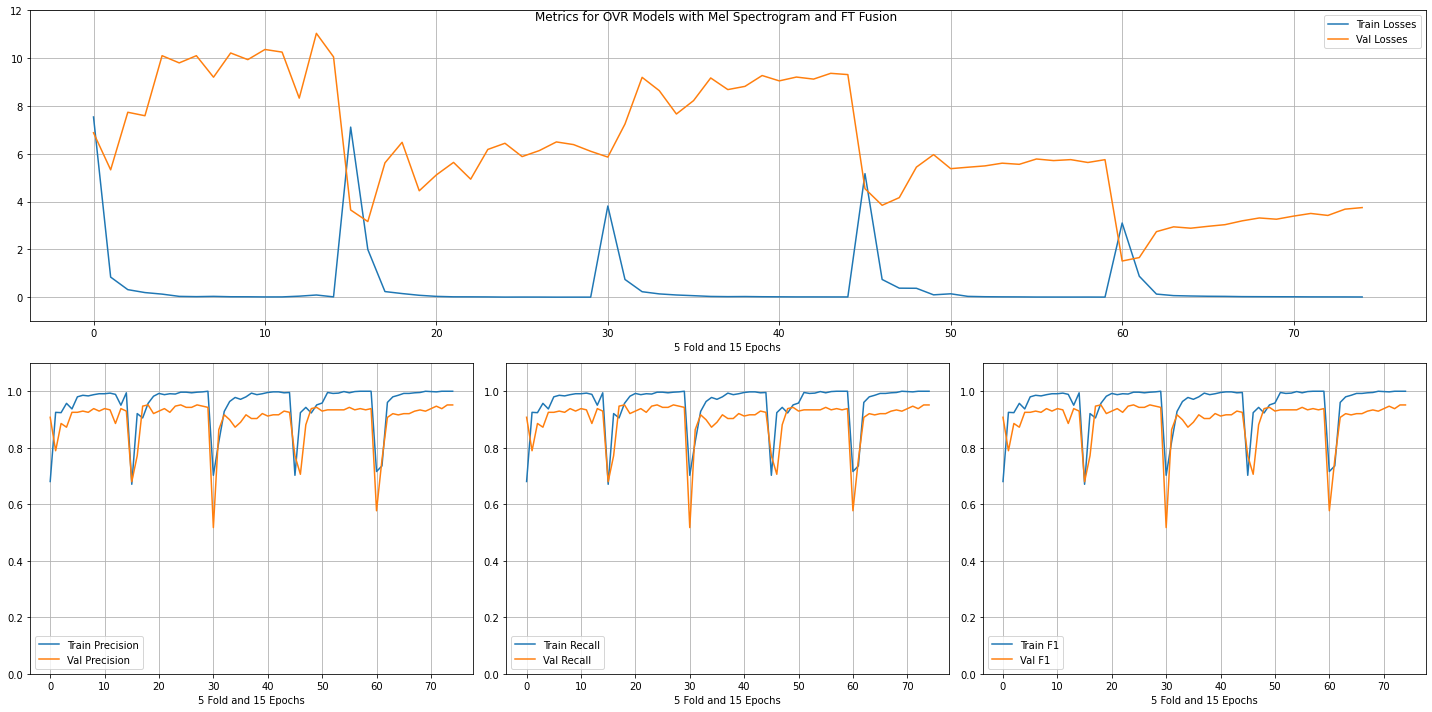

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.996707       0.951754  ...      0.006056           6.498427
3   0.957190       0.951754  ...      0.156362           6.482935
9   0.996707       0.951754  ...      0.008442           6.442134
14  1.000000       0.951542  ...      0.013323           3.751966
13  1.000000       0.951542  ...      0.015549           3.686575
..       ...            ...  ...           ...                ...
1   0.735746       0.757709  ...      0.880946           1.662142
1   0.924259       0.706140  ...      0.745435           3.848580
0   0.670692       0.679825  ...      7.118155           3.651775
0   0.716009       0.577093  ...      3.107737           1.517403
0   0.702525       0.517544  ...      3.818363           5.864527

[75 rows x 8 columns]
Training for ['కన్నడగౌళ'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 9.061 / Validation Lo

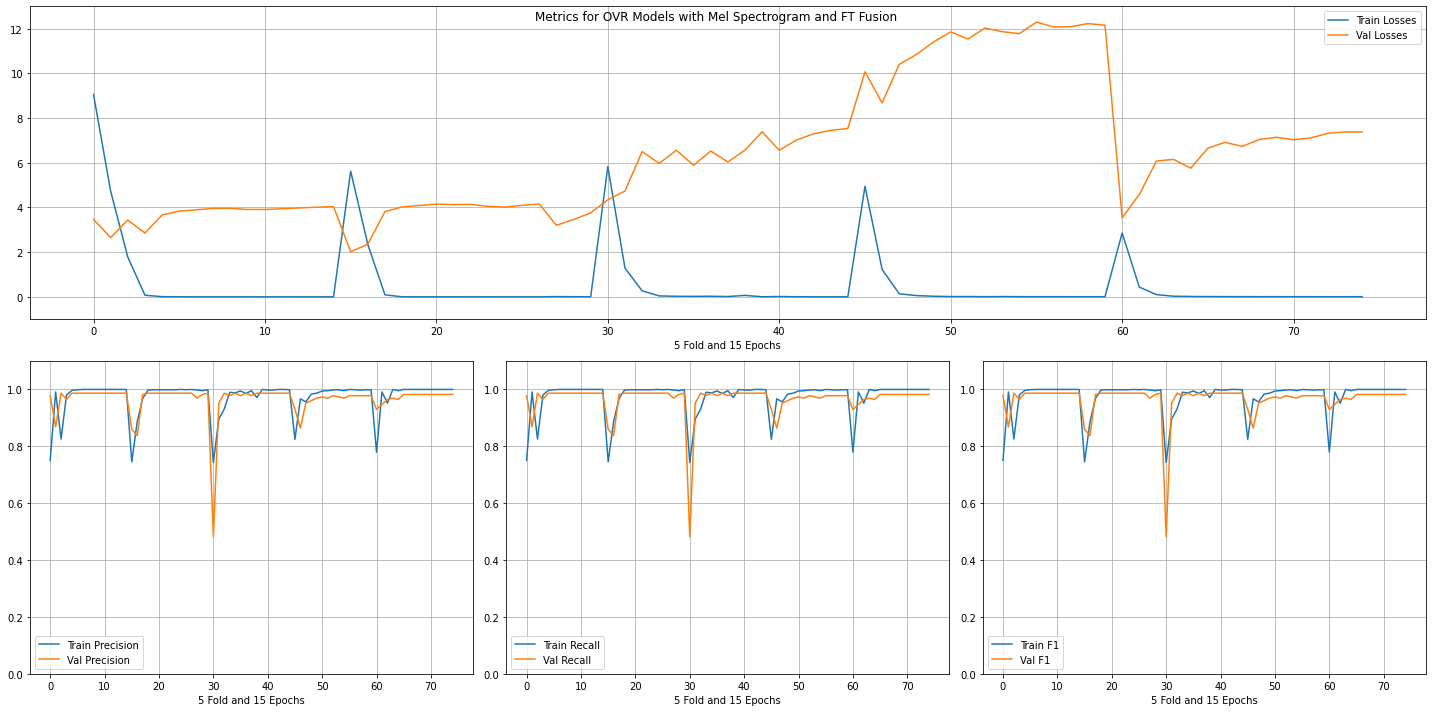

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.998902       0.986842  ...      0.001875           4.098798
6   0.985730       0.986842  ...      0.026475           6.530052
2   0.930845       0.986842  ...      0.271622           6.503728
8   0.971460       0.986842  ...      0.064828           6.569607
9   1.000000       0.986842  ...      0.004935           7.388400
..       ...            ...  ...           ...                ...
1   0.991218       0.868421  ...      4.729282           2.651541
1   0.967069       0.864035  ...      1.226125           8.680292
0   0.745335       0.859649  ...      5.625889           2.016986
1   0.886937       0.837719  ...      2.343688           2.359540
0   0.743139       0.482456  ...      5.833076           4.346367

[75 rows x 8 columns]
Training for ['కాంబోది'] with 19 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50848214 29.97368421]
Epoch 1/15 : Training Loss: 7.633 / Validation Los

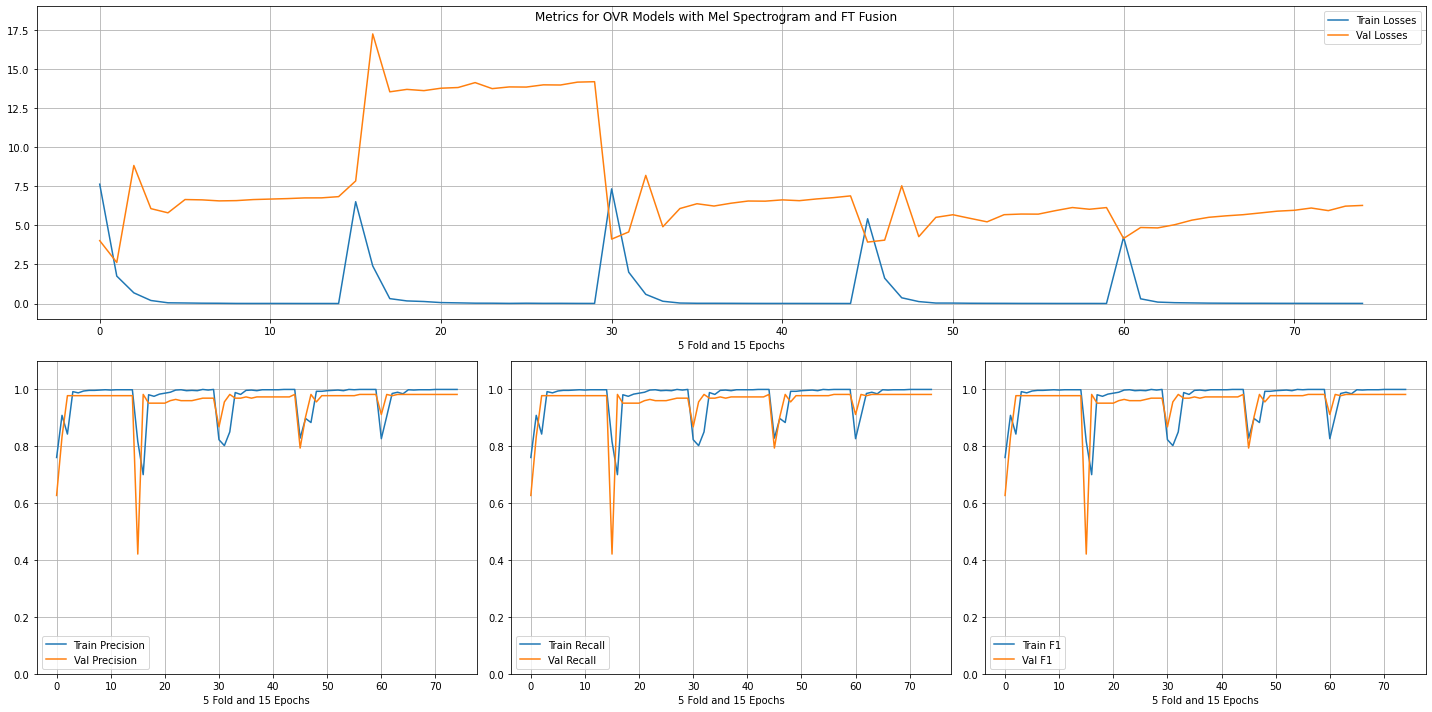

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.982456  ...      0.004534           6.883753
12  1.000000       0.982456  ...      0.007367           6.139291
14  1.000000       0.982456  ...      0.005543           6.136799
13  1.000000       0.982456  ...      0.007441           6.030437
1   0.700329       0.982456  ...      2.403665          17.239516
..       ...            ...  ...           ...                ...
0   0.823271       0.868421  ...      7.333468           4.119599
1   0.908891       0.833333  ...      1.755837           2.625630
0   0.828760       0.793860  ...      5.421291           3.930895
0   0.760703       0.627193  ...      7.632712           4.023150
0   0.816685       0.421053  ...      6.512271           7.839059

[75 rows x 8 columns]
Training for ['గుండుక్రియ'] with 28 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51260126 20.33928571]
Epoch 1/15 : Training Loss: 5.947 / Validation 

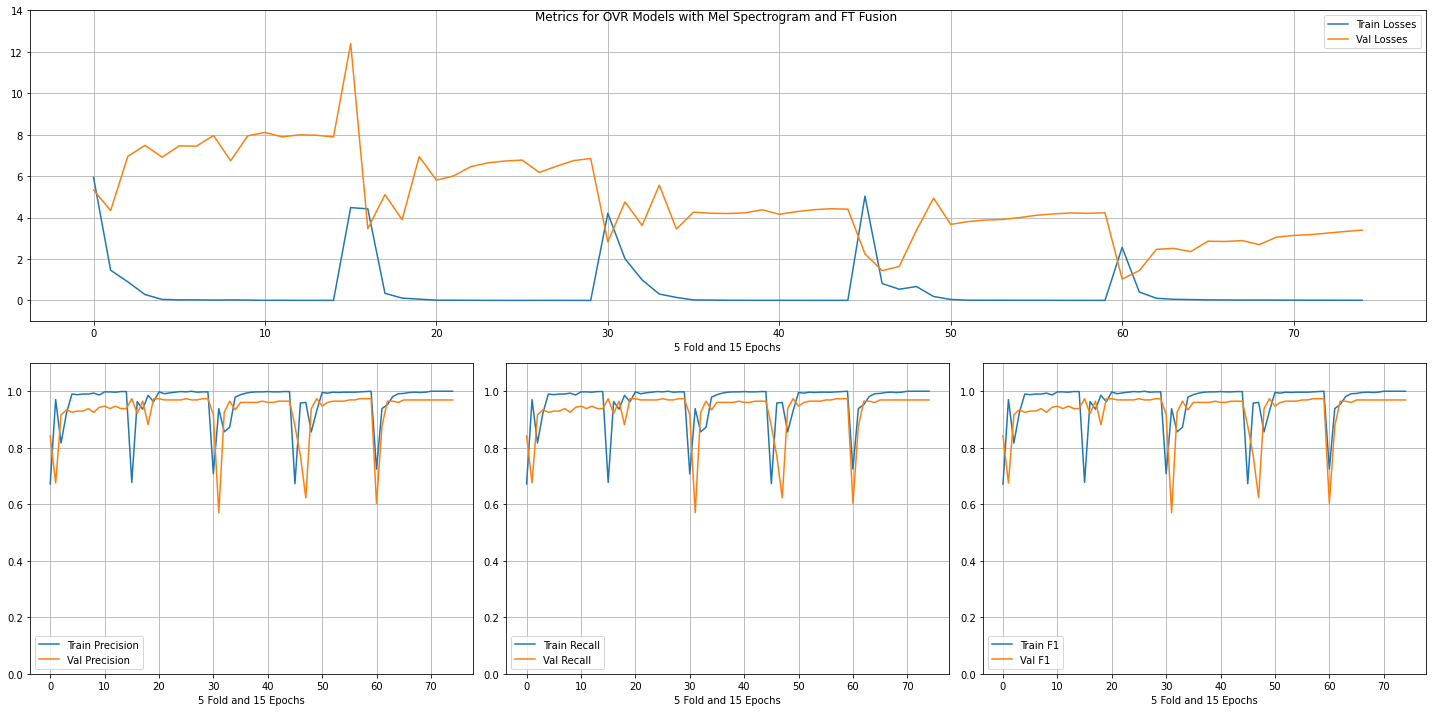

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.997805       0.973684  ...      0.015253           5.807608
10  0.997805       0.973684  ...      0.003775           6.775567
12  0.997805       0.973684  ...      0.006018           4.224533
0   0.677278       0.973684  ...      4.483450          12.401035
13  0.998902       0.973684  ...      0.005831           4.205838
..       ...            ...  ...           ...                ...
1   0.958288       0.771930  ...      0.819252           1.439607
1   0.970362       0.675439  ...      1.459900           4.340301
2   0.960483       0.622807  ...      0.542930           1.643352
0   0.724781       0.603524  ...      2.562601           1.034103
1   0.938529       0.570175  ...      2.013713           4.757704

[75 rows x 8 columns]
Training for ['గుజ్జరి'] with 15 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.5066726  37.96666667]
Epoch 1/15 : Training Loss: 7.787 / Validation Los

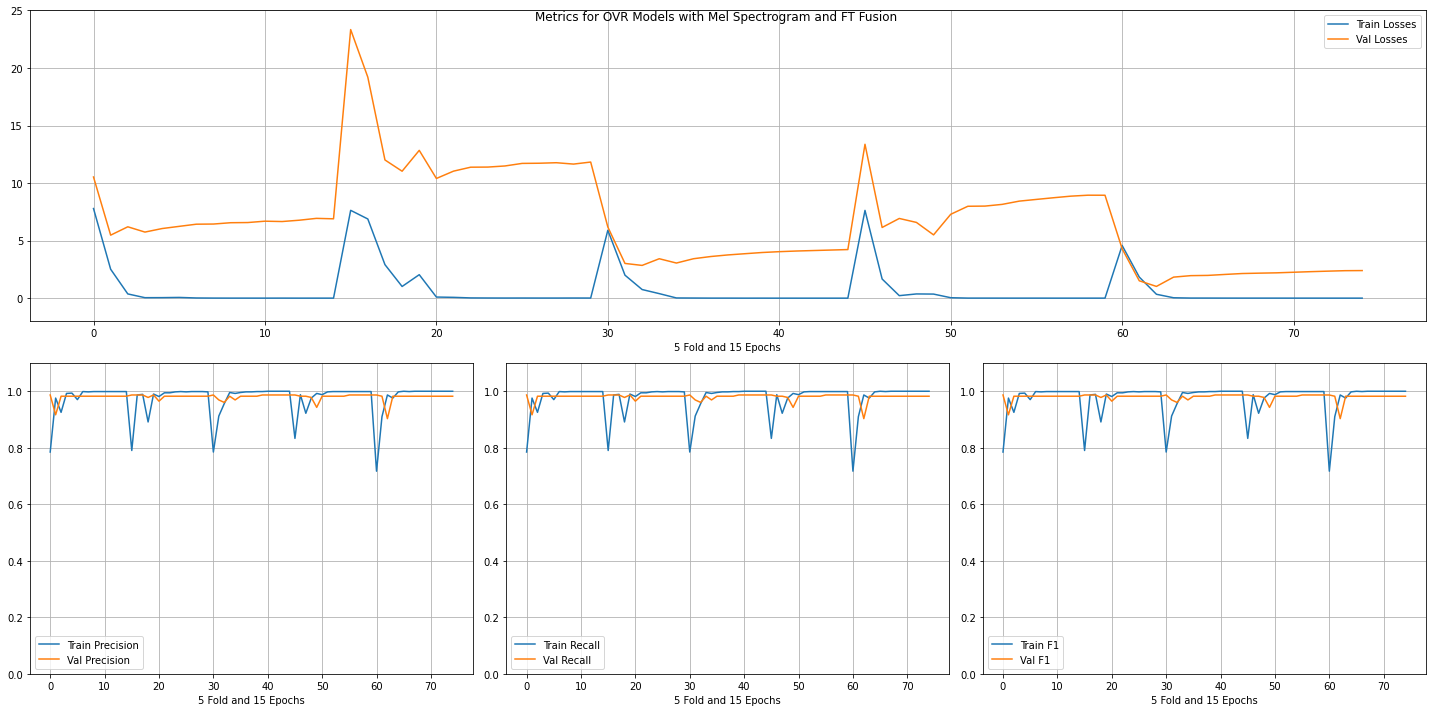

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.784852       0.986842  ...      7.786745          10.527299
0   0.784852       0.986842  ...      5.903574           6.181584
9   0.998902       0.986842  ...      0.003458           3.967453
10  1.000000       0.986842  ...      0.001549           4.040219
11  1.000000       0.986842  ...      0.001285           4.096382
..       ...            ...  ...           ...                ...
5   0.981339       0.964912  ...      0.097715          10.399448
2   0.956092       0.960526  ...      0.750725           2.846835
4   0.992316       0.942982  ...      0.355692           5.498982
1   0.975851       0.916667  ...      2.514563           5.475176
2   0.986842       0.903084  ...      0.339359           1.022039

[75 rows x 8 columns]
Training for ['గౌళ'] with 14 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50622222 40.67857143]
Epoch 1/15 : Training Loss: 10.455 / Validation Loss :

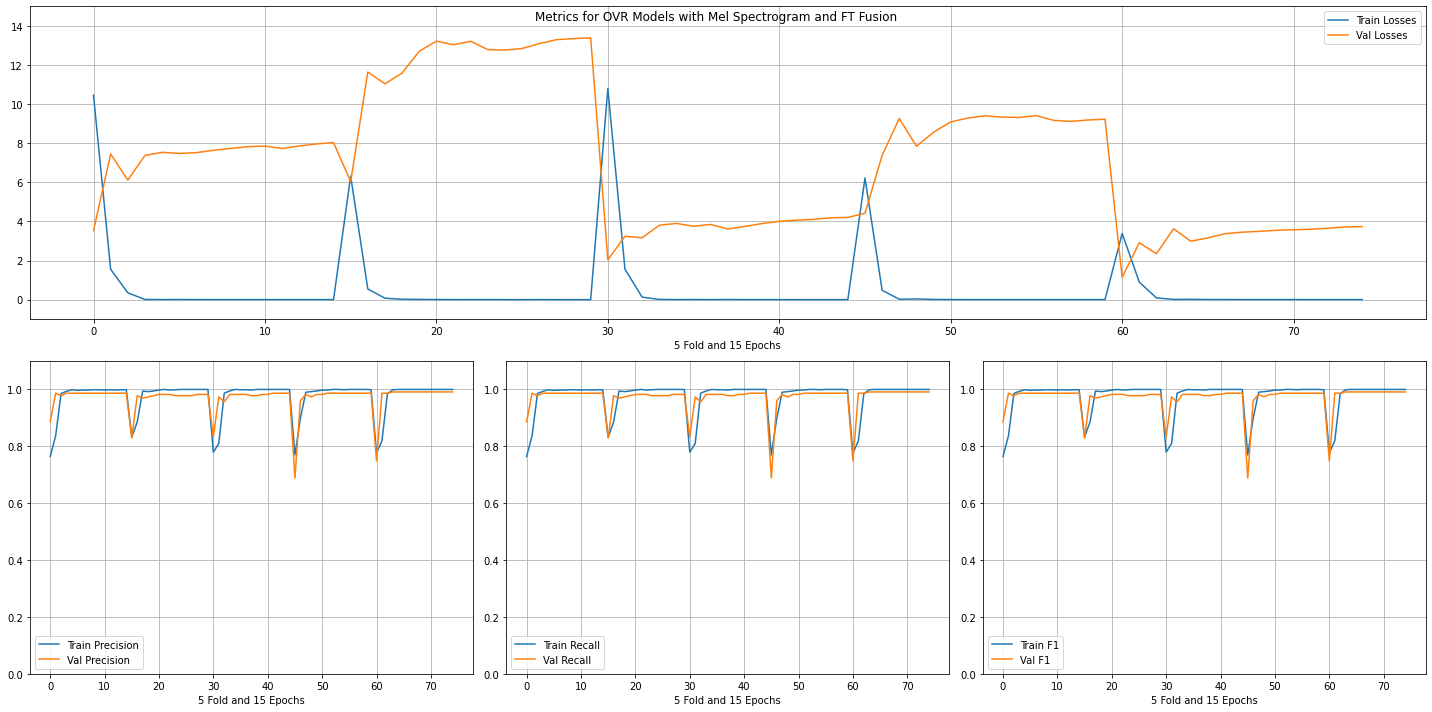

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991189  ...      0.002789           3.738017
5   1.000000       0.991189  ...      0.007262           3.159819
7   1.000000       0.991189  ...      0.004717           3.451184
4   1.000000       0.991189  ...      0.016655           2.989286
3   0.998904       0.991189  ...      0.010582           3.626567
..       ...            ...  ...           ...                ...
0   0.763996       0.885965  ...     10.455336           3.528639
0   0.779363       0.833333  ...     10.801377           2.034324
0   0.832053       0.828947  ...      6.317578           6.036323
0   0.776316       0.748899  ...      3.388812           1.139755
0   0.769484       0.688596  ...      6.221429           4.419347

[75 rows x 8 columns]
Training for ['దేవగాంధారి'] with 35 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51585145 16.27142857]
Epoch 1/15 : Training Loss: 8.060 / Validation 

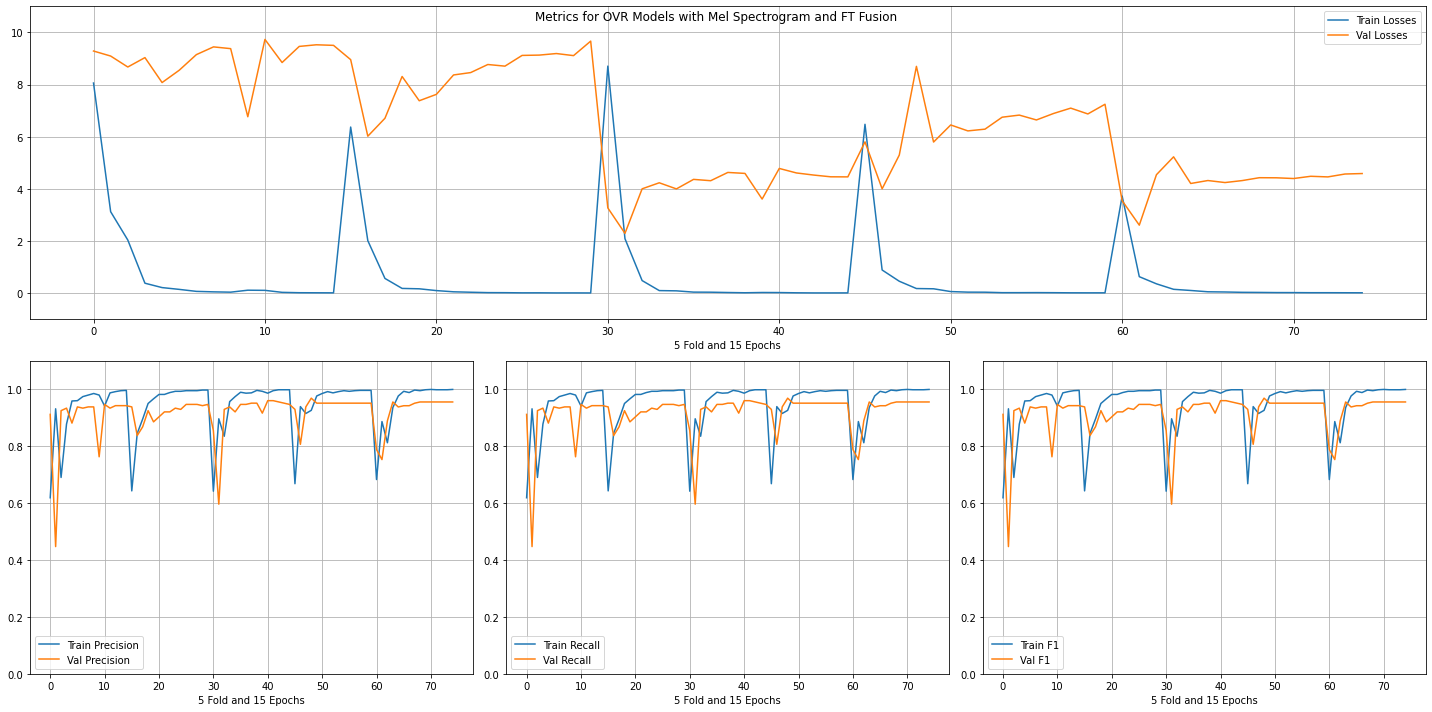

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.926454       0.969298  ...      0.176231           8.699234
10  0.986828       0.960526  ...      0.021930           4.783515
11  0.995609       0.960526  ...      0.012844           4.610726
12  0.998902       0.956140  ...      0.008371           4.530116
8   0.995614       0.955947  ...      0.027130           4.428153
..       ...            ...  ...           ...                ...
0   0.683114       0.788546  ...      3.723042           3.545854
9   0.980241       0.763158  ...      0.112526           6.766475
1   0.887061       0.753304  ...      0.631203           2.607911
1   0.896817       0.596491  ...      2.088078           2.293512
1   0.931943       0.447368  ...      3.123968           9.095579

[75 rows x 8 columns]
Training for ['దేసాక్షి'] with 29 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51306306 19.63793103]
Epoch 1/15 : Training Loss: 12.144 / Validation L

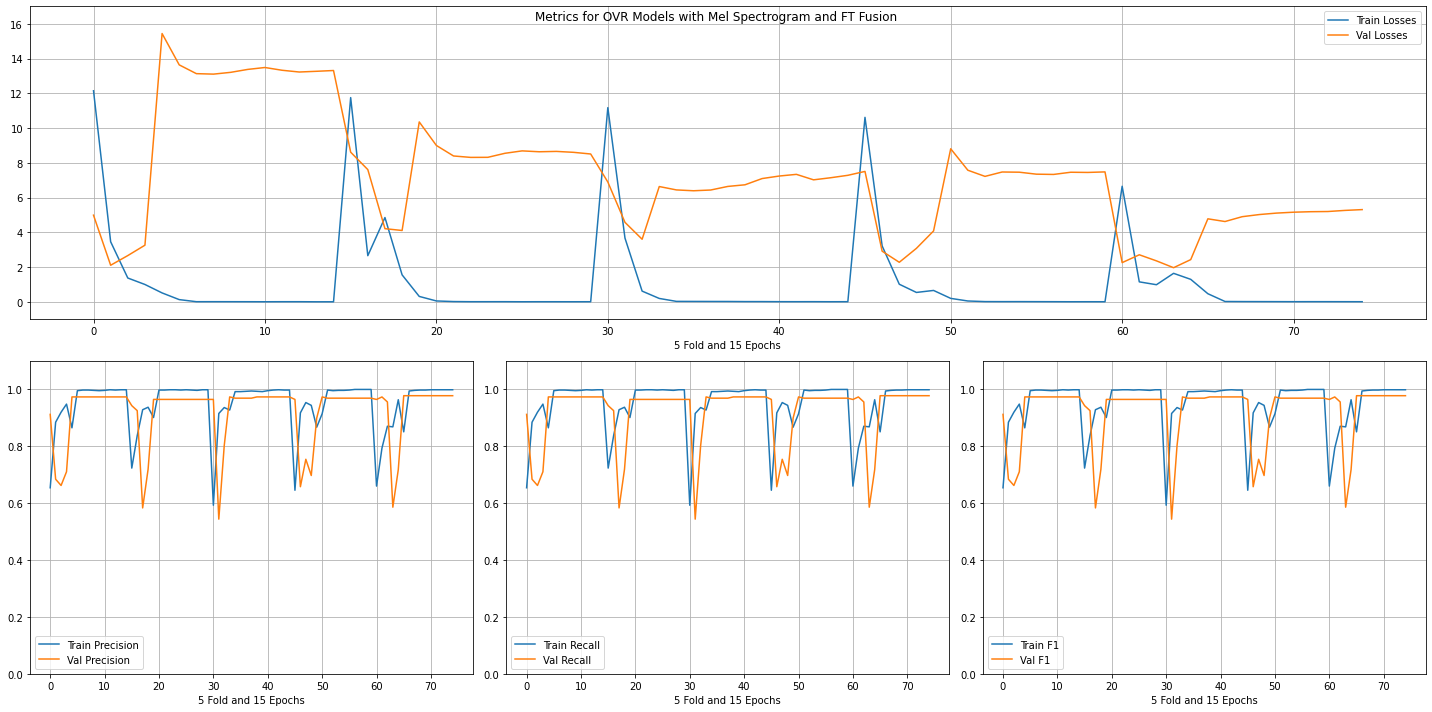

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.998904       0.977974  ...      0.006411           5.306581
11  0.998904       0.977974  ...      0.009240           5.185732
5   0.850877       0.977974  ...      0.466129           4.776381
7   0.996711       0.977974  ...      0.014241           4.898541
8   0.997807       0.977974  ...      0.012285           5.022078
..       ...            ...  ...           ...                ...
2   0.919868       0.662281  ...      1.370074           2.661507
1   0.917673       0.657895  ...      3.216923           2.914247
3   0.868421       0.585903  ...      1.639318           1.963537
2   0.928650       0.583333  ...      4.849949           4.209038
1   0.915477       0.543860  ...      3.667733           4.572827

[75 rows x 8 columns]
Training for ['దేసాళం'] with 40 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51819836 14.2375    ]
Epoch 1/15 : Training Loss: 7.184 / Validation Loss

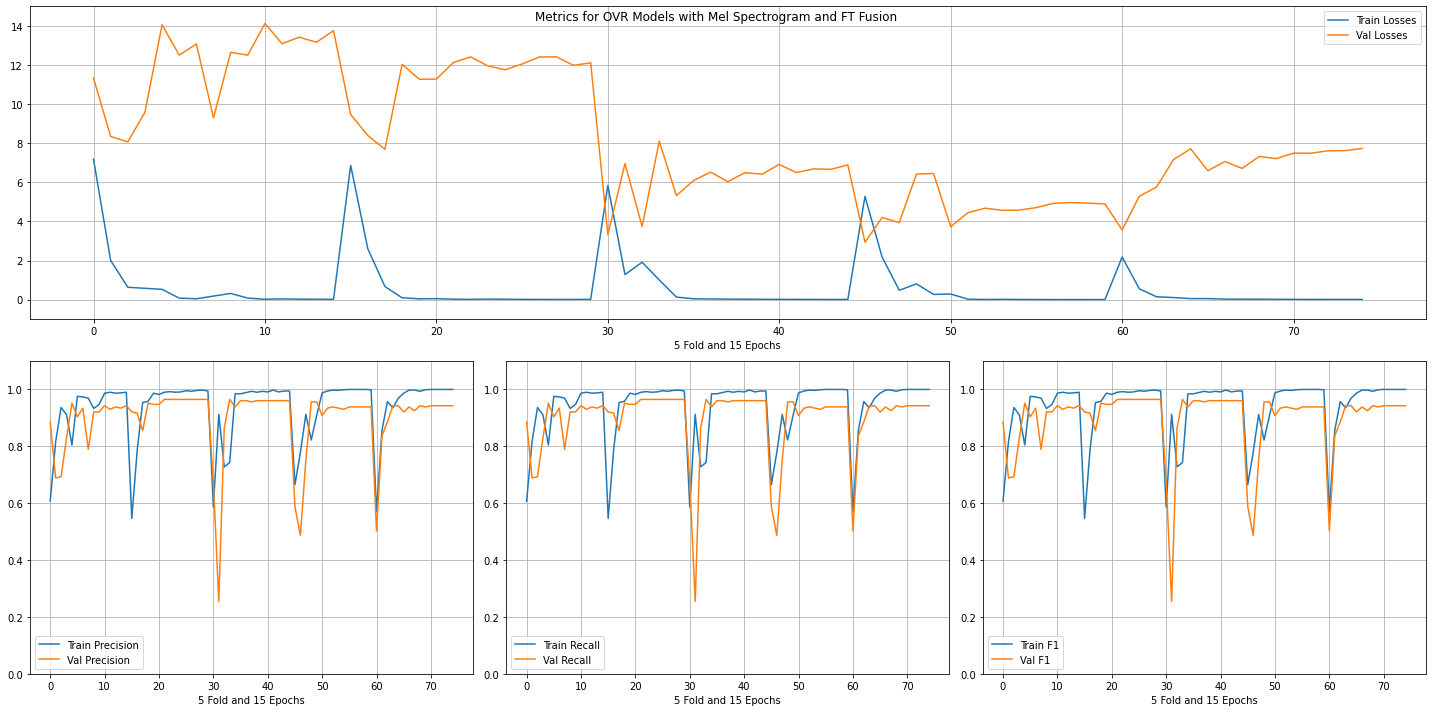

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.743139       0.964912  ...      1.006866           8.106601
14  0.994512       0.964912  ...      0.014423          12.111934
13  0.997805       0.964912  ...      0.010929          11.986045
12  0.996707       0.964912  ...      0.010799          12.419576
11  0.993414       0.964912  ...      0.012299          12.410518
..       ...            ...  ...           ...                ...
0   0.586169       0.675439  ...      5.839668           3.320099
0   0.665203       0.587719  ...      5.281395           2.936325
0   0.570175       0.502203  ...      2.180323           3.564936
1   0.778266       0.486842  ...      2.173812           4.200745
1   0.912184       0.254386  ...      1.283513           6.959313

[75 rows x 8 columns]
Training for ['ధన్నాసి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 9.891 / Validation Los

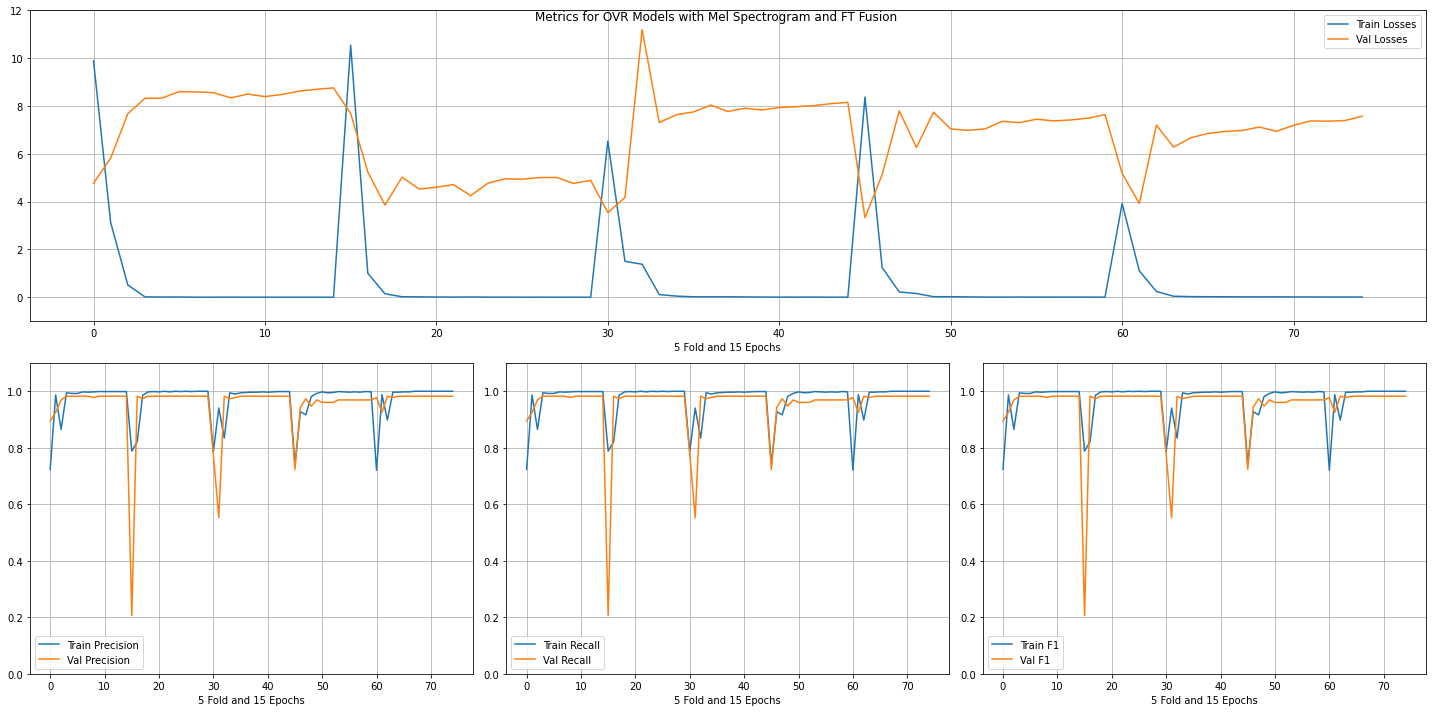

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.996707       0.982456  ...      0.020837           7.771542
5   0.997805       0.982456  ...      0.012105           4.605406
7   0.997805       0.982456  ...      0.011868           4.251894
9   0.998902       0.982456  ...      0.007182           4.955363
10  1.000000       0.982456  ...      0.004890           4.938382
..       ...            ...  ...           ...                ...
0   0.723381       0.894737  ...      9.890799           4.772108
0   0.787047       0.776316  ...      6.532997           3.543186
0   0.740944       0.723684  ...      8.376214           3.329310
1   0.940724       0.552632  ...      1.503460           4.174637
0   0.788145       0.206140  ...     10.542054           7.687393

[75 rows x 8 columns]
Training for ['నాట'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 7.040 / Validation Loss : 

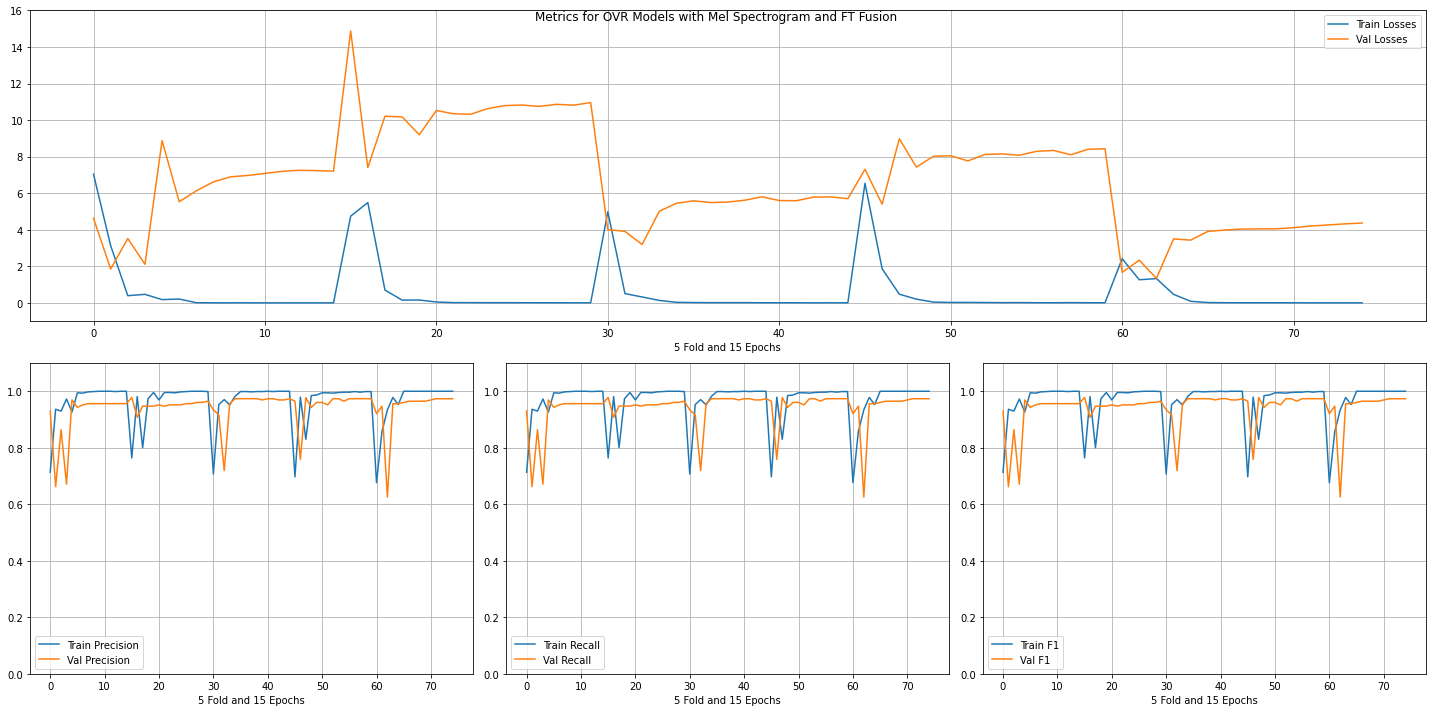

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.763996       0.978070  ...      4.746977          14.877477
2   0.829857       0.978070  ...      0.478148           8.977791
7   0.997805       0.973684  ...      0.013472           5.515567
4   0.982437       0.973684  ...      0.032849           5.452400
6   0.998902       0.973684  ...      0.014078           5.490237
..       ...            ...  ...           ...                ...
1   0.979144       0.758772  ...      1.868180           5.397812
2   0.970362       0.719298  ...      0.324952           3.194607
3   0.972558       0.671053  ...      0.469349           2.115107
1   0.936334       0.662281  ...      3.133039           1.855222
2   0.934211       0.625551  ...      1.331484           1.342868

[75 rows x 8 columns]
Training for ['నాదరామక్రియ'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 9.561 / Validation

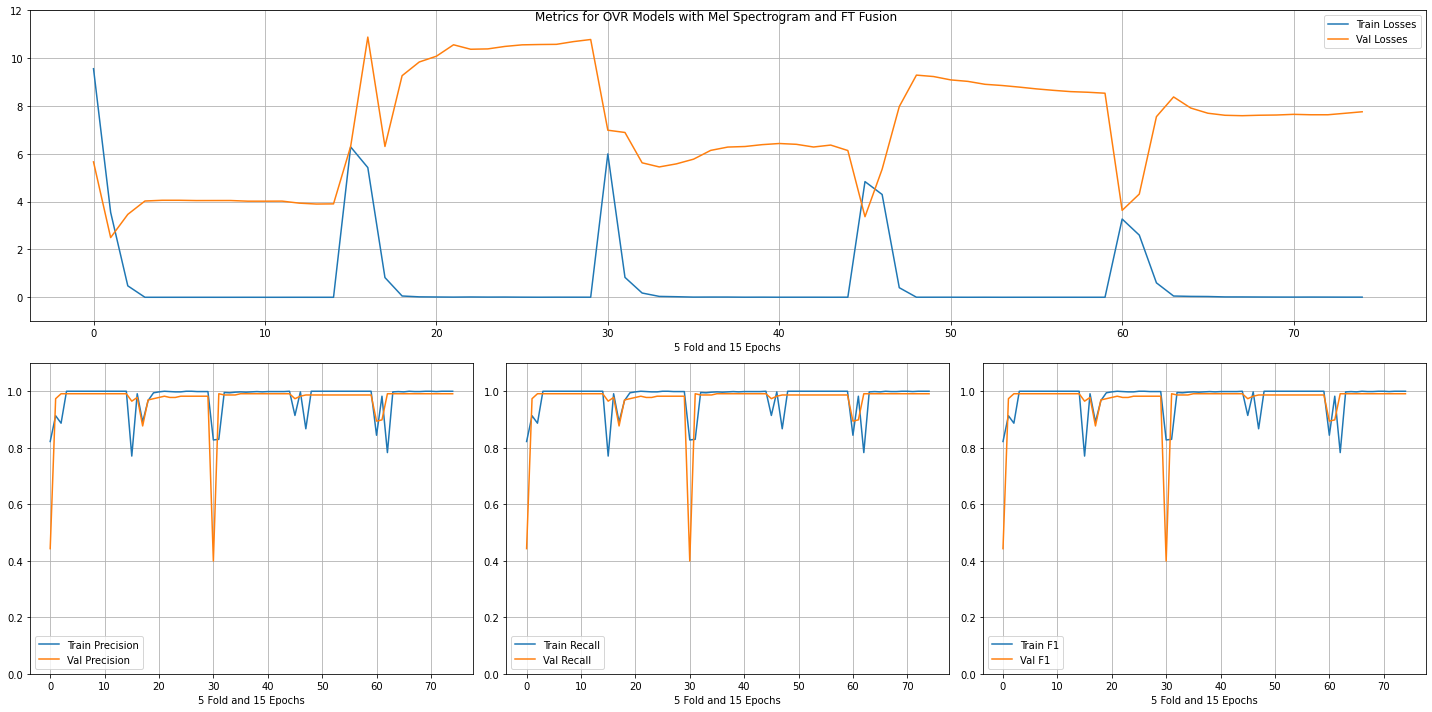

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.997805       0.991228  ...      0.009692           6.283700
13  1.000000       0.991228  ...      0.000169           3.900520
8   0.998902       0.991228  ...      0.004120           6.306862
9   0.997805       0.991228  ...      0.005656           6.384810
10  0.998902       0.991228  ...      0.002909           6.432389
..       ...            ...  ...           ...                ...
1   0.982456       0.898678  ...      2.600089           4.318251
0   0.844298       0.894273  ...      3.273867           3.636036
2   0.891328       0.877193  ...      0.824981           6.308561
0   0.822173       0.442982  ...      9.561285           5.664008
0   0.827662       0.399123  ...      5.998119           6.988479

[75 rows x 8 columns]
Training for ['పాడి'] with 49 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52247706 11.62244898]
Epoch 1/15 : Training Loss: 8.979 / Validation Loss :

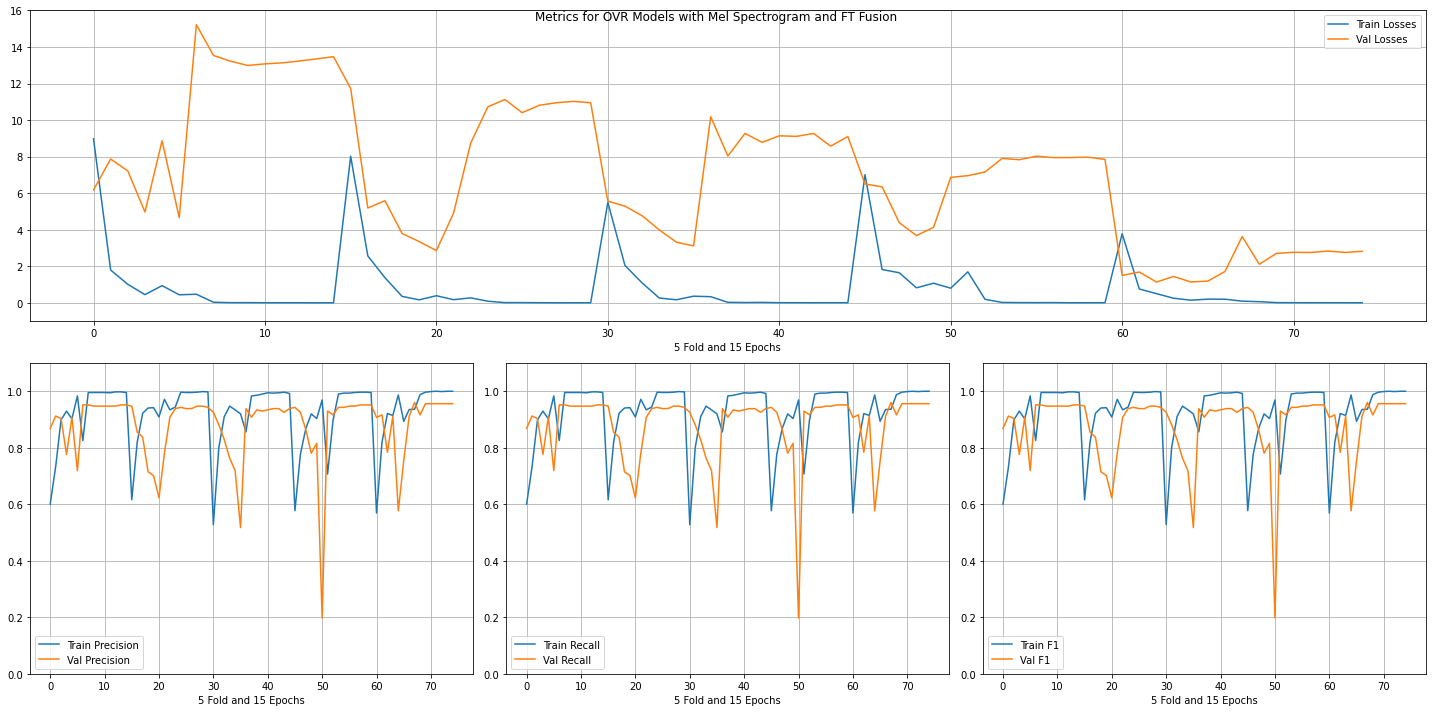

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.936404       0.960352  ...      0.097547           3.630332
14  1.000000       0.955947  ...      0.009061           2.820219
13  1.000000       0.955947  ...      0.010611           2.762005
12  0.998904       0.955947  ...      0.010870           2.836540
11  1.000000       0.955947  ...      0.011513           2.757669
..       ...            ...  ...           ...                ...
4   0.941822       0.701754  ...      0.168404           3.354611
5   0.908891       0.622807  ...      0.393164           2.862161
4   0.986842       0.577093  ...      0.150284           1.148418
5   0.919868       0.517544  ...      0.368245           3.117364
5   0.969265       0.197368  ...      0.805526           6.867278

[75 rows x 8 columns]
Training for ['బౌళి'] with 70 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53274088 8.13571429]
Epoch 1/15 : Training Loss: 9.013 / Validation Loss : 6

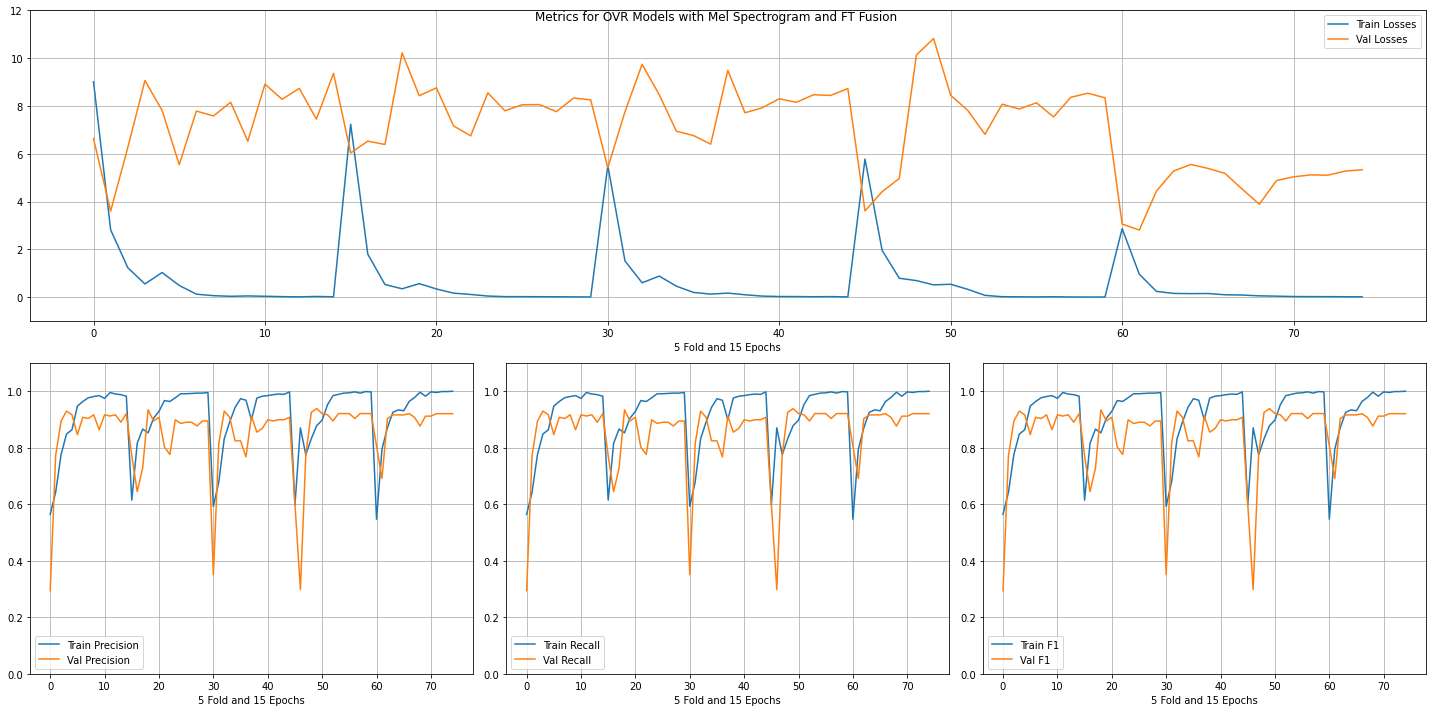

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.878156       0.938596  ...      0.520066          10.823527
3   0.852909       0.934211  ...      0.354816          10.224850
2   0.832053       0.929825  ...      0.606550           9.744665
3   0.848518       0.929825  ...      0.558768           9.068052
3   0.832053       0.925439  ...      0.698017          10.133707
..       ...            ...  ...           ...                ...
1   0.815587       0.644737  ...      1.801996           6.533127
0   0.597146       0.600877  ...      5.783072           3.613386
0   0.592755       0.350877  ...      5.512721           5.419452
1   0.870472       0.298246  ...      1.962462           4.417106
0   0.564215       0.293860  ...      9.013114           6.636237

[75 rows x 8 columns]
Training for ['బౌళిరామక్రియ'] with 13 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50577265 43.80769231]
Epoch 1/15 : Training Loss: 7.248 / Validatio

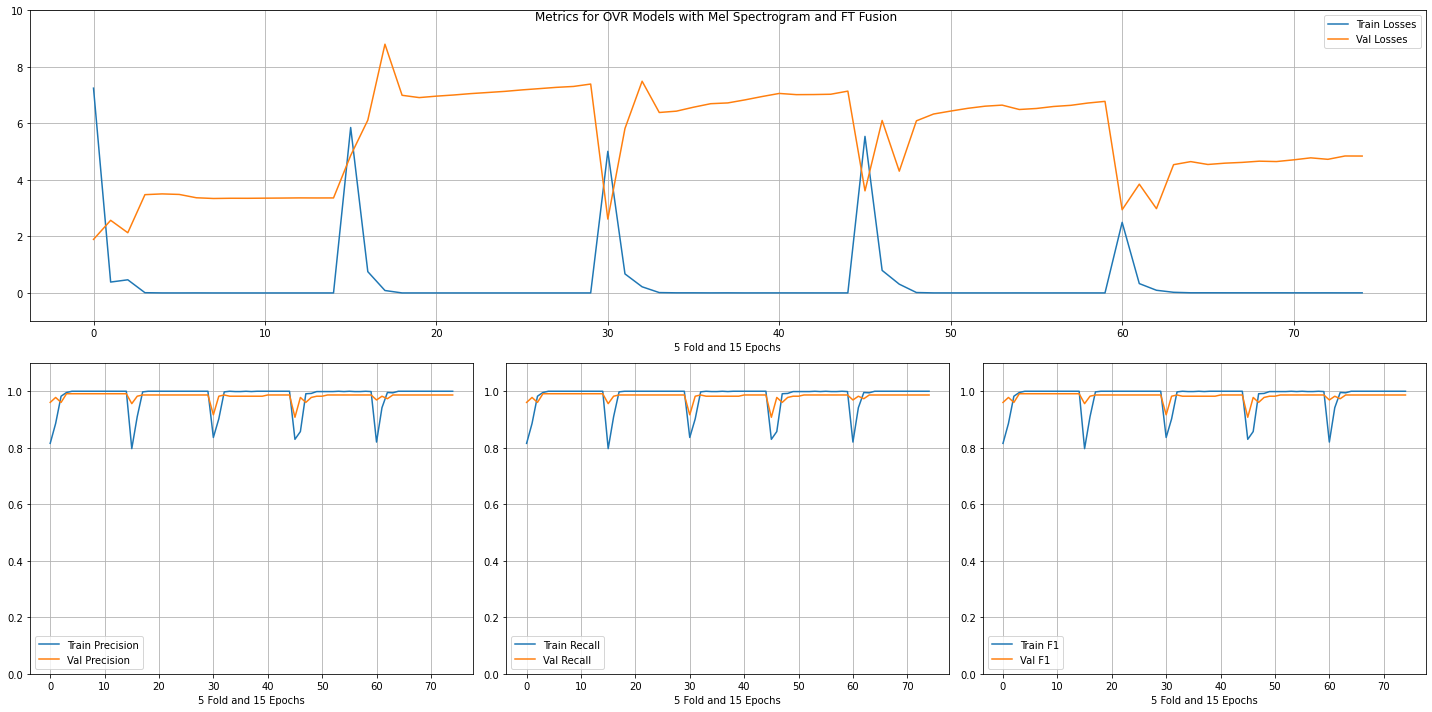

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991228  ...      0.000232           3.363031
7   1.000000       0.991228  ...      0.000470           3.342955
13  1.000000       0.991228  ...      0.000225           3.361704
12  1.000000       0.991228  ...      0.000160           3.363955
11  1.000000       0.991228  ...      0.000249           3.358440
..       ...            ...  ...           ...                ...
2   0.982437       0.960526  ...      0.465275           2.131006
0   0.815587       0.960526  ...      7.248062           1.895219
0   0.796926       0.956140  ...      5.855743           4.864712
0   0.836443       0.916667  ...      5.012112           2.614419
0   0.829857       0.907895  ...      5.540686           3.613476

[75 rows x 8 columns]
Training for ['భూపాలం'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51445348 17.796875  ]
Epoch 1/15 : Training Loss: 10.290 / Validation Los

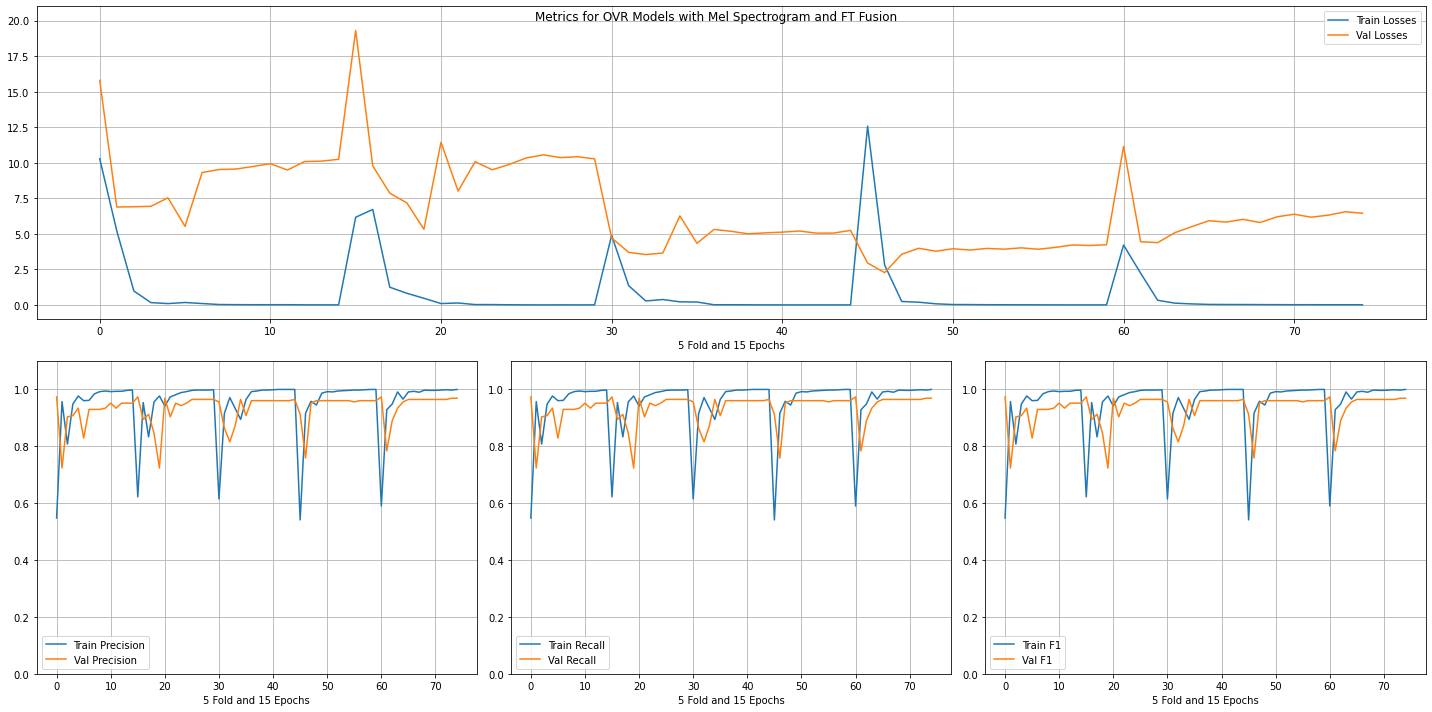

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.547750       0.973684  ...     10.289697          15.795922
0   0.622393       0.973684  ...      6.170392          19.298893
0   0.589912       0.973568  ...      4.213820          11.147808
5   0.941822       0.969298  ...      0.099622          11.452212
13  0.997807       0.969163  ...      0.016305           6.558315
..       ...            ...  ...           ...                ...
2   0.971460       0.815789  ...      0.282370           3.545363
1   0.928728       0.784141  ...      2.237925           4.447457
1   0.916575       0.758772  ...      2.806453           2.274994
4   0.976948       0.723684  ...      0.470827           5.324237
1   0.957190       0.723684  ...      5.210563           6.888749

[75 rows x 8 columns]
Training for ['భైరవి'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51214029 21.09259259]
Epoch 1/15 : Training Loss: 7.358 / Validation Loss 

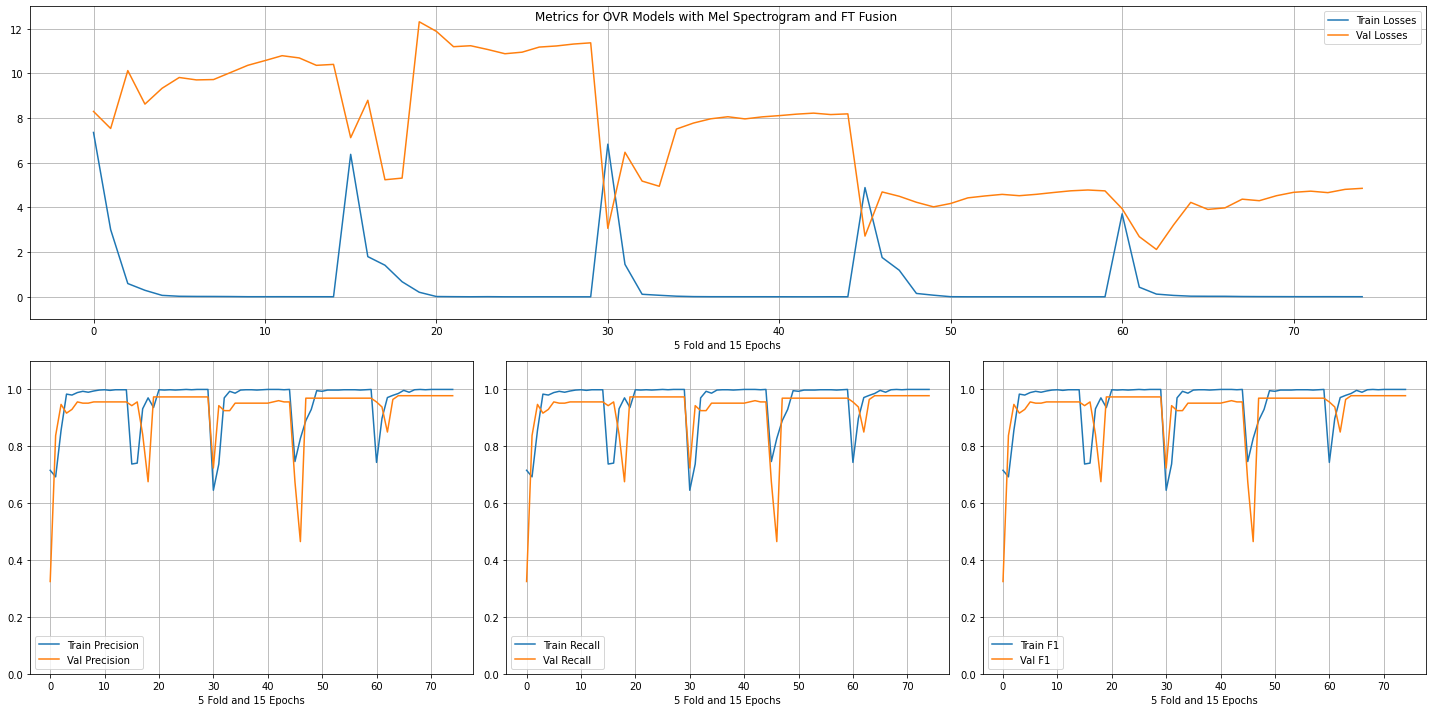

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977974  ...      0.006919           4.857157
13  1.000000       0.977974  ...      0.007237           4.810803
12  1.000000       0.977974  ...      0.008539           4.664622
11  1.000000       0.977974  ...      0.007891           4.730622
4   0.985746       0.977974  ...      0.030307           4.228002
..       ...            ...  ...           ...                ...
0   0.645445       0.723684  ...      6.834533           3.066893
3   0.970362       0.675439  ...      0.676936           5.315063
0   0.746432       0.675439  ...      4.891164           2.719991
1   0.827662       0.464912  ...      1.761496           4.695593
0   0.715697       0.324561  ...      7.357871           8.299144

[75 rows x 8 columns]
Training for ['మలహరి'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 10.894 / Validation Loss

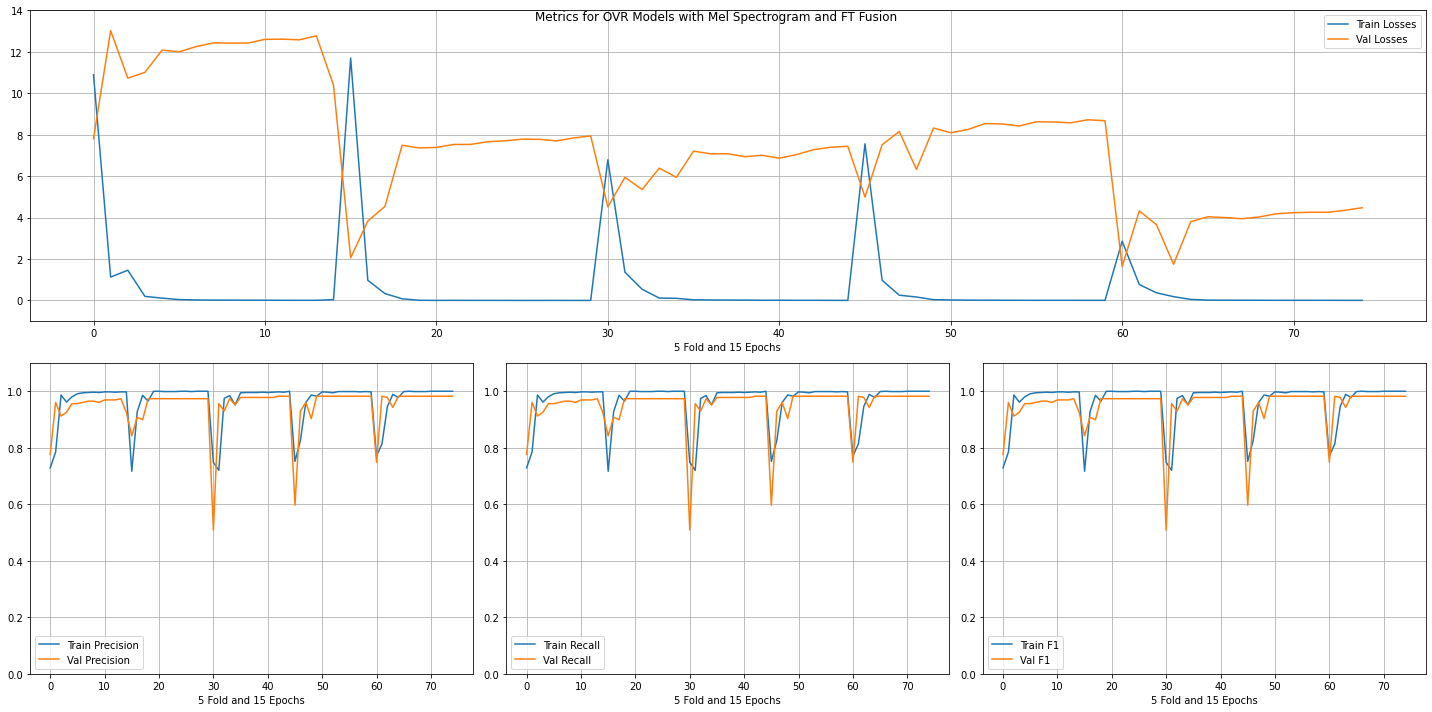

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.998902       0.982456  ...      0.008814           8.614710
13  0.998902       0.982456  ...      0.006740           8.722512
12  0.997805       0.982456  ...      0.008929           7.278557
13  0.996707       0.982456  ...      0.006095           7.397283
14  1.000000       0.982456  ...      0.004389           7.440414
..       ...            ...  ...           ...                ...
0   0.716795       0.842105  ...     11.701587           2.061209
0   0.728869       0.776316  ...     10.893673           7.804736
0   0.770833       0.748899  ...      2.860208           1.634241
0   0.751921       0.596491  ...      7.560495           4.991580
0   0.748628       0.508772  ...      6.789735           4.517052

[75 rows x 8 columns]
Training for ['మాళవి'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 7.434 / Validation Loss 

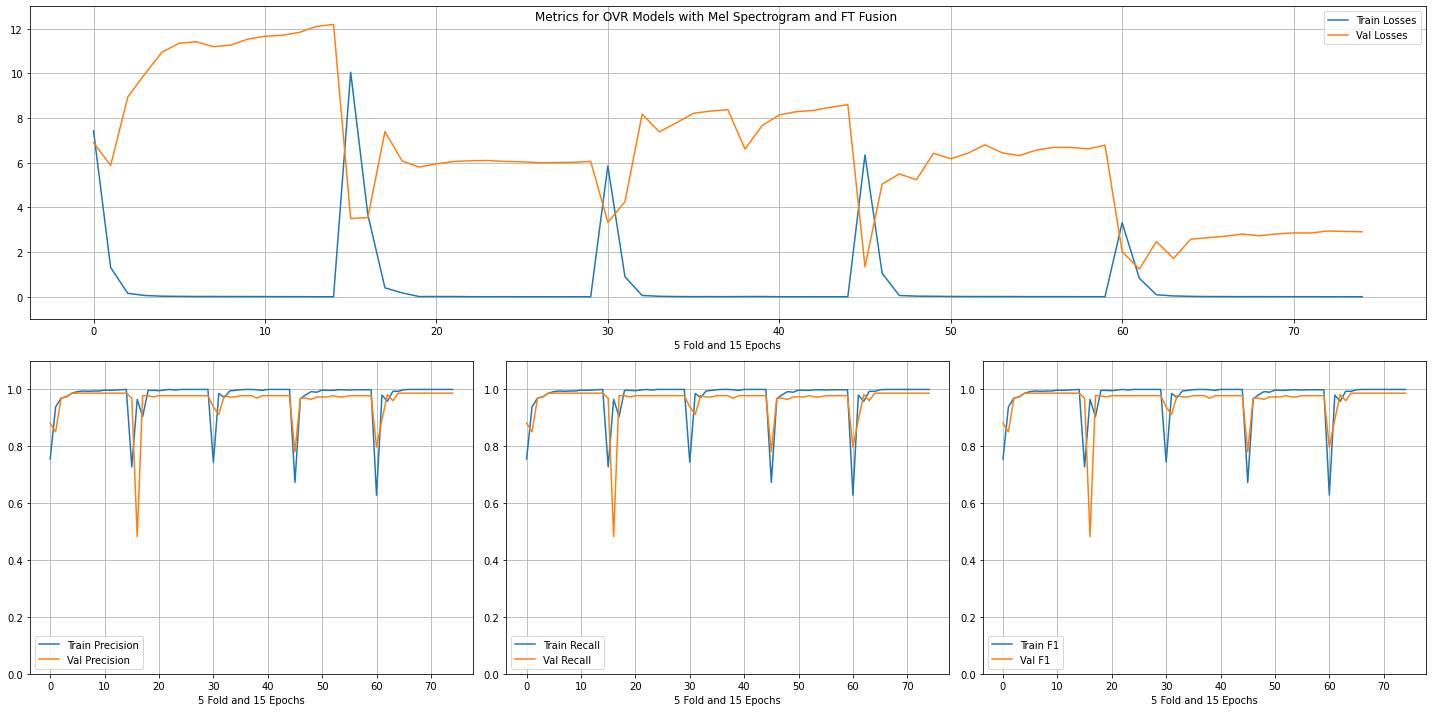

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.994512       0.986842  ...      0.014316          11.271205
12  0.997805       0.986842  ...      0.008733          11.833736
14  1.000000       0.986842  ...      0.004547          12.192623
4   0.986828       0.986842  ...      0.029495          10.953241
5   0.992316       0.986842  ...      0.022239          11.351645
..       ...            ...  ...           ...                ...
0   0.755214       0.881579  ...      7.434227           6.902416
1   0.938529       0.850877  ...      1.311868           5.882909
0   0.628289       0.797357  ...      3.318703           2.028919
0   0.672887       0.780702  ...      6.351102           1.346761
1   0.964874       0.482456  ...      3.686015           3.548182

[75 rows x 8 columns]
Training for ['మాళవిగౌళ'] with 18 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50802855 31.63888889]
Epoch 1/15 : Training Loss: 8.267 / Validation Lo

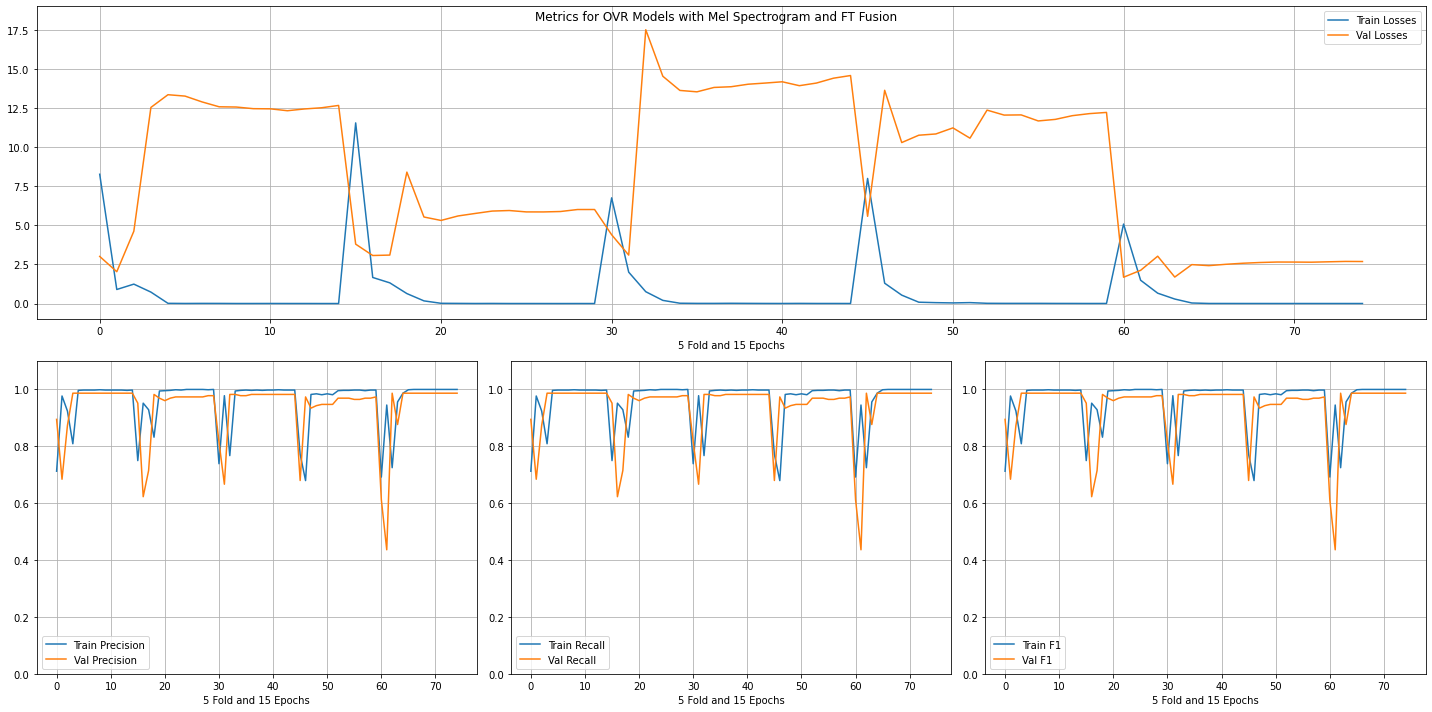

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.997805       0.986842  ...      0.004663          12.460869
3   0.809001       0.986842  ...      0.733027          12.540621
4   0.996707       0.986842  ...      0.014795          13.353242
5   0.997805       0.986842  ...      0.006774          13.265183
6   0.997805       0.986842  ...      0.010897          12.892013
..       ...            ...  ...           ...                ...
0   0.771679       0.679825  ...      7.999660           5.578131
1   0.978046       0.666667  ...      2.007872           3.099317
1   0.951701       0.622807  ...      1.668329           3.072465
0   0.691886       0.612335  ...      5.082533           1.683541
1   0.945175       0.436123  ...      1.491207           2.125653

[75 rows x 8 columns]
Training for ['ముఖారి'] with 55 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.525369   10.35454545]
Epoch 1/15 : Training Loss: 8.531 / Validation Loss

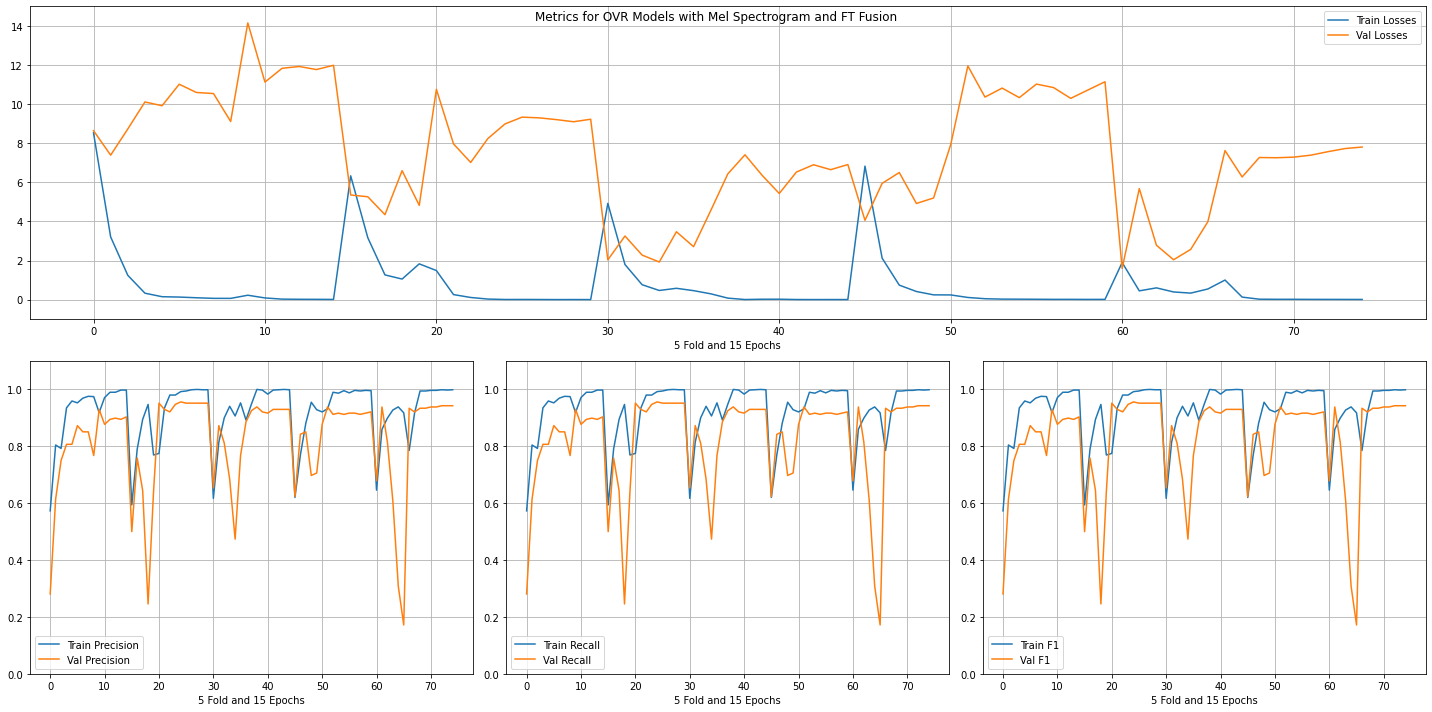

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.992316       0.956140  ...      0.008388           8.986881
10  0.994512       0.951754  ...      0.009779           9.336288
11  0.998902       0.951754  ...      0.007360           9.298369
5   0.774973       0.951754  ...      1.488261          10.758405
12  1.000000       0.951754  ...      0.004169           9.209235
..       ...            ...  ...           ...                ...
4   0.906696       0.473684  ...      0.580721           3.473226
4   0.938596       0.308370  ...      0.334208           2.571126
0   0.572997       0.280702  ...      8.530908           8.644943
3   0.947311       0.245614  ...      1.053343           6.596847
5   0.917763       0.171806  ...      0.545854           3.989576

[75 rows x 8 columns]
Training for ['రామక్రియ'] with 61 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.52829314 9.33606557]
Epoch 1/15 : Training Loss: 6.520 / Validation Loss

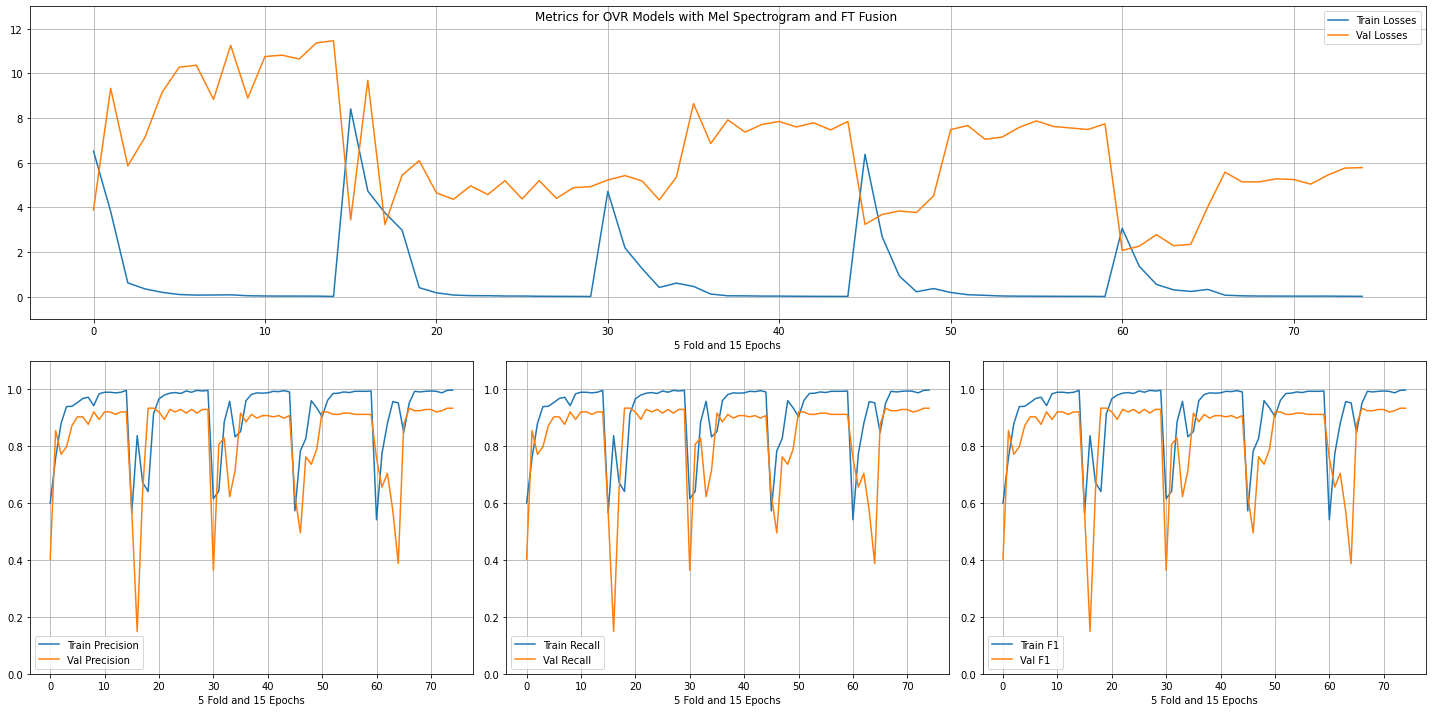

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.641054       0.934211  ...      2.985444           5.440740
4   0.914380       0.934211  ...      0.410632           6.095313
6   0.951754       0.933921  ...      0.075337           5.579492
14  0.997807       0.933921  ...      0.024220           5.783864
13  0.996711       0.933921  ...      0.027090           5.764673
..       ...            ...  ...           ...                ...
1   0.783754       0.495614  ...      2.696094           3.685877
0   0.600439       0.403509  ...      6.519551           3.897100
4   0.952851       0.387665  ...      0.242259           2.349534
0   0.615807       0.364035  ...      4.720946           5.231644
1   0.837541       0.149123  ...      4.735976           9.692934

[75 rows x 8 columns]
Training for ['లలిత'] with 98 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54707012 5.81122449]
Epoch 1/15 : Training Loss: 6.450 / Validation Loss : 8

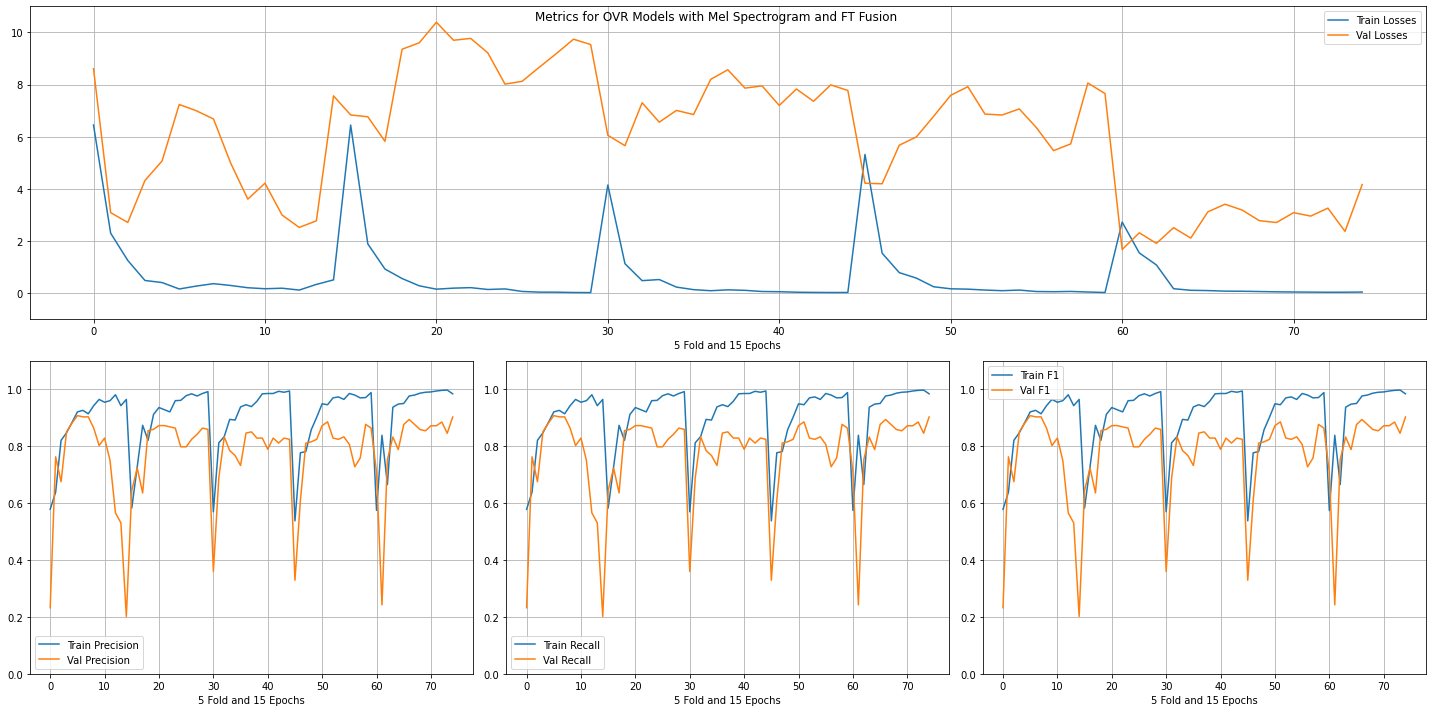

    train_f1  validation_f1  ...  train_losses  validation_losses
5   0.920966       0.907895  ...      0.159356           7.237711
7   0.914380       0.903509  ...      0.363103           6.679831
6   0.926454       0.903509  ...      0.271166           6.996516
14  0.984649       0.903084  ...      0.041114           4.164309
6   0.976974       0.894273  ...      0.076801           3.411272
..       ...            ...  ...           ...                ...
0   0.569704       0.359649  ...      4.147005           6.055322
0   0.537870       0.328947  ...      5.320268           4.215131
1   0.838816       0.242291  ...      1.542880           2.313372
0   0.578485       0.232456  ...      6.449605           8.606597
14  0.964874       0.201754  ...      0.508904           7.567094

[75 rows x 8 columns]
Training for ['వరాళి'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50984781 25.88636364]
Epoch 1/15 : Training Loss: 6.187 / Validation Loss 

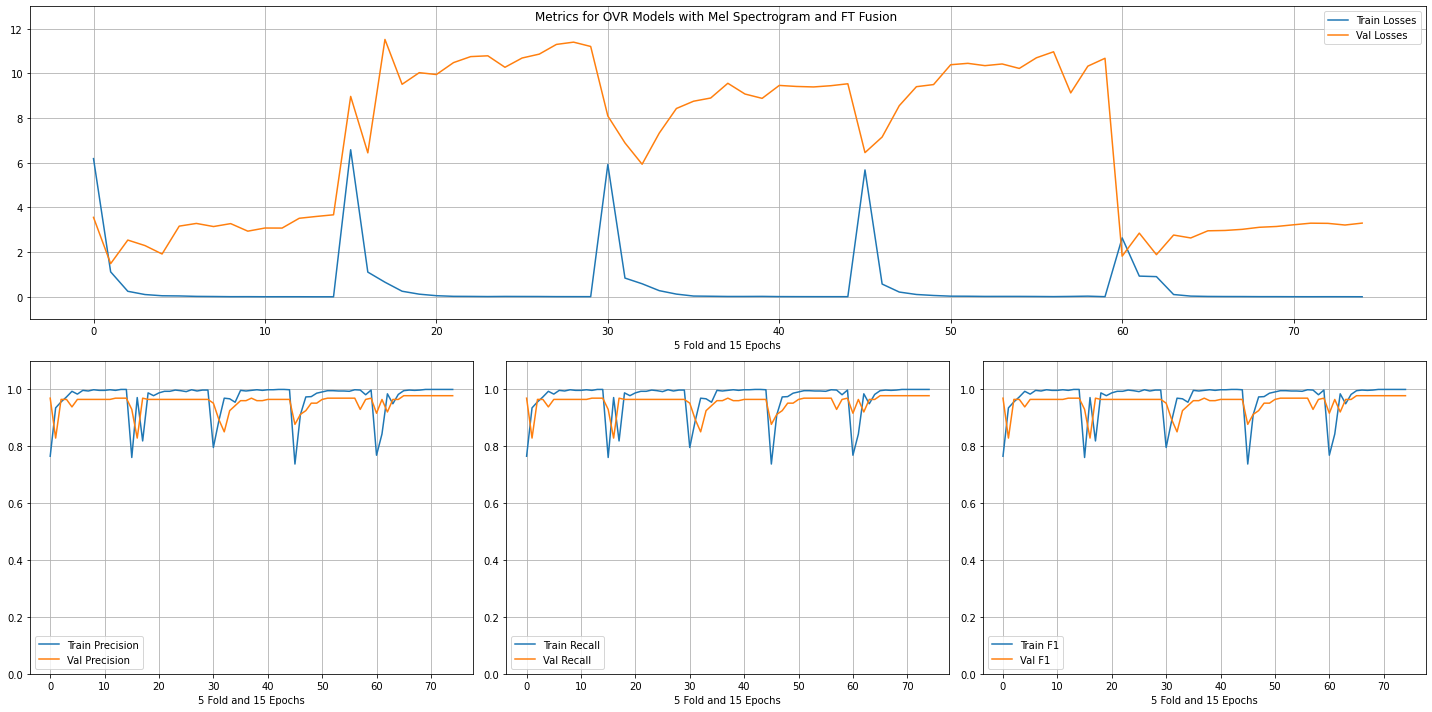

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977974  ...      0.004766           3.301167
9   1.000000       0.977974  ...      0.009348           3.149773
5   0.995614       0.977974  ...      0.018969           2.956498
6   0.997807       0.977974  ...      0.014757           2.971508
8   0.997807       0.977974  ...      0.009616           3.113669
..       ...            ...  ...           ...                ...
1   0.889133       0.894737  ...      0.840512           6.890555
0   0.737651       0.877193  ...      5.680831           6.455712
2   0.969265       0.850877  ...      0.585942           5.935946
1   0.971460       0.828947  ...      1.108196           6.445384
1   0.935236       0.828947  ...      1.119746           1.486185

[75 rows x 8 columns]
Training for ['శంకరాభరణం'] with 68 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53174603 8.375     ]
Epoch 1/15 : Training Loss: 6.078 / Validation Los

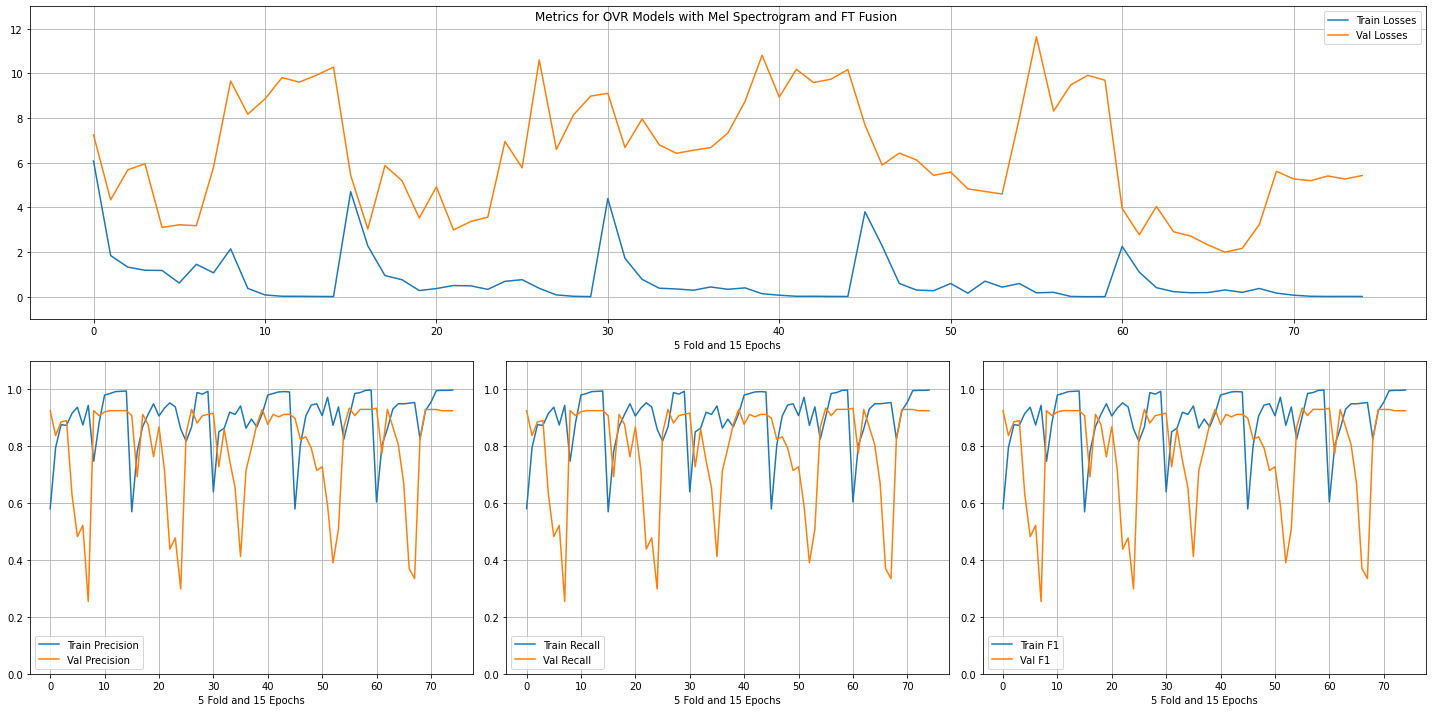

    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.904501       0.934211  ...      0.179502          11.638994
0   0.604167       0.933921  ...      2.257012           3.952352
11  0.868277       0.929825  ...      0.382539          10.604799
12  0.989023       0.929825  ...      0.018378           9.485850
13  0.996707       0.929825  ...      0.007332           9.915744
..       ...            ...  ...           ...                ...
7   0.873765       0.390351  ...      0.703069           4.718689
6   0.951754       0.370044  ...      0.308479           1.999277
7   0.953947       0.334802  ...      0.202004           2.168975
9   0.860593       0.298246  ...      0.694811           6.955680
7   0.944018       0.254386  ...      1.075519           5.799345

[75 rows x 8 columns]
Training for ['శుద్ధవసంతం'] with 33 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51491863 17.25757576]
Epoch 1/15 : Training Loss: 8.415 / Validation 

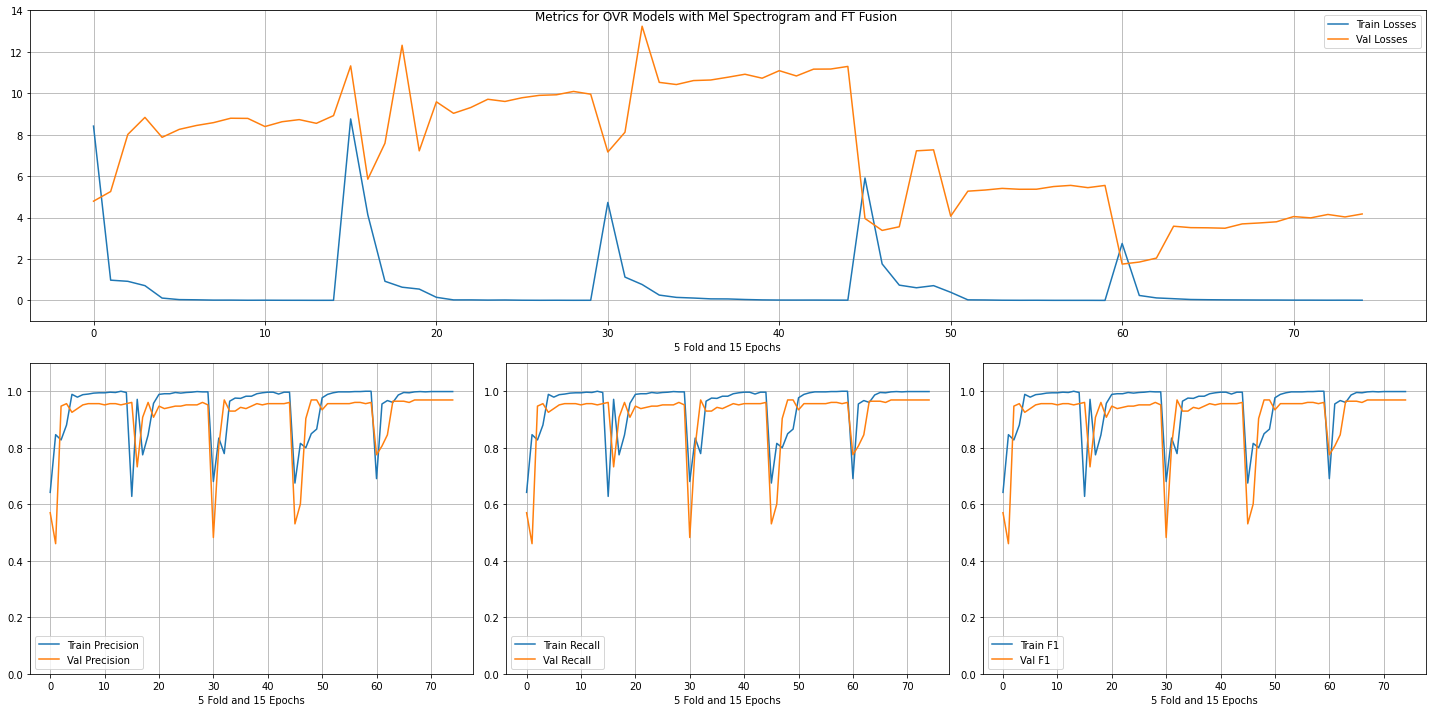

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.866081       0.969298  ...      0.716108           7.269935
2   0.779363       0.969298  ...      0.770774          13.236278
3   0.849616       0.969298  ...      0.613760           7.222848
10  0.998904       0.969163  ...      0.017182           4.049523
7   0.997807       0.969163  ...      0.026071           3.695481
..       ...            ...  ...           ...                ...
1   0.815587       0.600877  ...      1.764661           3.381501
0   0.642151       0.570175  ...      8.415483           4.791756
0   0.675082       0.530702  ...      5.910067           3.957347
0   0.680571       0.482456  ...      4.731314           7.165056
1   0.846323       0.460526  ...      0.980643           5.257968

[75 rows x 8 columns]
Training for ['శ్రీరాగం'] with 65 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53026071 8.76153846]
Epoch 1/15 : Training Loss: 5.829 / Validation Loss

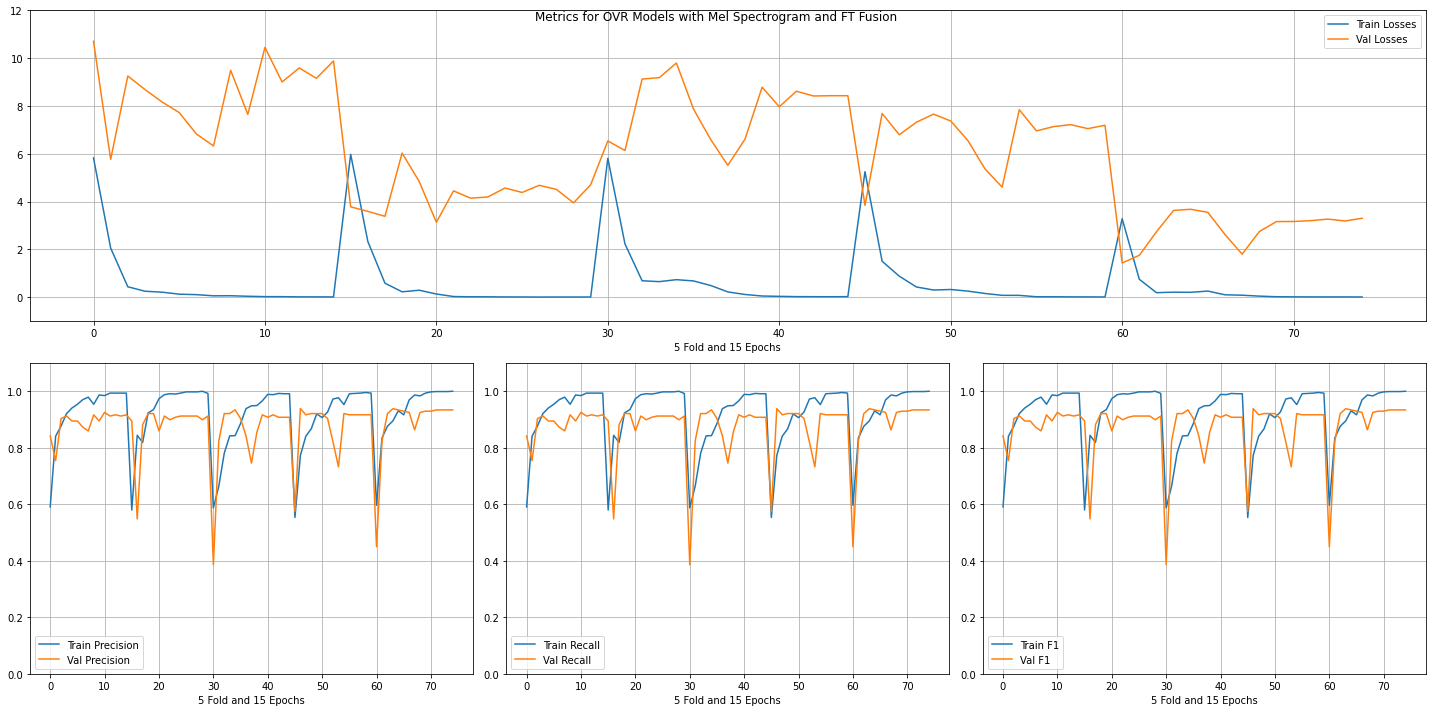

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.772777       0.938596  ...      1.507149           7.687364
3   0.894737       0.938326  ...      0.214033           3.633899
4   0.843030       0.934211  ...      0.737188           9.798976
14  1.000000       0.933921  ...      0.013154           3.305898
13  0.998904       0.933921  ...      0.015375           3.193163
..       ...            ...  ...           ...                ...
8   0.976948       0.732456  ...      0.081903           4.606884
0   0.553238       0.574561  ...      5.253828           3.842008
1   0.844127       0.548246  ...      2.336150           3.594640
0   0.596491       0.449339  ...      3.286965           1.432204
0   0.587267       0.385965  ...      5.812187           6.539298

[75 rows x 8 columns]
Training for ['సామంతం'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54238095 6.3988764 ]
Epoch 1/15 : Training Loss: 5.311 / Validation Loss :

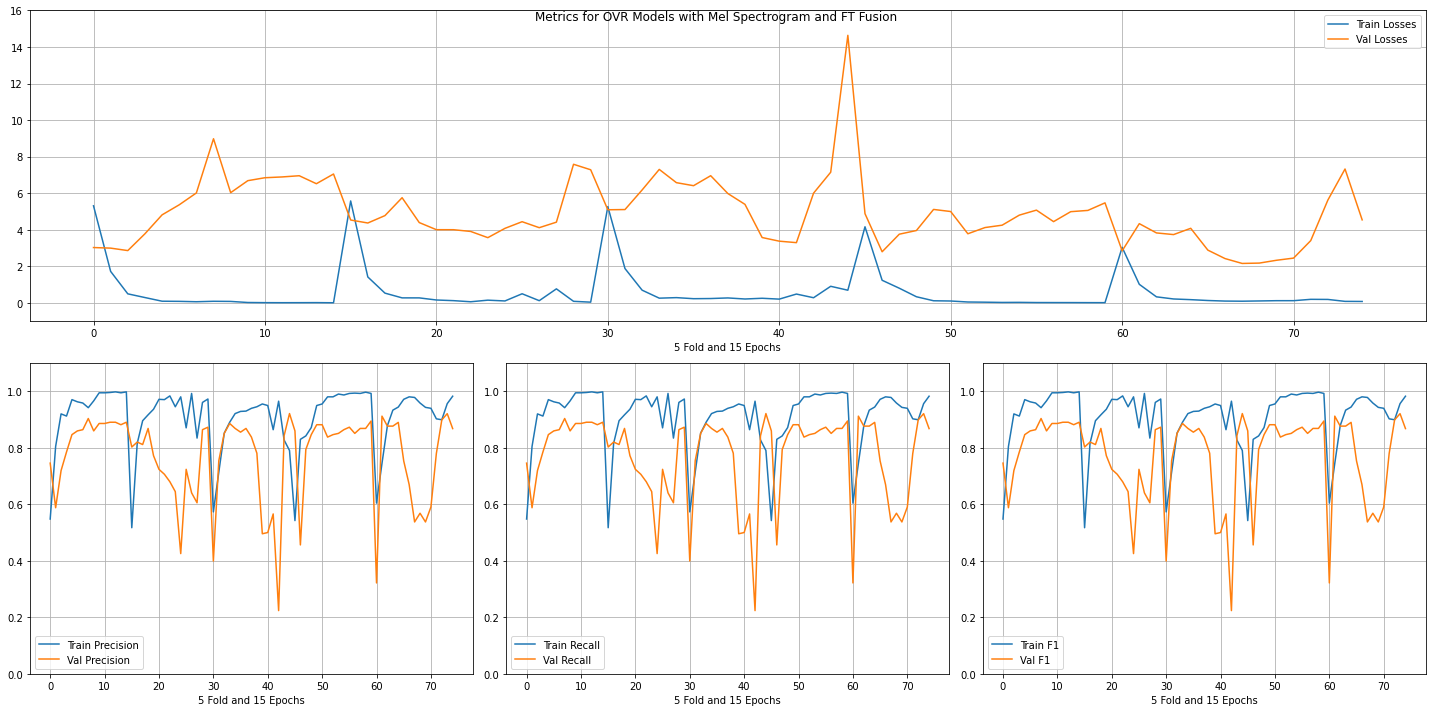

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.790340       0.921053  ...      0.694711          14.636202
13  0.956140       0.920705  ...      0.084565           7.324358
1   0.744518       0.911894  ...      1.017084           4.335601
7   0.941822       0.903509  ...      0.089435           8.979600
12  0.899123       0.898678  ...      0.190366           5.626228
..       ...            ...  ...           ...                ...
1   0.829857       0.456140  ...      1.238556           2.798172
9   0.980241       0.425439  ...      0.107635           4.078692
0   0.572997       0.399123  ...      5.268053           5.094957
0   0.604167       0.321586  ...      3.039104           2.848609
12  0.964874       0.223684  ...      0.283756           6.002662

[75 rows x 8 columns]
Training for ['సాళంగం'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 7.006 / Validation Loss

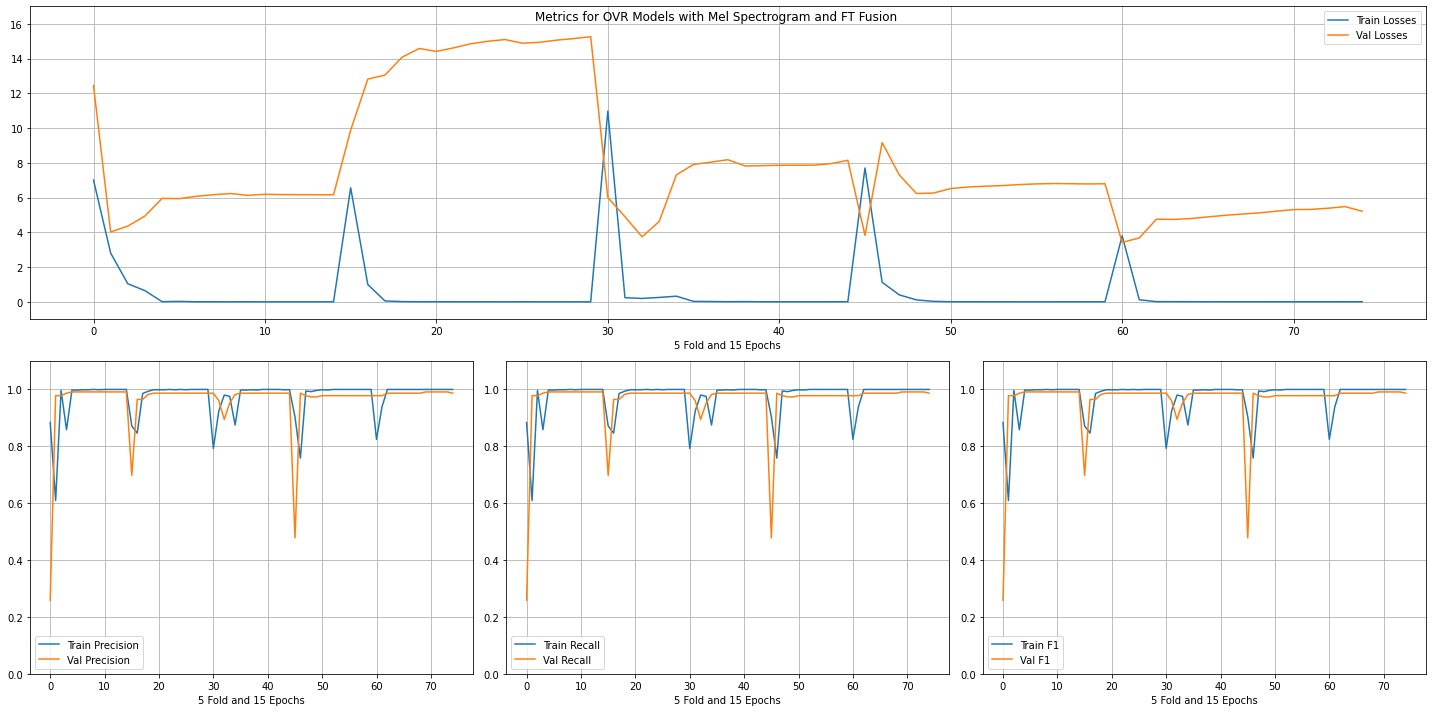

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991228  ...      0.000264           6.156829
7   0.998902       0.991228  ...      0.003381           6.165416
13  1.000000       0.991228  ...      0.000253           6.162884
12  1.000000       0.991228  ...      0.000174           6.166015
11  1.000000       0.991228  ...      0.000704           6.170362
..       ...            ...  ...           ...                ...
3   0.975851       0.951754  ...      0.252517           4.631112
2   0.980241       0.894737  ...      0.194640           3.737528
0   0.871570       0.697368  ...      6.561763           9.877644
0   0.904501       0.478070  ...      7.702910           3.826186
0   0.883644       0.258772  ...      7.005651          12.444699

[75 rows x 8 columns]
Training for ['సాళంగనాట'] with 94 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54497608 6.05851064]
Epoch 1/15 : Training Loss: 6.281 / Validation Loss

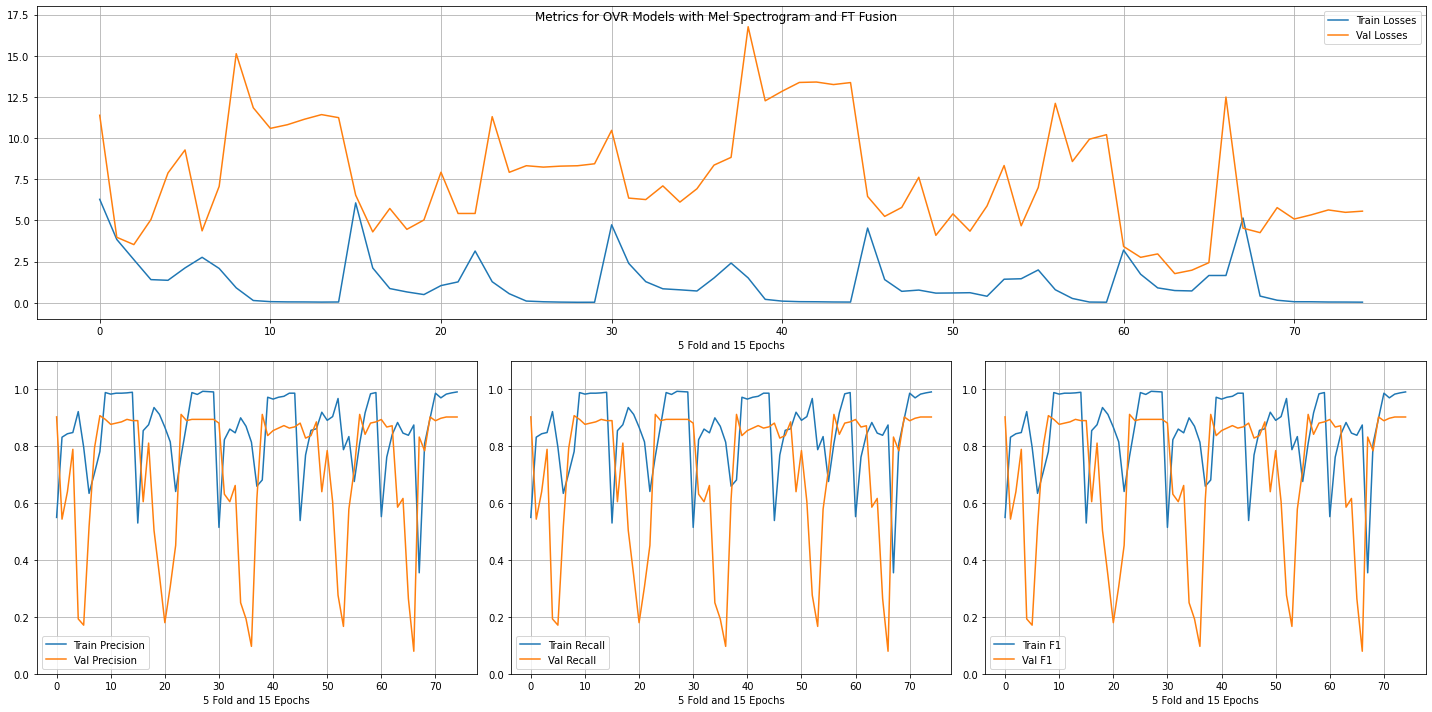

    train_f1  validation_f1  ...  train_losses  validation_losses
11  0.810099       0.912281  ...      0.788642          12.111854
8   0.681668       0.912281  ...      1.507835          16.765753
8   0.765093       0.912281  ...      1.276012          11.302837
8   0.781559       0.907895  ...      0.904361          15.126836
0   0.549945       0.903509  ...      6.281181          11.386809
..       ...            ...  ...           ...                ...
5   0.867179       0.179825  ...      1.042052           7.928306
5   0.796926       0.171053  ...      2.114440           9.280826
8   0.788145       0.166667  ...      1.428279           8.334417
6   0.814490       0.096491  ...      1.505187           8.359667
6   0.875000       0.079295  ...      1.655120          12.493575

[75 rows x 8 columns]


In [27]:
le = LabelEncoder()
le.fit(data['Ragam'])
labels = le.transform(le.classes_)
ovr_res = ovr_train_model(data, MelMatrixDataset, MelRagaFtFusion, "OVR Models with Mel Spectrogram and FT Fusion", 
                          labels, le.classes_, lbl_encoder=le, lr=1e-5, epochs=15, n_folds=5, feature='mel_spec')

In [28]:
for k in ovr_res:
  print(le.inverse_transform([k]))
  print(results_to_df(ovr_res[k]).head())

['ఆహిరి']
    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.996707       0.951754  ...      0.006056           6.498427
3   0.957190       0.951754  ...      0.156362           6.482935
9   0.996707       0.951754  ...      0.008442           6.442134
14  1.000000       0.951542  ...      0.013323           3.751966
13  1.000000       0.951542  ...      0.015549           3.686575

[5 rows x 8 columns]
['కన్నడగౌళ']
    train_f1  validation_f1  ...  train_losses  validation_losses
10  0.998902       0.986842  ...      0.001875           4.098798
6   0.985730       0.986842  ...      0.026475           6.530052
2   0.930845       0.986842  ...      0.271622           6.503728
8   0.971460       0.986842  ...      0.064828           6.569607
9   1.000000       0.986842  ...      0.004935           7.388400

[5 rows x 8 columns]
['కాంబోది']
    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.982456  ...      0.004534           6.8837

# Mapping each Raga with Janaka Ragam

In [29]:
janaka_raga_map ={'లలిత':'Mayamalavagowla',
'సాళంగనాట':'Mayamalavagowla',
'సామంతం':'Naganandini',
'బౌళి':'Mayamalavagowla',
'శంకరాభరణం':'Shankarabharanam',
'శ్రీరాగం':'Kharaharapriya',
'రామక్రియ':'Mayamalavagowla',
'ముఖారి':'Kharaharapriya',
'పాడి':'Mayamalavagowla',
'ఆహిరి':'Vakulabharanam',
'దేసాళం':'Unknown',
'దేవగాంధారి':'Shankarabharanam',
'శుద్ధవసంతం':'Shankarabharanam',
'భూపాలం':'Shubhapantuvarali',
'దేసాక్షి':'Harikambhoji',
'గుండుక్రియ':'Mayamalavagowla',
'భైరవి':'Natabhairavi',
'నాట':'Chalanata',
'వరాళి':'Jhalavarali',
'ధన్నాసి':'Hanumatodi',
'మలహరి':'Mayamalavagowla',
'కాంబోది':'Harikambhoji',
'మాళవిగౌళ':'Mayamalavagowla',
'మాళవి':'Harikambhoji',
'గుజ్జరి':'Unknown',
'కన్నడగౌళ':'Kharaharapriya',
'గౌళ':'Mayamalavagowla',
'బౌళిరామక్రియ':'Mayamalavagowla',
'నాదరామక్రియ':'Unknown',
'సాళంగం':'Kalyani'}

In [30]:
data['janaka_ragam'] = data.apply(lambda x:janaka_raga_map[x['Ragam']],axis=1)

In [31]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

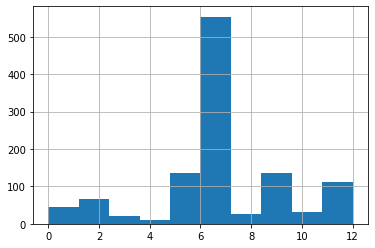

In [32]:
data['JanakaRagamCode'].hist()

In [33]:
class MelJanakaDataset(AbsDataset):
    def __init__(self, labels, mels, txtvecs):
        super().__init__()
        self.labels = labels
        self.mels = mels
        self.txtvecs = txtvecs

    def __get__(self,index):
      if self.mels[index].shape[1] < 9601:
        self.mels[index] = torch.hstack((self.mels[index],torch.zeros(40,9601-self.mels[index].shape[1])))
      return self.mels[index].reshape((1,)+self.mels[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.txtvecs[index], self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.txtvecs[index], self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids, txt_feature='ft_vector'):
      train_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['JanakaRagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['mel_spec'].iloc[x] for x in train_ids]
      test_vals = [data['mel_spec'].iloc[x] for x in test_ids]
      train_txt = [torch.tensor(data[txt_feature].iloc[x]) for x in train_ids]
      test_txt = [torch.tensor(data[txt_feature].iloc[x]) for x in test_ids]
      train_data = MelJanakaDataset(train_lbls, train_vals, train_txt)
      test_data = MelJanakaDataset(test_lbls, test_vals, test_txt)
      return train_data, test_data, train_lbls, test_lbls

In [ ]:
mc = jle.transform(['Unknown'])
data = data[data['JanakaRagamCode']!=mc[0]]


Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 7.040 / Validation Loss : 4.630 [Time Taken : 3.119451 seconds]
Epoch 2/15 : Training Loss: 3.133 / Validation Loss : 1.855 [Time Taken : 3.09068 seconds]
Epoch 3/15 : Training Loss: 0.395 / Validation Loss : 3.522 [Time Taken : 3.066614 seconds]
Epoch 4/15 : Training Loss: 0.469 / Validation Loss : 2.115 [Time Taken : 3.072958 seconds]
Epoch 5/15 : Training Loss: 0.181 / Validation Loss : 8.881 [Time Taken : 3.095972 seconds]
Epoch 6/15 : Training Loss: 0.213 / Validation Loss : 5.533 [Time Taken : 3.067328 seconds]
Epoch 7/15 : Training Loss: 0.011 / Validation Loss : 6.135 [Time Taken : 3.0949 seconds]
Epoch 8/15 : Training Loss: 0.006 / Validation Loss : 6.622 [Time Taken : 3.099664 seconds]
Epoch 9/15 : Training Loss: 0.007 / Validation Loss : 6.897 [Time Taken : 3.109126 seconds]
Epoch 10/15 : Training Loss: 0.007 / V

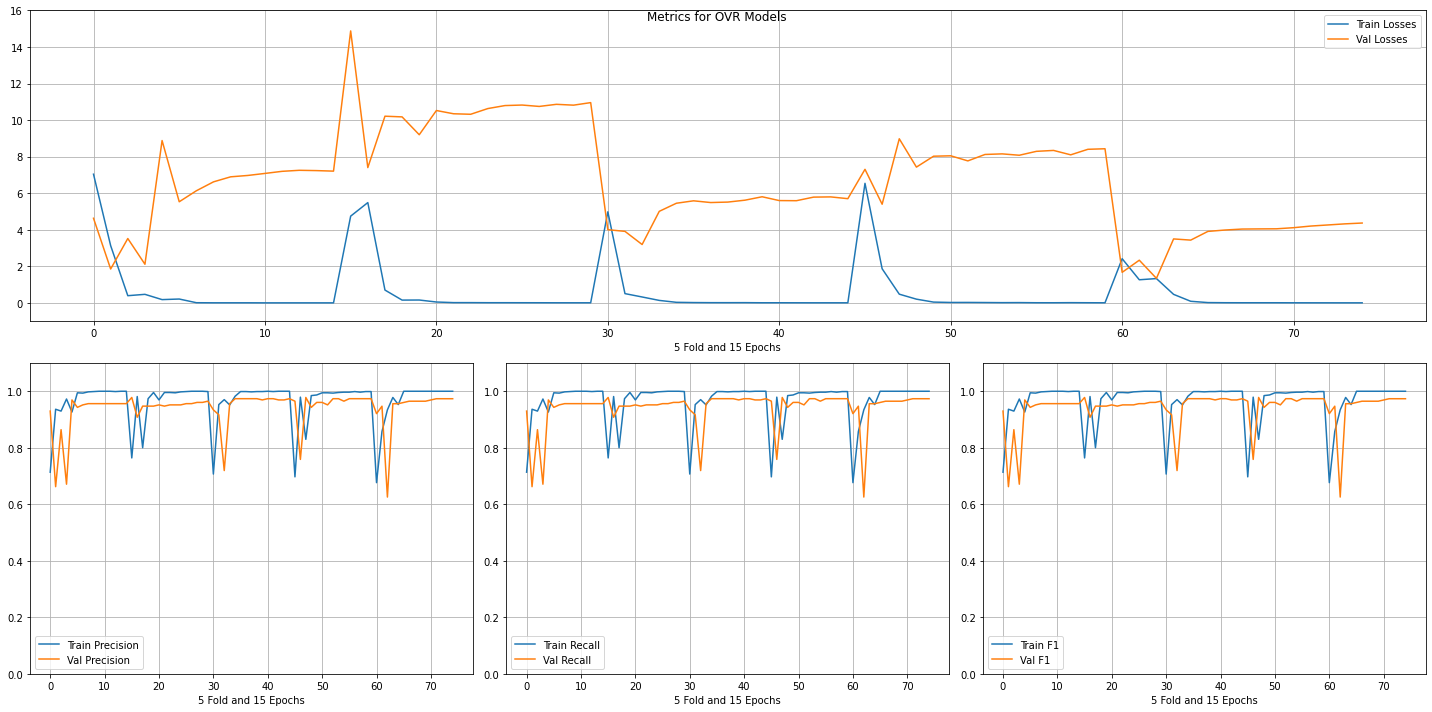

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.763996       0.978070  ...      4.746977          14.877477
2   0.829857       0.978070  ...      0.478148           8.977792
7   0.997805       0.973684  ...      0.013472           5.515567
4   0.982437       0.973684  ...      0.032849           5.452401
6   0.998902       0.973684  ...      0.014078           5.490237
..       ...            ...  ...           ...                ...
1   0.979144       0.758772  ...      1.868180           5.397812
2   0.970362       0.719298  ...      0.324952           3.194606
3   0.972558       0.671053  ...      0.469349           2.115108
1   0.936334       0.662281  ...      3.133039           1.855222
2   0.934211       0.625551  ...      1.331484           1.342868

[75 rows x 8 columns]
Training for ['Hanumatodi'] with 20 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50893655 28.475     ]
Epoch 1/15 : Training Loss: 9.891 / Validation 

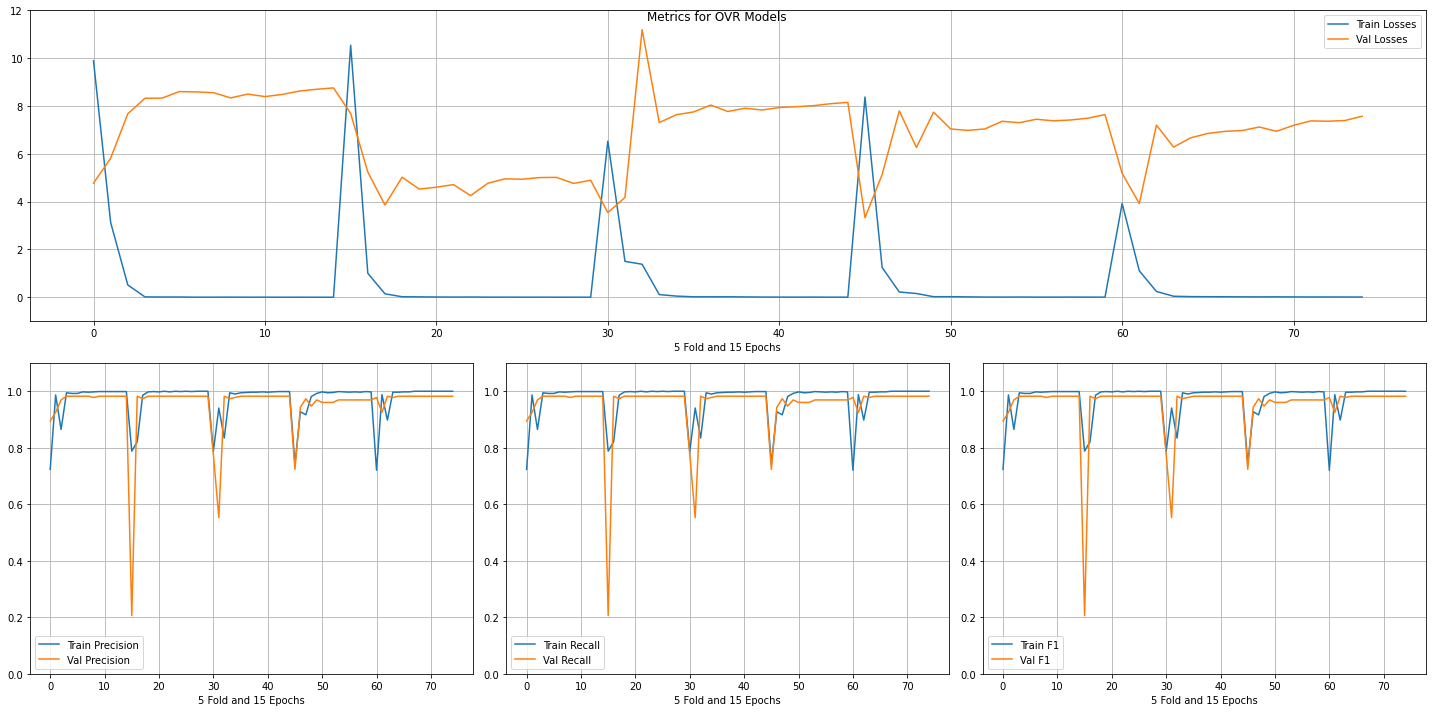

    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.996707       0.982456  ...      0.020837           7.771541
5   0.997805       0.982456  ...      0.012105           4.605406
7   0.997805       0.982456  ...      0.011868           4.251892
9   0.998902       0.982456  ...      0.007182           4.955363
10  1.000000       0.982456  ...      0.004890           4.938381
..       ...            ...  ...           ...                ...
0   0.723381       0.894737  ...      9.890799           4.772108
0   0.787047       0.776316  ...      6.532997           3.543186
0   0.740944       0.723684  ...      8.376214           3.329311
1   0.940724       0.552632  ...      1.503460           4.174637
0   0.788145       0.206140  ...     10.542054           7.687393

[75 rows x 8 columns]
Training for ['Harikambhoji'] with 66 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53075489 8.62878788]
Epoch 1/15 : Training Loss: 8.312 / Validation 

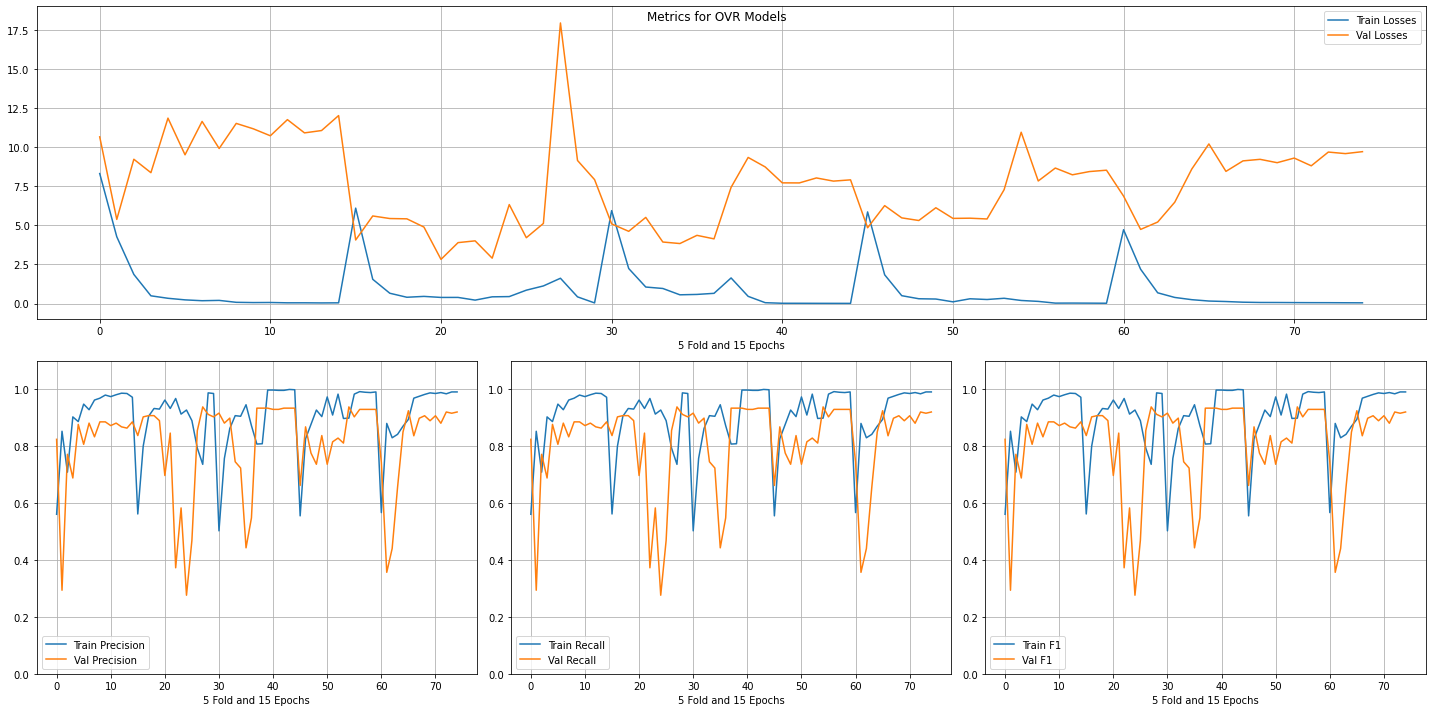

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.736553       0.938596  ...      1.617938          17.941024
9   0.899012       0.938596  ...      0.197239          10.954605
7   0.807903       0.934211  ...      1.637612           7.430973
14  0.998902       0.934211  ...      0.011822           7.909992
13  1.000000       0.934211  ...      0.013092           7.828922
..       ...            ...  ...           ...                ...
2   0.830044       0.440529  ...      0.687436           5.212181
7   0.968167       0.372807  ...      0.220039           4.009384
1   0.880482       0.356828  ...      2.193932           4.740990
1   0.852909       0.293860  ...      4.271207           5.380814
9   0.927552       0.276316  ...      0.445689           6.328987

[75 rows x 8 columns]
Training for ['Jhalavarali'] with 22 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50984781 25.88636364]
Epoch 1/15 : Training Loss: 6.187 / Validation

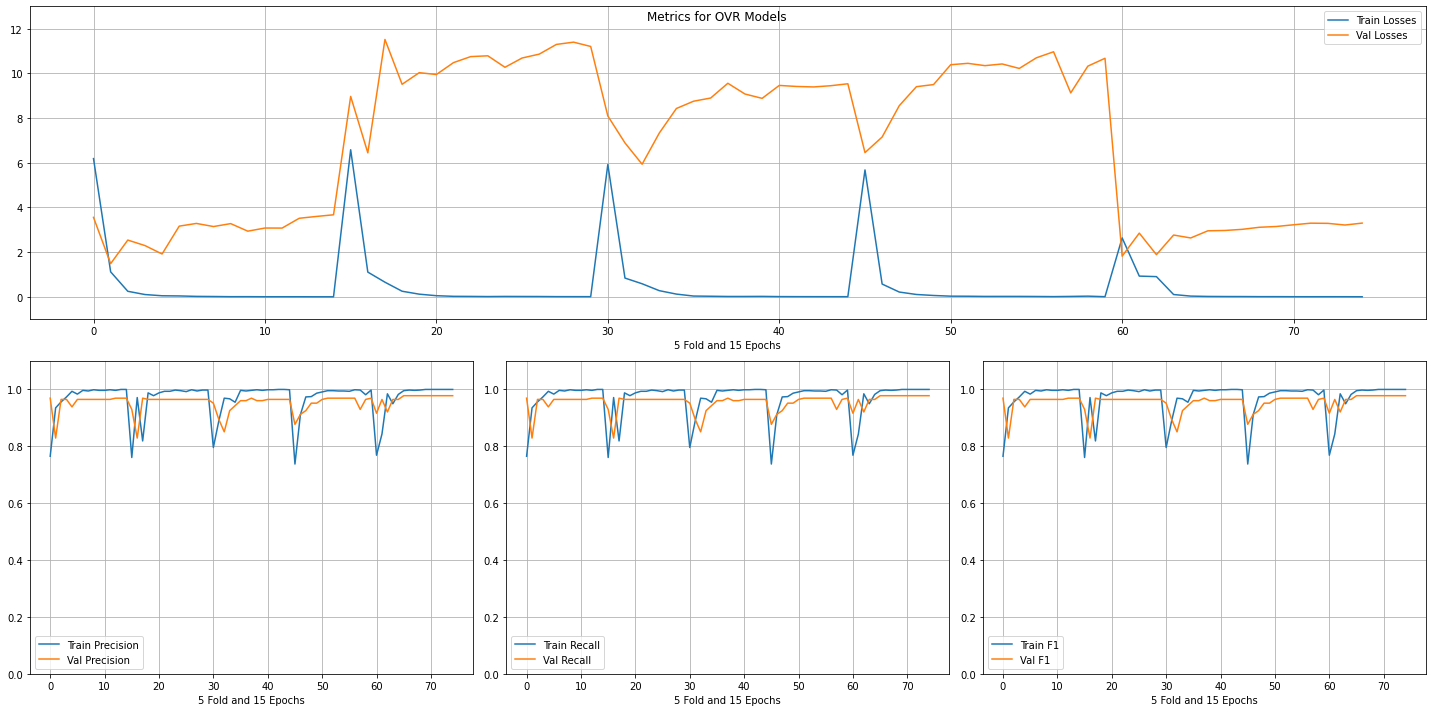

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977974  ...      0.004766           3.301167
9   1.000000       0.977974  ...      0.009348           3.149773
5   0.995614       0.977974  ...      0.018969           2.956498
6   0.997807       0.977974  ...      0.014757           2.971508
8   0.997807       0.977974  ...      0.009616           3.113668
..       ...            ...  ...           ...                ...
1   0.889133       0.894737  ...      0.840512           6.890555
0   0.737651       0.877193  ...      5.680832           6.455712
2   0.969265       0.850877  ...      0.585942           5.935945
1   0.971460       0.828947  ...      1.108196           6.445383
1   0.935236       0.828947  ...      1.119746           1.486185

[75 rows x 8 columns]
Training for ['Kalyani'] with 11 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.50487589 51.77272727]
Epoch 1/15 : Training Loss: 7.006 / Validation Los

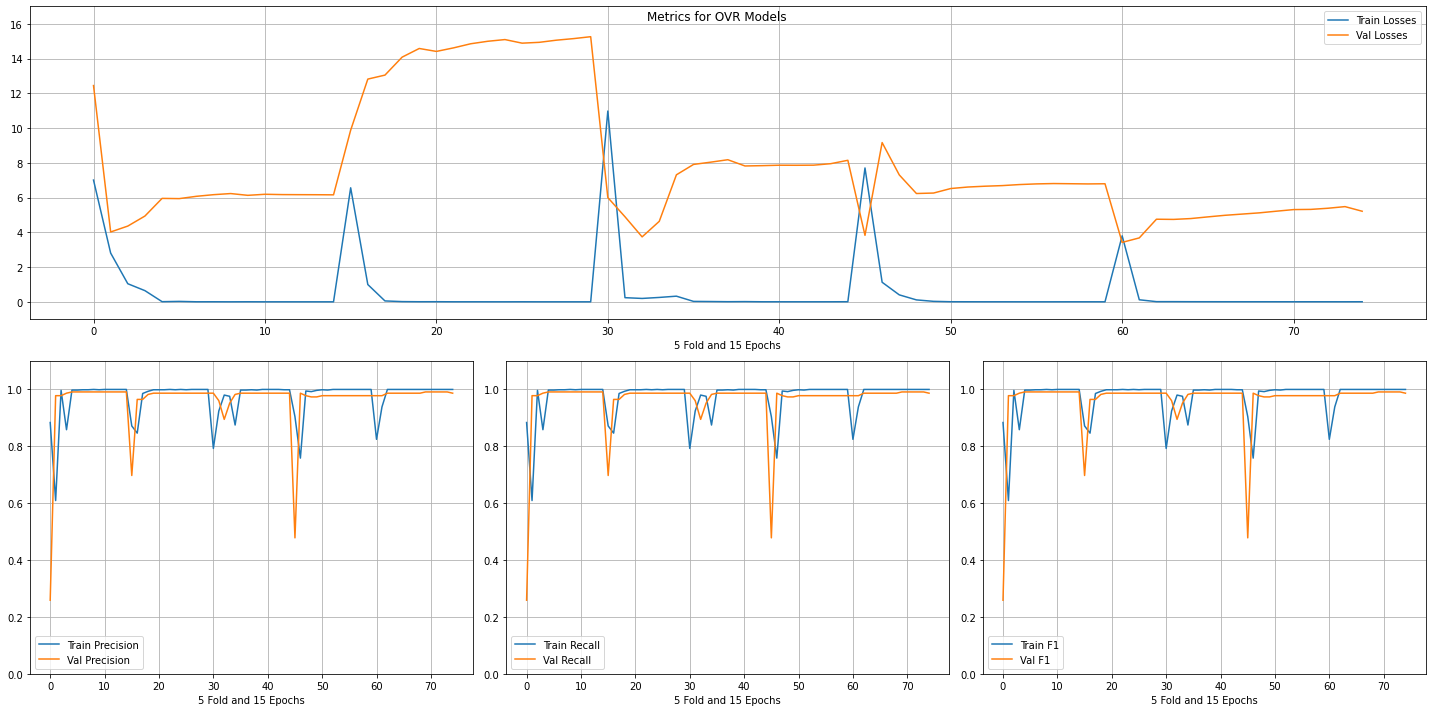

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991228  ...      0.000264           6.156829
7   0.998902       0.991228  ...      0.003381           6.165416
13  1.000000       0.991228  ...      0.000253           6.162884
12  1.000000       0.991228  ...      0.000174           6.166015
11  1.000000       0.991228  ...      0.000704           6.170362
..       ...            ...  ...           ...                ...
3   0.975851       0.951754  ...      0.252516           4.631111
2   0.980241       0.894737  ...      0.194640           3.737528
0   0.871570       0.697368  ...      6.561763           9.877644
0   0.904501       0.478070  ...      7.702910           3.826186
0   0.883644       0.258772  ...      7.005651          12.444698

[75 rows x 8 columns]
Training for ['Kharaharapriya'] with 135 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.56723108 4.21851852]
Epoch 1/15 : Training Loss: 6.636 / Validati

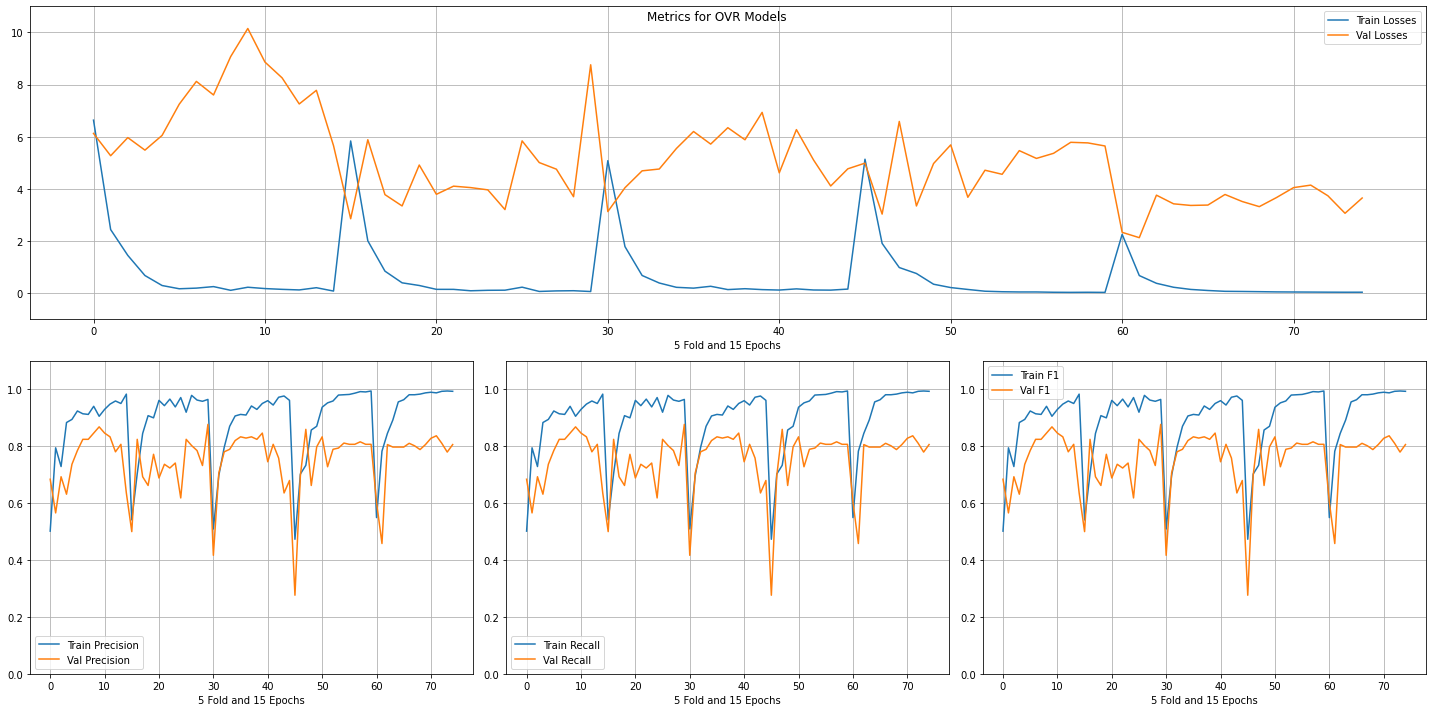

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.964874       0.877193  ...      0.061677           8.760580
9   0.905598       0.868421  ...      0.226252          10.152991
2   0.733260       0.859649  ...      0.981762           6.586555
10  0.929748       0.846491  ...      0.174881           8.864802
9   0.950604       0.846491  ...      0.135079           6.934123
..       ...            ...  ...           ...                ...
1   0.794731       0.565789  ...      2.438028           5.270950
0   0.541164       0.500000  ...      5.837918           2.854060
1   0.782895       0.458150  ...      0.673652           2.127746
0   0.509330       0.416667  ...      5.081797           3.128925
0   0.473106       0.276316  ...      5.137466           4.987033

[75 rows x 8 columns]
Training for ['Mayamalavagowla'] with 465 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.84495549 1.22473118]
Epoch 1/15 : Training Loss: 5.135 / Validat

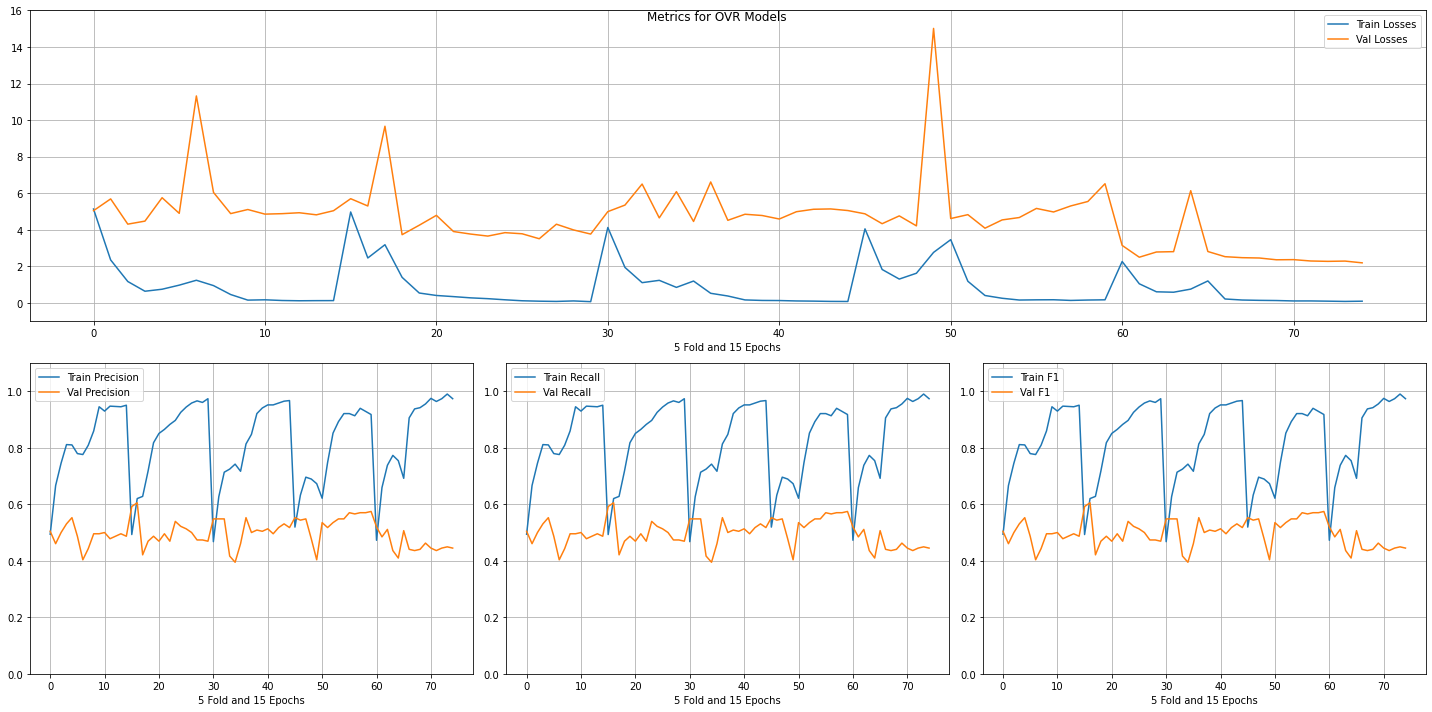

    train_f1  validation_f1  ...  train_losses  validation_losses
1   0.620198       0.605263  ...      2.458470           5.301830
0   0.492865       0.592105  ...      4.973969           5.700206
14  0.917673       0.574561  ...      0.169892           6.519813
13  0.928650       0.570175  ...      0.158092           5.548053
12  0.939627       0.570175  ...      0.136432           5.304444
..       ...            ...  ...           ...                ...
3   0.724479       0.416667  ...      1.234846           4.650556
4   0.754386       0.409692  ...      0.755299           6.138821
4   0.672887       0.403509  ...      2.763107          15.014328
6   0.776070       0.403509  ...      1.239791          11.320835
4   0.742042       0.394737  ...      0.850016           6.086087

[75 rows x 8 columns]
Training for ['Naganandini'] with 89 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.54238095 6.3988764 ]
Epoch 1/15 : Training Loss: 5.311 / Validation L

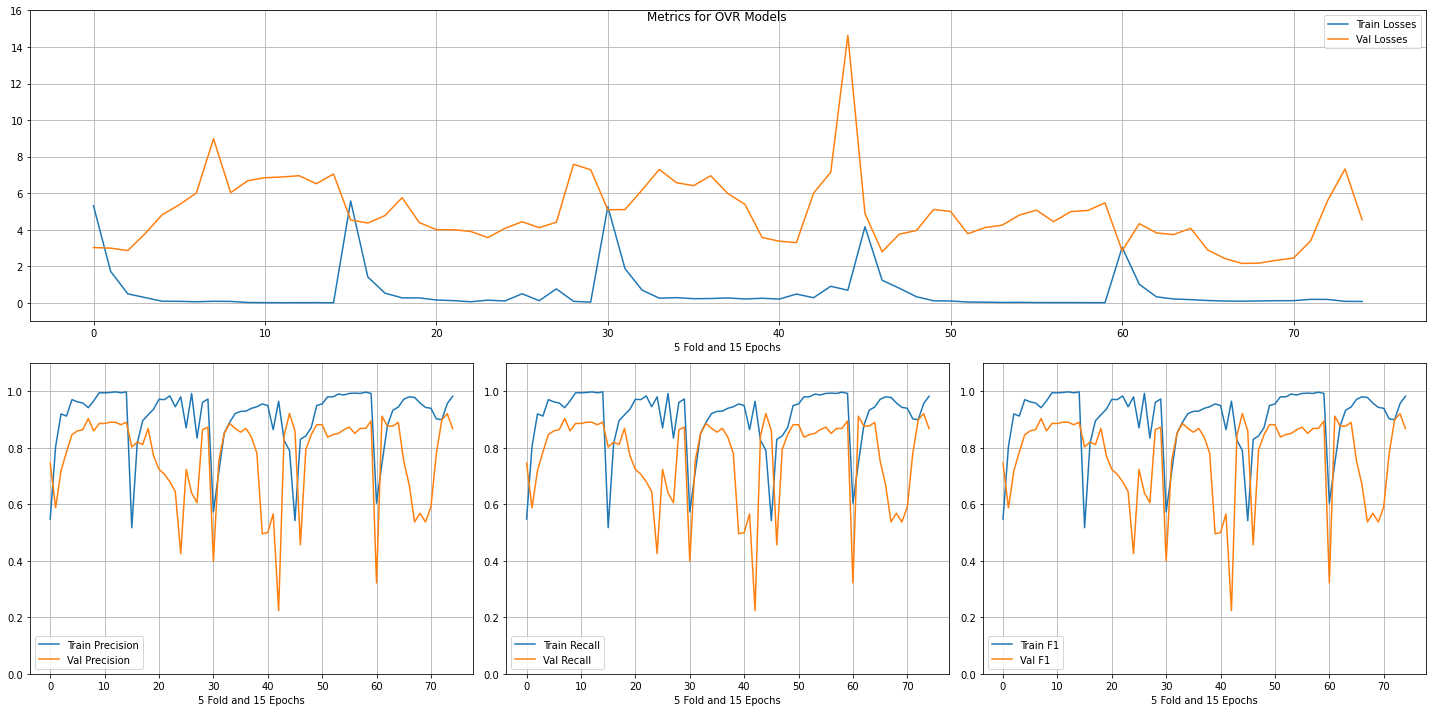

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.790340       0.921053  ...      0.694702          14.636158
13  0.956140       0.920705  ...      0.084558           7.324501
1   0.744518       0.911894  ...      1.017084           4.335601
7   0.941822       0.903509  ...      0.089460           8.979162
12  0.899123       0.898678  ...      0.190374           5.625930
..       ...            ...  ...           ...                ...
1   0.829857       0.456140  ...      1.238556           2.798173
9   0.980241       0.425439  ...      0.107635           4.078694
0   0.572997       0.399123  ...      5.268053           5.094958
0   0.604167       0.321586  ...      3.039104           2.848610
12  0.964874       0.223684  ...      0.283752           6.002589

[75 rows x 8 columns]
Training for ['Natabhairavi'] with 27 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51214029 21.09259259]
Epoch 1/15 : Training Loss: 7.358 / Validatio

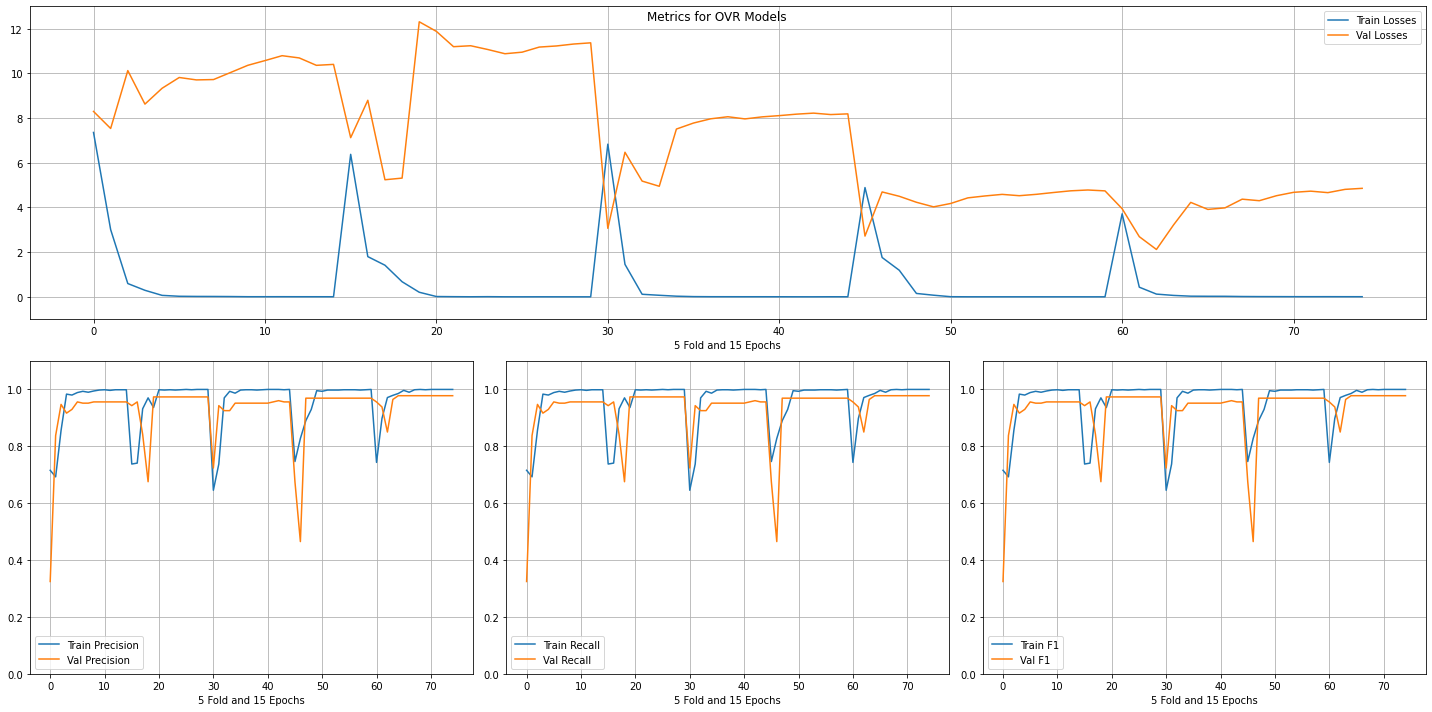

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.977974  ...      0.006919           4.857157
13  1.000000       0.977974  ...      0.007237           4.810803
12  1.000000       0.977974  ...      0.008539           4.664623
11  1.000000       0.977974  ...      0.007891           4.730622
4   0.985746       0.977974  ...      0.030307           4.228002
..       ...            ...  ...           ...                ...
0   0.645445       0.723684  ...      6.834533           3.066893
3   0.970362       0.675439  ...      0.676937           5.315063
0   0.746432       0.675439  ...      4.891164           2.719991
1   0.827662       0.464912  ...      1.761496           4.695592
0   0.715697       0.324561  ...      7.357871           8.299141

[75 rows x 8 columns]
Training for ['Shankarabharanam'] with 136 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.56779661 4.1875    ]
Epoch 1/15 : Training Loss: 5.934 / Valida

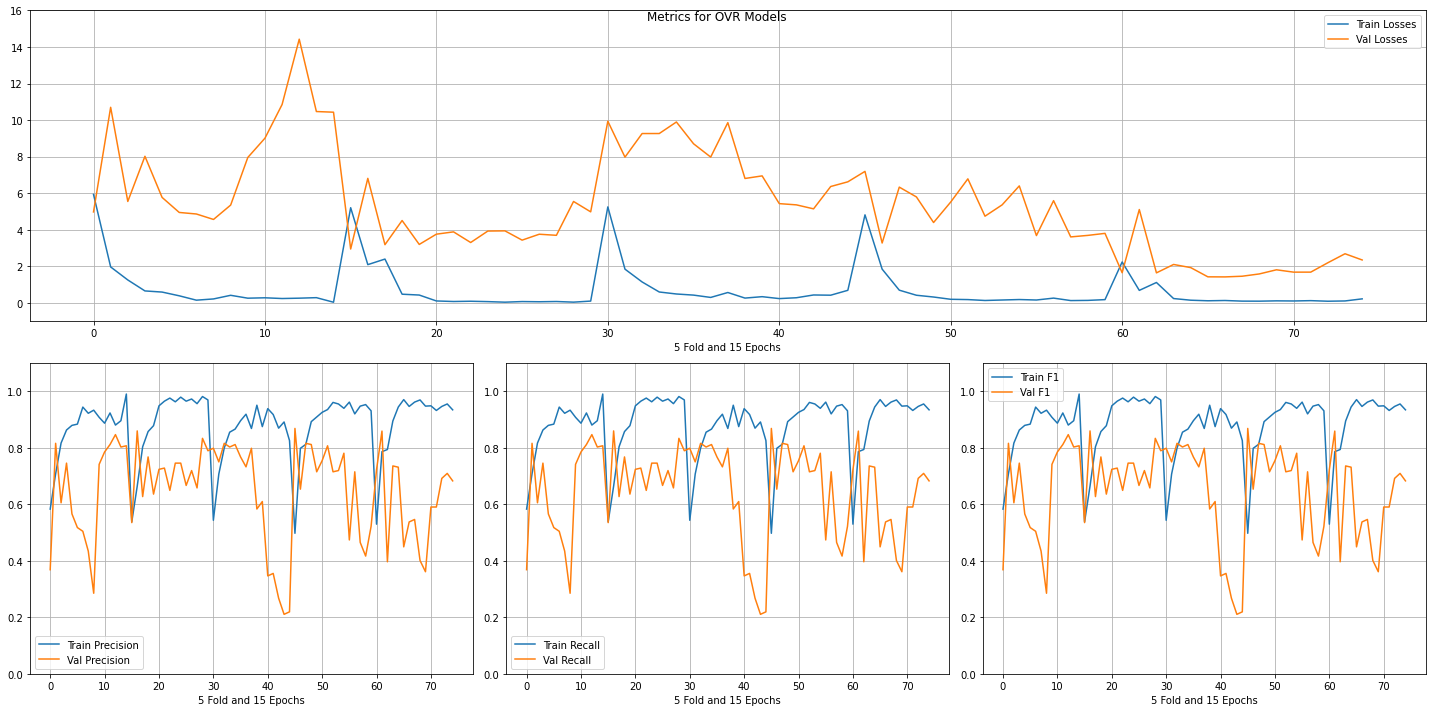

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.497256       0.868421  ...      4.817213           7.195011
1   0.664105       0.859649  ...      2.093851           6.813238
1   0.786184       0.859031  ...      0.685616           5.107489
12  0.880351       0.846491  ...      0.259372          14.425244
13  0.981339       0.833333  ...      0.042392           5.549121
..       ...            ...  ...           ...                ...
10  0.938529       0.346491  ...      0.236228           5.430855
8   0.933041       0.285088  ...      0.416655           5.351856
12  0.869374       0.267544  ...      0.434347           5.145724
14  0.825467       0.219298  ...      0.689818           6.624079
13  0.891328       0.210526  ...      0.422347           6.366747

[75 rows x 8 columns]
Training for ['Shubhapantuvarali'] with 32 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.51445348 17.796875  ]
Epoch 1/15 : Training Loss: 10.290 / Val

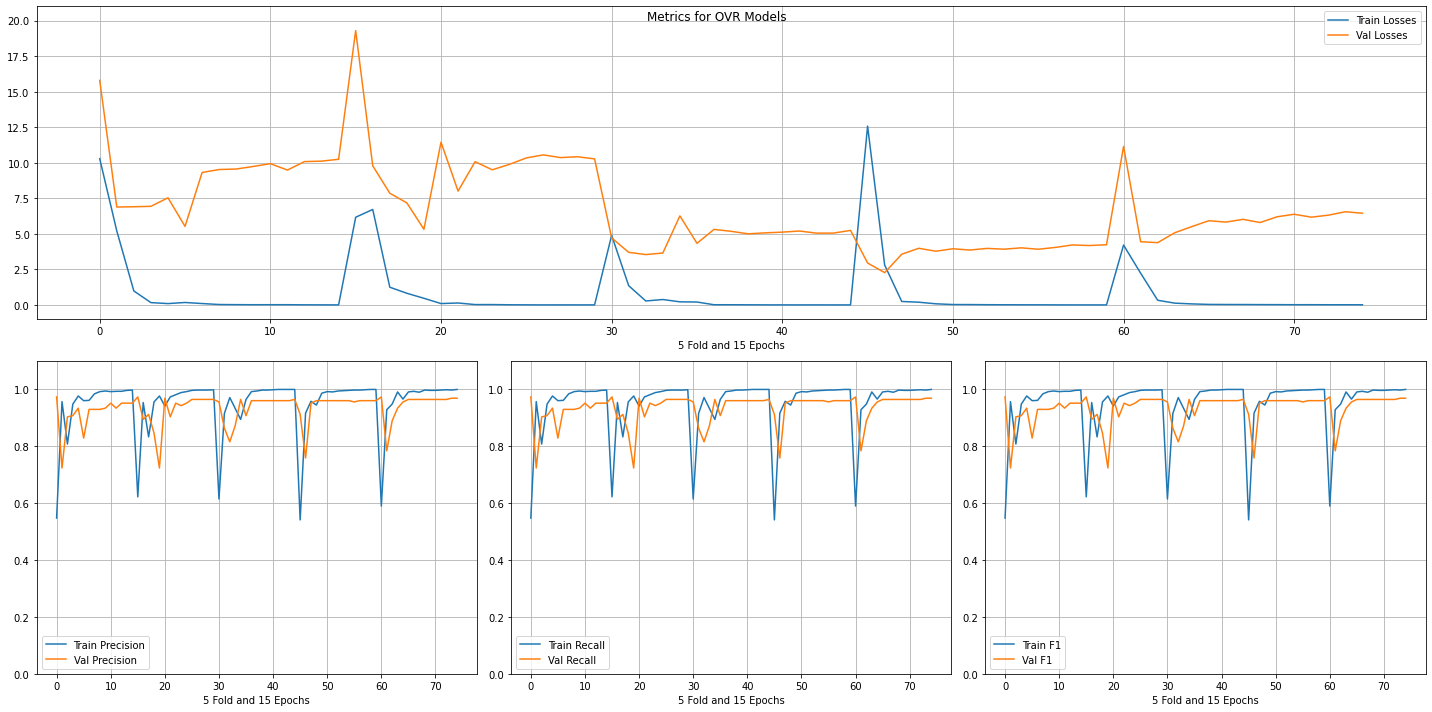

    train_f1  validation_f1  ...  train_losses  validation_losses
0   0.547750       0.973684  ...     10.289697          15.795923
0   0.622393       0.973684  ...      6.170392          19.298894
0   0.589912       0.973568  ...      4.213820          11.147807
5   0.941822       0.969298  ...      0.099622          11.452212
13  0.997807       0.969163  ...      0.016305           6.558315
..       ...            ...  ...           ...                ...
2   0.971460       0.815789  ...      0.282370           3.545362
1   0.928728       0.784141  ...      2.237924           4.447456
1   0.916575       0.758772  ...      2.806454           2.274994
4   0.976948       0.723684  ...      0.470827           5.324236
1   0.957190       0.723684  ...      5.210563           6.888749

[75 rows x 8 columns]
Training for ['Unknown'] with 66 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [0.53075489 8.62878788]
Epoch 1/15 : Training Loss: 6.417 / Validation Loss 

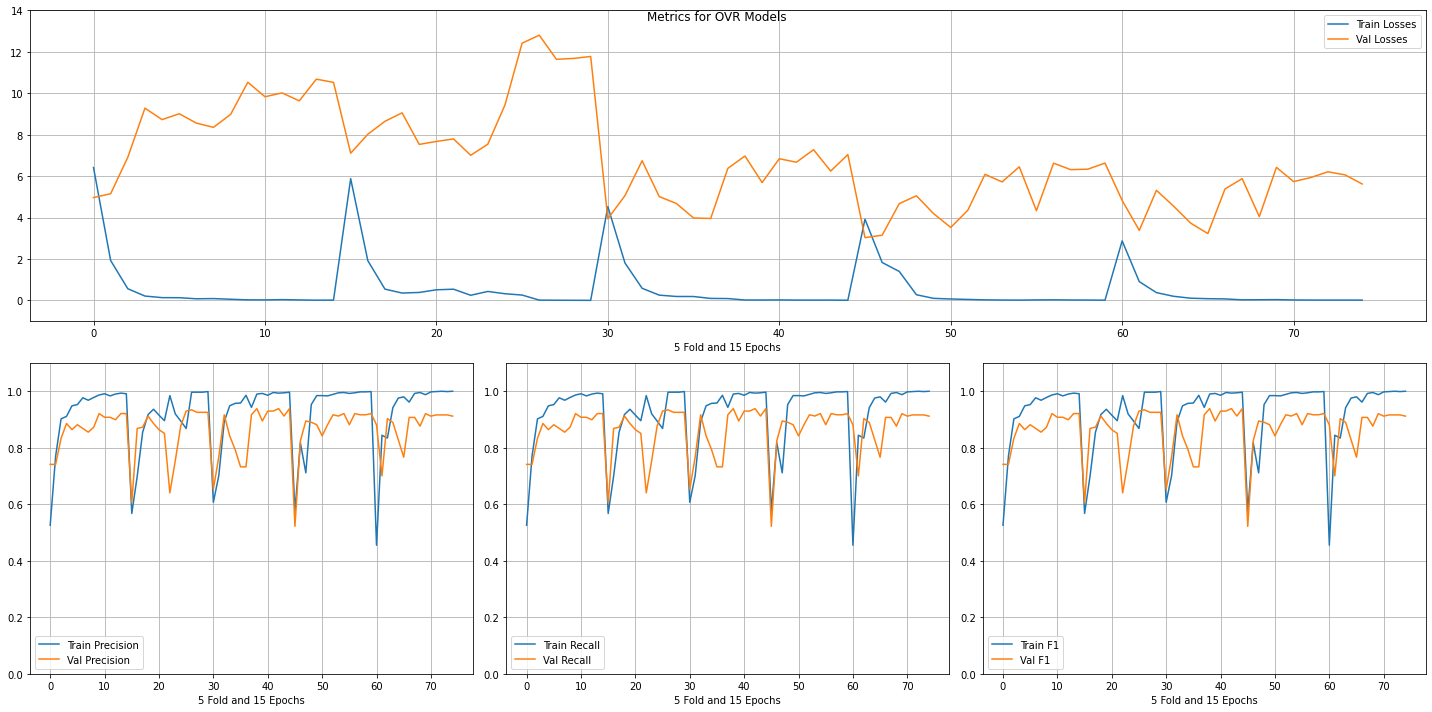

    train_f1  validation_f1  ...  train_losses  validation_losses
8   0.990121       0.938596  ...      0.022541           6.973814
12  0.993414       0.938596  ...      0.017695           7.275853
14  0.996707       0.938596  ...      0.011541           7.041553
11  0.996707       0.934211  ...      0.018081          12.803748
10  0.868277       0.929825  ...      0.261700          12.418413
..       ...            ...  ...           ...                ...
1   0.844298       0.700441  ...      0.908028           3.382177
0   0.607025       0.653509  ...      4.531185           3.944757
7   0.984632       0.640351  ...      0.251238           7.006879
0   0.567508       0.605263  ...      5.880031           7.108952
0   0.575192       0.521930  ...      3.921541           3.033612

[75 rows x 8 columns]
Training for ['Vakulabharanam'] with 45 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 911/228
Class Weights : [ 0.52056673 12.65555556]
Epoch 1/15 : Training Loss: 7.542 / Validat

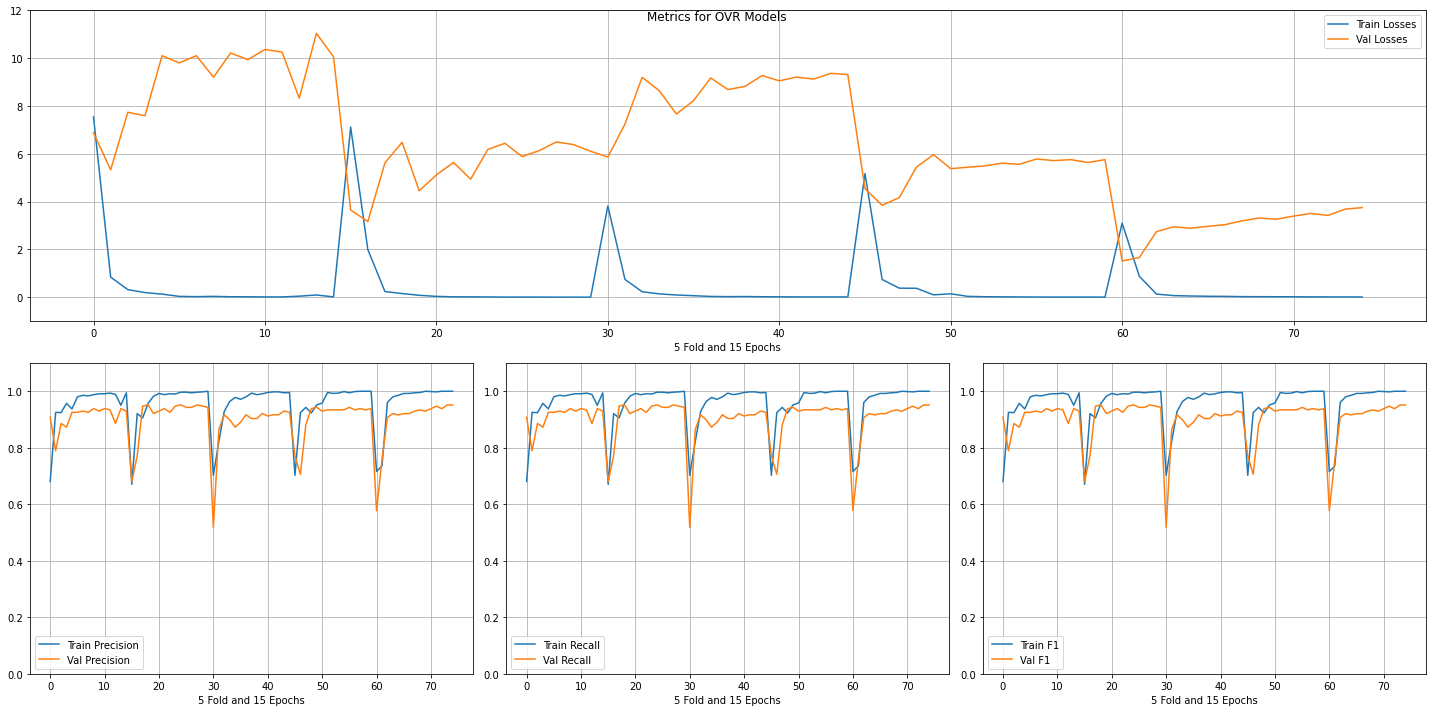

    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.996707       0.951754  ...      0.006056           6.498428
3   0.957190       0.951754  ...      0.156362           6.482935
9   0.996707       0.951754  ...      0.008442           6.442137
14  1.000000       0.951542  ...      0.013323           3.751966
13  1.000000       0.951542  ...      0.015549           3.686575
..       ...            ...  ...           ...                ...
1   0.735746       0.757709  ...      0.880946           1.662142
1   0.924259       0.706140  ...      0.745435           3.848581
0   0.670692       0.679825  ...      7.118155           3.651776
0   0.716009       0.577093  ...      3.107737           1.517403
0   0.702525       0.517544  ...      3.818363           5.864527

[75 rows x 8 columns]


In [34]:
jle = LabelEncoder()
jle.fit(data['janaka_ragam'])
data['JanakaRagamCode'] = data.apply(lambda x:jle.transform([x.janaka_ragam])[0],axis=1)
labels = jle.transform(jle.classes_)
n_labels = len(data['JanakaRagamCode'].unique())

jovr_res = ovr_train_model(data, MelJanakaDataset, MelRagaFtFusion, "OVR Models", labels, 
                           jle.classes_, lbl_encoder=jle, target='JanakaRagamCode', lr=1e-5, epochs=15, n_folds=5, 
                           feature='mel_spec')

In [35]:
for k in jovr_res:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res[k]).head())

['Chalanata']
   train_f1  validation_f1  ...  train_losses  validation_losses
0  0.763996       0.978070  ...      4.746977          14.877477
2  0.829857       0.978070  ...      0.478148           8.977792
7  0.997805       0.973684  ...      0.013472           5.515567
4  0.982437       0.973684  ...      0.032849           5.452401
6  0.998902       0.973684  ...      0.014078           5.490237

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
7   0.996707       0.982456  ...      0.020837           7.771541
5   0.997805       0.982456  ...      0.012105           4.605406
7   0.997805       0.982456  ...      0.011868           4.251892
9   0.998902       0.982456  ...      0.007182           4.955363
10  1.000000       0.982456  ...      0.004890           4.938381

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
12  0.736553       0.938596  ...      1.617938          17

# OVR Experiment without Mayamalavagowla Raga

In [36]:
cl = jle.classes_
mc = jle.transform(['Mayamalavagowla'])
rdata = data[data['JanakaRagamCode']!=mc[0]]
cl = [x for x in cl if not x in ['Mayamalavagowla','Unknown'] ]
jlabels1 = jle.transform(cl)

Training for ['Chalanata'] with 25 positive samples
FOLD 1 
 Data Sizes (Train/Test) : 569/570
Class Weights : [ 0.51122083 22.78      ]
Epoch 1/15 : Training Loss: 8.356 / Validation Loss : 12.961 [Time Taken : 2.667217 seconds]
Epoch 2/15 : Training Loss: 6.014 / Validation Loss : 14.737 [Time Taken : 2.636814 seconds]
Epoch 3/15 : Training Loss: 1.261 / Validation Loss : 6.902 [Time Taken : 2.656793 seconds]
Epoch 4/15 : Training Loss: 0.480 / Validation Loss : 8.533 [Time Taken : 2.61316 seconds]
Epoch 5/15 : Training Loss: 0.100 / Validation Loss : 9.138 [Time Taken : 2.65089 seconds]
Epoch 6/15 : Training Loss: 0.060 / Validation Loss : 9.757 [Time Taken : 2.628992 seconds]
Epoch 7/15 : Training Loss: 0.032 / Validation Loss : 9.942 [Time Taken : 2.630563 seconds]
Epoch 8/15 : Training Loss: 0.029 / Validation Loss : 9.822 [Time Taken : 2.645402 seconds]
Epoch 9/15 : Training Loss: 0.028 / Validation Loss : 10.029 [Time Taken : 2.638847 seconds]
Epoch 10/15 : Training Loss: 0.019

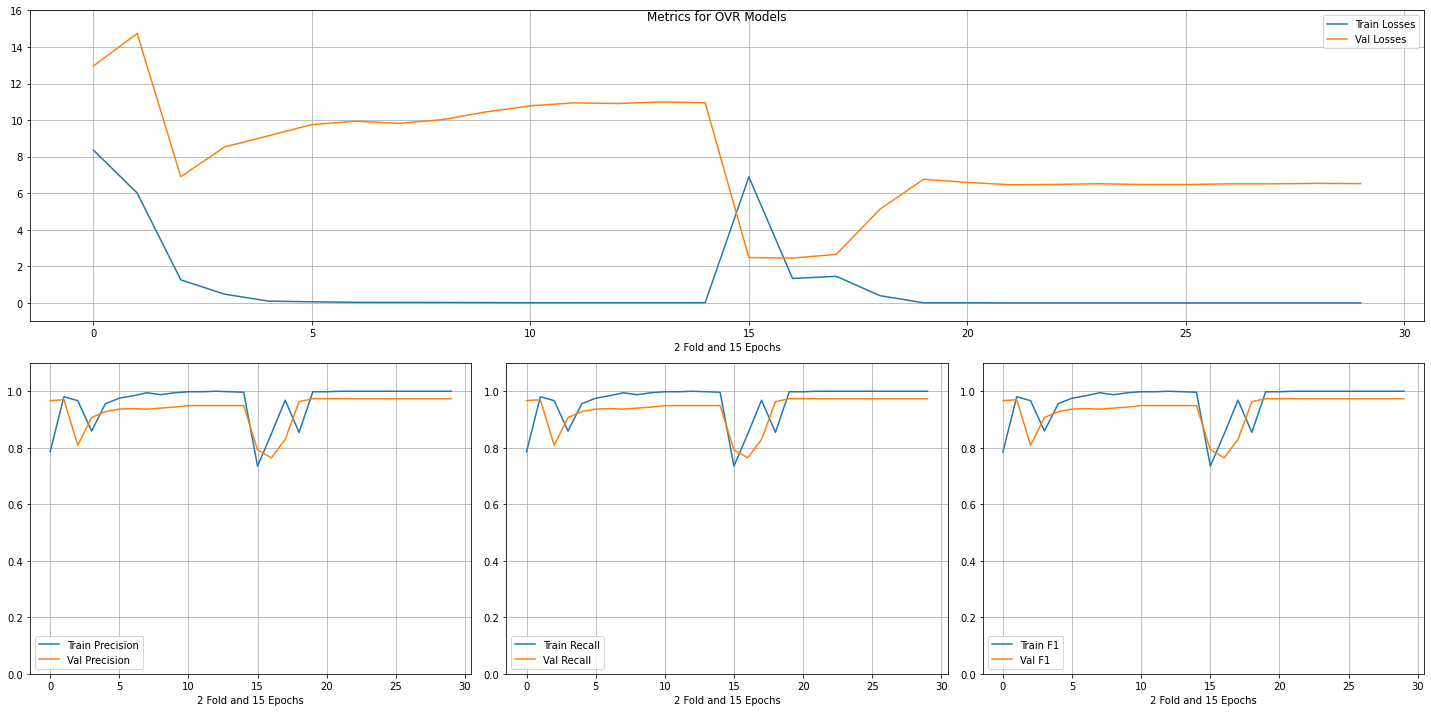

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.973638  ...      0.000721           6.524831
13  1.000000       0.973638  ...      0.000654           6.538671
12  1.000000       0.973638  ...      0.000720           6.514600
11  1.000000       0.973638  ...      0.000814           6.513838
10  1.000000       0.973638  ...      0.000803           6.474328
9   1.000000       0.973638  ...      0.001109           6.477000
8   1.000000       0.973638  ...      0.000663           6.518466
7   1.000000       0.973638  ...      0.001350           6.480946
6   1.000000       0.973638  ...      0.001790           6.460091
5   0.998246       0.973638  ...      0.009526           6.591983
4   0.998246       0.973638  ...      0.005949           6.763841
1   0.980668       0.970175  ...      6.013539          14.736660
0   0.785589       0.966667  ...      8.356192          12.961481
3   0.854386       0.963093  ...      0.397055           5.127379
13  0.9982

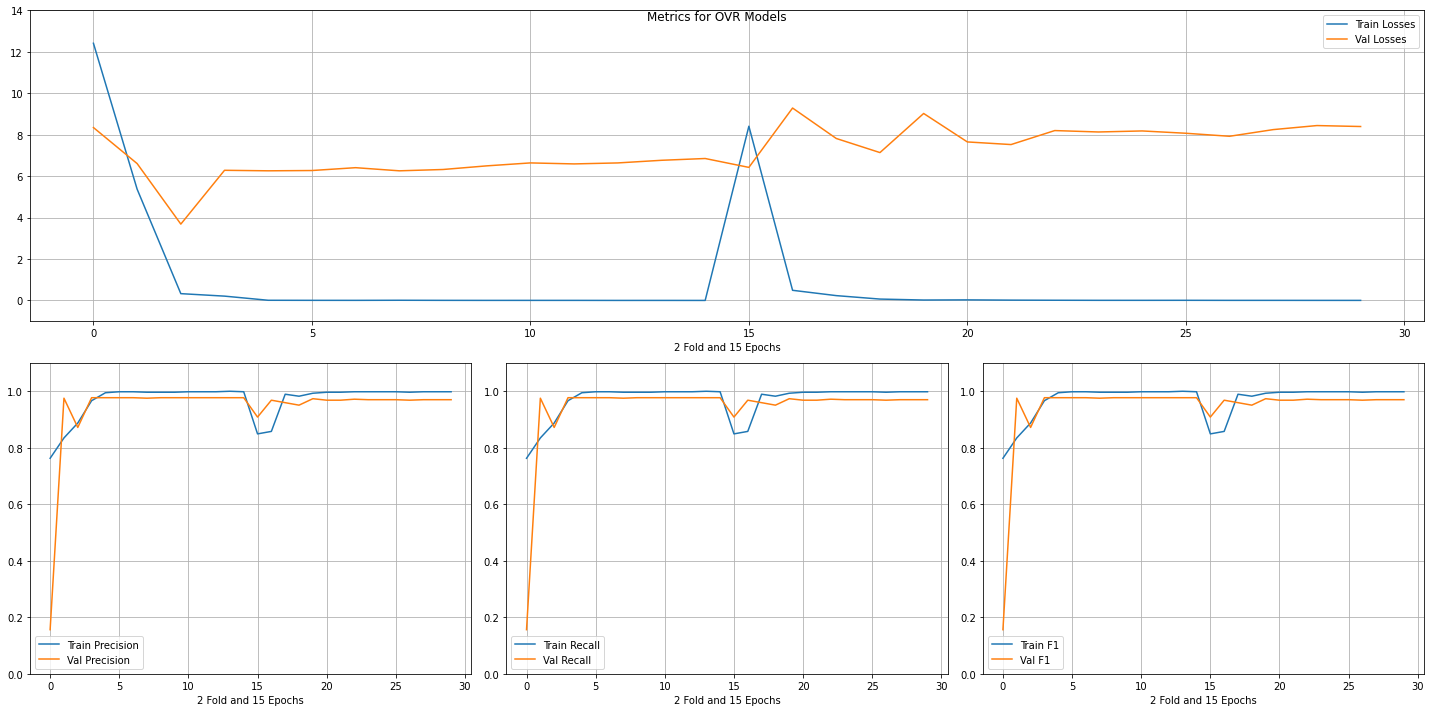

    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.977193  ...      0.003588           6.765672
8   0.996485       0.977193  ...      0.006318           6.321609
14  0.998243       0.977193  ...      0.002501           6.851947
12  0.998243       0.977193  ...      0.003045           6.638753
11  0.998243       0.977193  ...      0.005159           6.591000
10  0.998243       0.977193  ...      0.005112           6.639304
9   0.996485       0.977193  ...      0.004709           6.496925
6   0.998243       0.977193  ...      0.006172           6.409269
5   0.998243       0.977193  ...      0.007138           6.271976
4   0.994728       0.977193  ...      0.009910           6.258324
3   0.966608       0.977193  ...      0.209860           6.283073
7   0.996485       0.975439  ...      0.010672           6.257972
1   0.834798       0.975439  ...      5.372484           6.607383
4   0.992982       0.973638  ...      0.021567           9.025552
7   0.9982

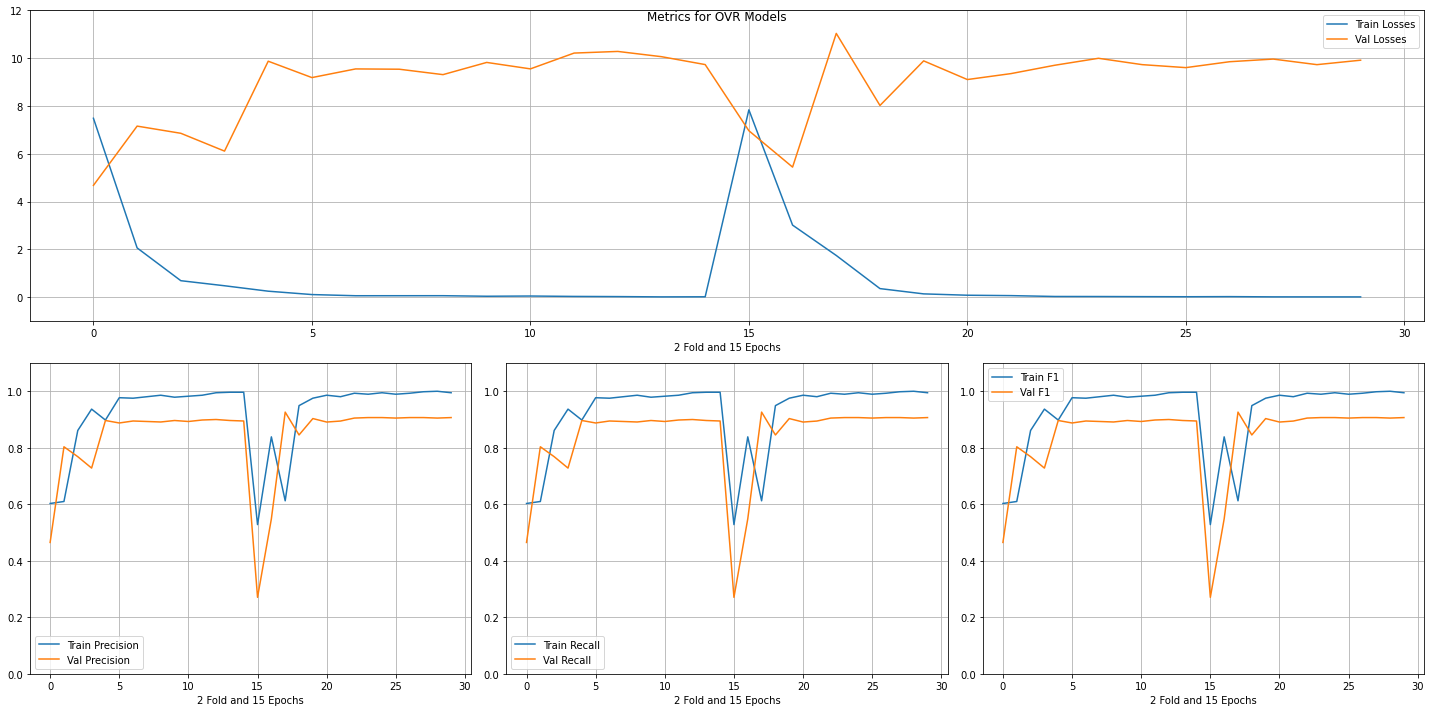

    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.612281       0.926186  ...      1.749336          11.037709
14  0.994737       0.906854  ...      0.016286           9.916928
11  0.992982       0.906854  ...      0.028089           9.853026
9   0.994737       0.906854  ...      0.027184           9.731443
8   0.989474       0.906854  ...      0.032111           9.996860
12  0.998246       0.906854  ...      0.018001           9.963891
10  0.989474       0.905097  ...      0.023105           9.606520
13  1.000000       0.905097  ...      0.016909           9.730902
7   0.992982       0.905097  ...      0.034189           9.705509
4   0.975439       0.903339  ...      0.142826           9.889021
12  0.994728       0.900000  ...      0.029432          10.283742
11  0.985940       0.898246  ...      0.036444          10.215135
9   0.978910       0.896491  ...      0.043632           9.823809
4   0.898067       0.896491  ...      0.255150           9.874782
13  0.9964

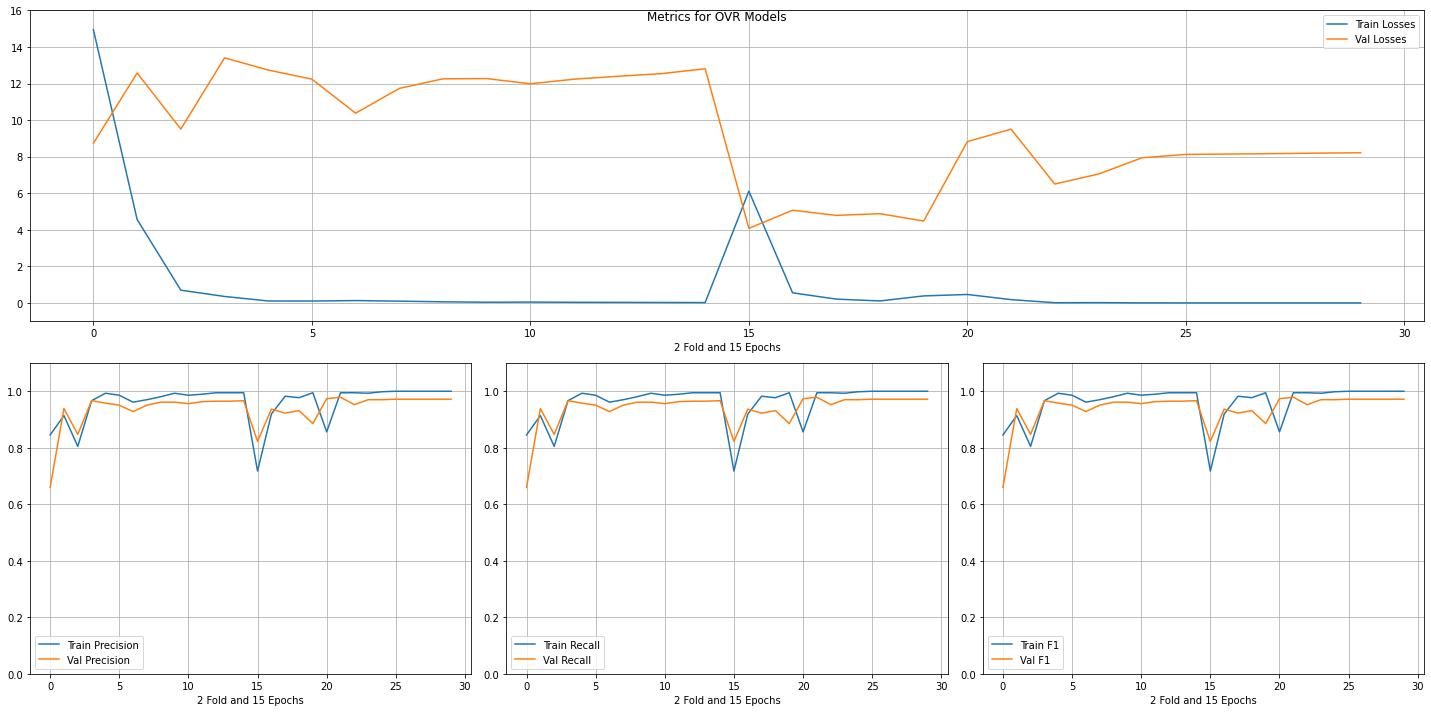

    train_f1  validation_f1  ...  train_losses  validation_losses
6   0.994737       0.978910  ...      0.180370           9.505218
5   0.856140       0.973638  ...      0.462332           8.822608
14  1.000000       0.971880  ...      0.000701           8.213342
13  1.000000       0.971880  ...      0.001029           8.193112
11  1.000000       0.971880  ...      0.000978           8.143594
10  1.000000       0.971880  ...      0.001601           8.123448
12  1.000000       0.971880  ...      0.001122           8.164668
9   0.998246       0.970123  ...      0.002792           7.939324
8   0.992982       0.970123  ...      0.015753           7.047739
14  0.994728       0.966667  ...      0.019361          12.808288
3   0.966608       0.966667  ...      0.353350          13.405749
12  0.994728       0.964912  ...      0.030037          12.395443
13  0.994728       0.964912  ...      0.023521          12.541178
11  0.989455       0.963158  ...      0.033893          12.237887
9   0.9929

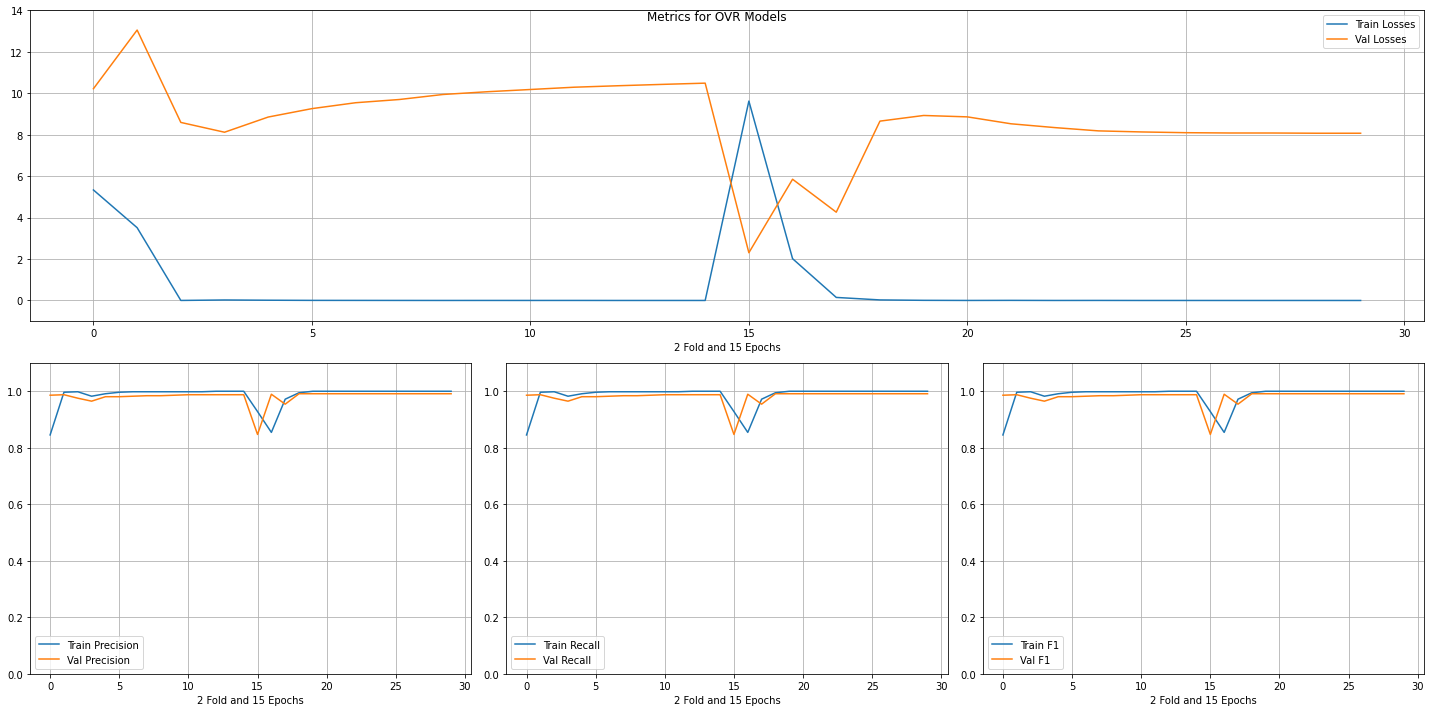

    train_f1  validation_f1  ...  train_losses  validation_losses
14  1.000000       0.991213  ...      0.000222           8.071781
9   1.000000       0.991213  ...      0.000524           8.133393
5   1.000000       0.991213  ...      0.001941           8.861482
4   1.000000       0.991213  ...      0.007309           8.928902
7   1.000000       0.991213  ...      0.001083           8.343991
8   1.000000       0.991213  ...      0.002650           8.185172
6   1.000000       0.991213  ...      0.005456           8.527365
10  1.000000       0.991213  ...      0.000764           8.098089
11  1.000000       0.991213  ...      0.000342           8.083350
12  1.000000       0.991213  ...      0.000295           8.082349
13  1.000000       0.991213  ...      0.000498           8.071457
3   0.994737       0.991213  ...      0.026843           8.656256
1   0.854386       0.989455  ...      2.017840           5.851366
10  0.998243       0.987719  ...      0.001661          10.182555
11  0.9982

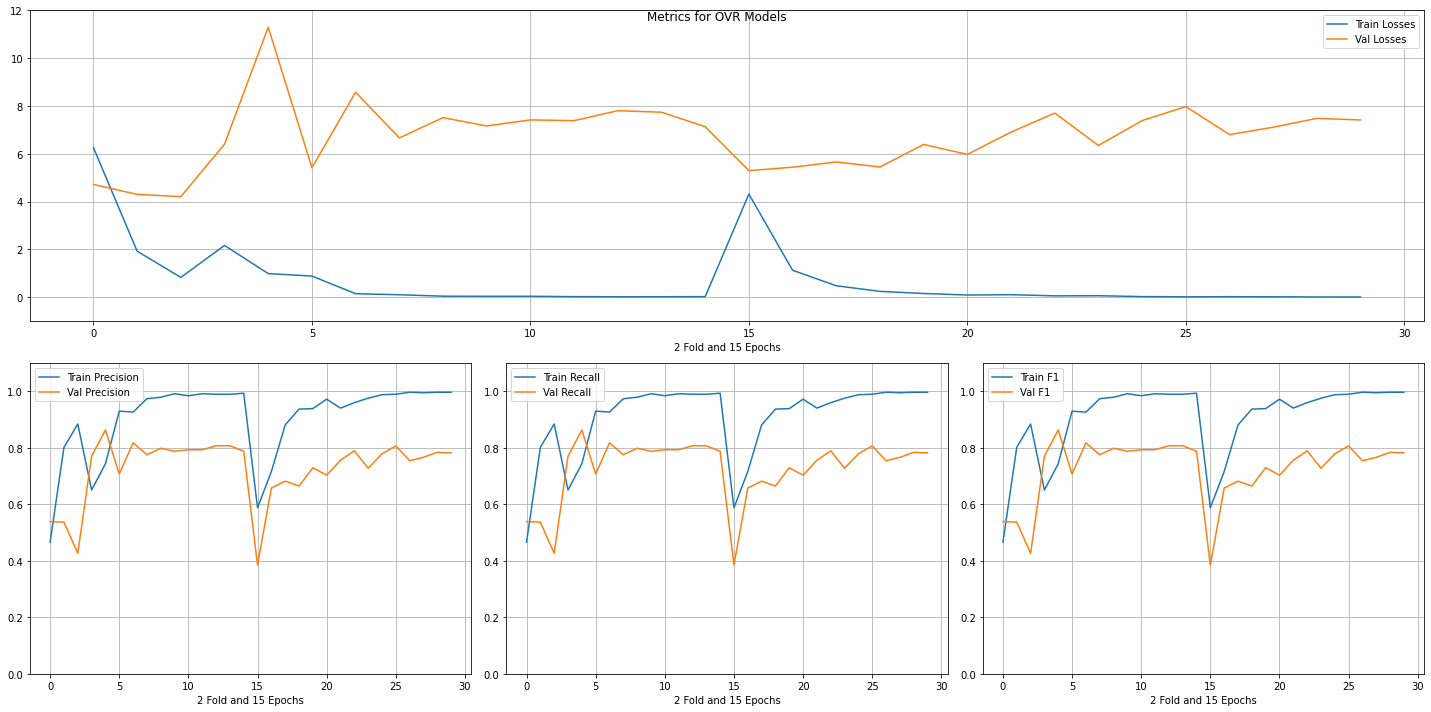

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.743409       0.863158  ...      0.990386          11.298629
6   0.926186       0.817544  ...      0.150255           8.579446
13  0.989455       0.807018  ...      0.022892           7.741505
12  0.989455       0.807018  ...      0.021358           7.804938
10  0.989474       0.806678  ...      0.020201           7.977605
8   0.978910       0.798246  ...      0.046315           7.514808
10  0.984183       0.792982  ...      0.042637           7.420182
11  0.991213       0.792982  ...      0.026630           7.388989
7   0.959649       0.789104  ...      0.060230           7.705869
9   0.991213       0.787719  ...      0.041533           7.166427
14  0.992970       0.787719  ...      0.025996           7.135196
13  0.996491       0.783831  ...      0.013715           7.484821
14  0.996491       0.782074  ...      0.013048           7.416396
9   0.987719       0.778559  ...      0.028310           7.390589
7   0.9736

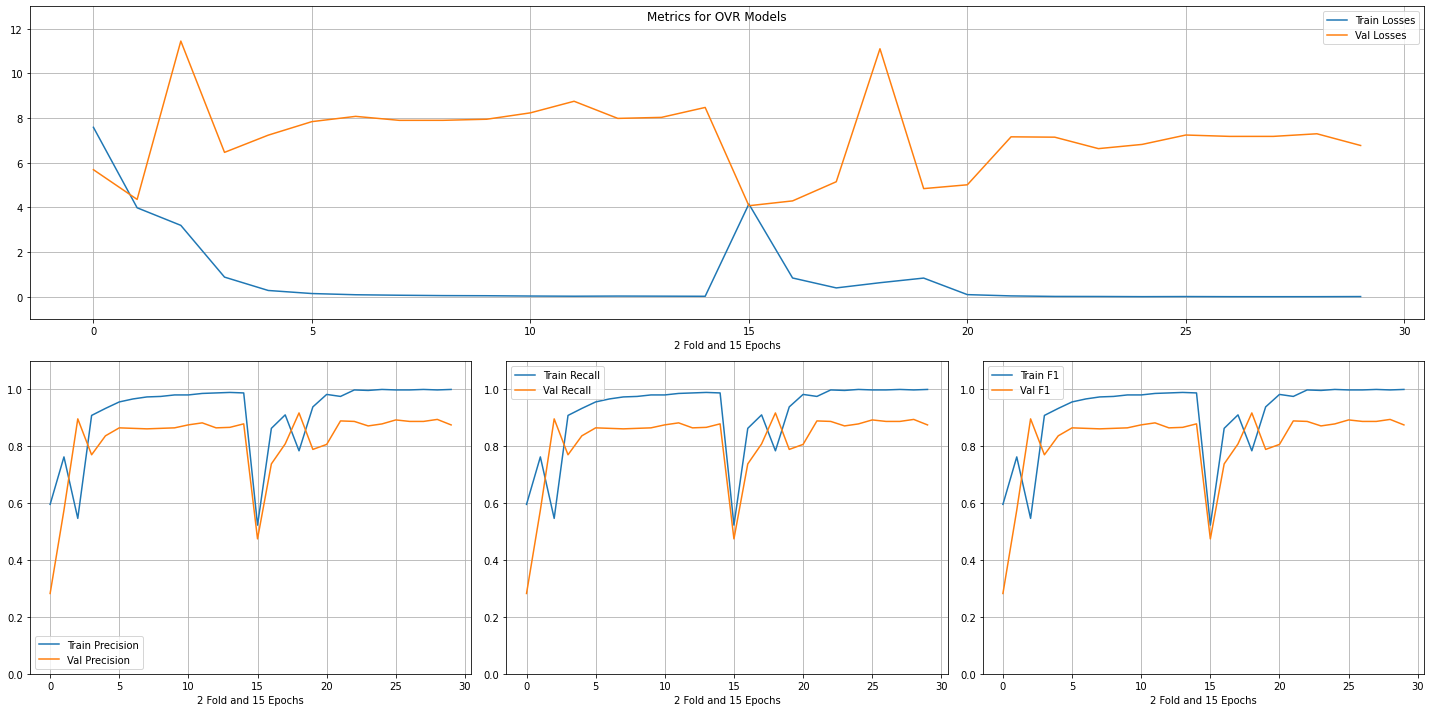

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.784211       0.917399  ...      0.632883          11.104315
2   0.546573       0.896491  ...      3.200160          11.448363
13  0.998246       0.894552  ...      0.008162           7.299112
10  0.998246       0.892794  ...      0.013477           7.243049
6   0.975439       0.889279  ...      0.042541           7.162435
12  1.000000       0.887522  ...      0.007397           7.181978
11  0.998246       0.887522  ...      0.008466           7.182093
7   0.998246       0.887522  ...      0.019558           7.146853
11  0.985940       0.882456  ...      0.028782           8.754270
14  0.987698       0.878947  ...      0.025836           8.477336
9   1.000000       0.878735  ...      0.009024           6.822989
10  0.980668       0.875439  ...      0.036605           8.235569
14  1.000000       0.875220  ...      0.013213           6.774736
8   0.996491       0.871705  ...      0.016452           6.634197
13  0.9894

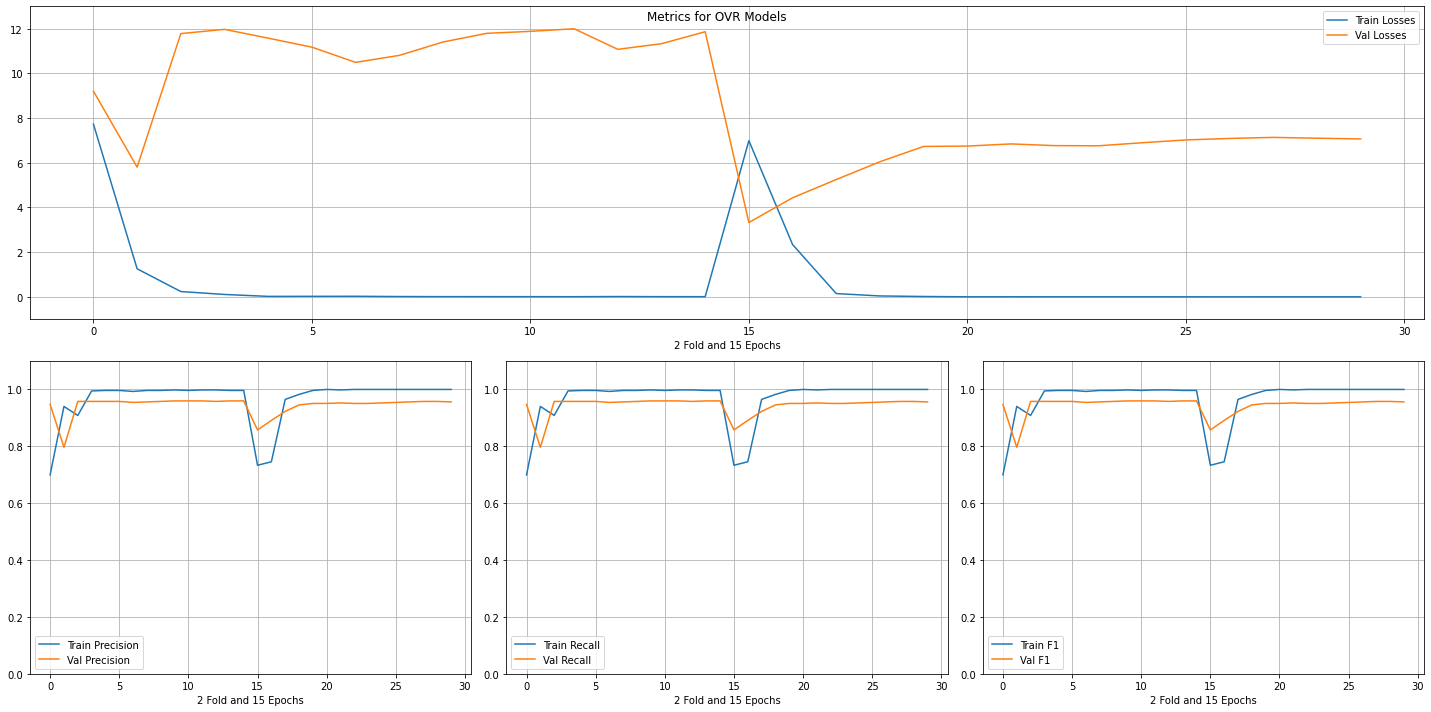

    train_f1  validation_f1  ...  train_losses  validation_losses
9   0.998243       0.959649  ...      0.009151          11.794347
10  0.996485       0.959649  ...      0.008482          11.883775
11  0.998243       0.959649  ...      0.006873          11.998994
13  0.996485       0.959649  ...      0.009032          11.330190
14  0.996485       0.959649  ...      0.007340          11.866711
12  0.998243       0.957895  ...      0.014080          11.078966
2   0.908612       0.957895  ...      0.237873          11.782989
3   0.994728       0.957895  ...      0.107219          11.972372
4   0.996485       0.957895  ...      0.021225          11.578786
5   0.996485       0.957895  ...      0.023901          11.175237
8   0.996485       0.957895  ...      0.009842          11.406794
13  1.000000       0.957821  ...      0.001841           7.100248
12  1.000000       0.957821  ...      0.001822           7.137407
7   0.996485       0.956140  ...      0.013922          10.807660
11  1.0000

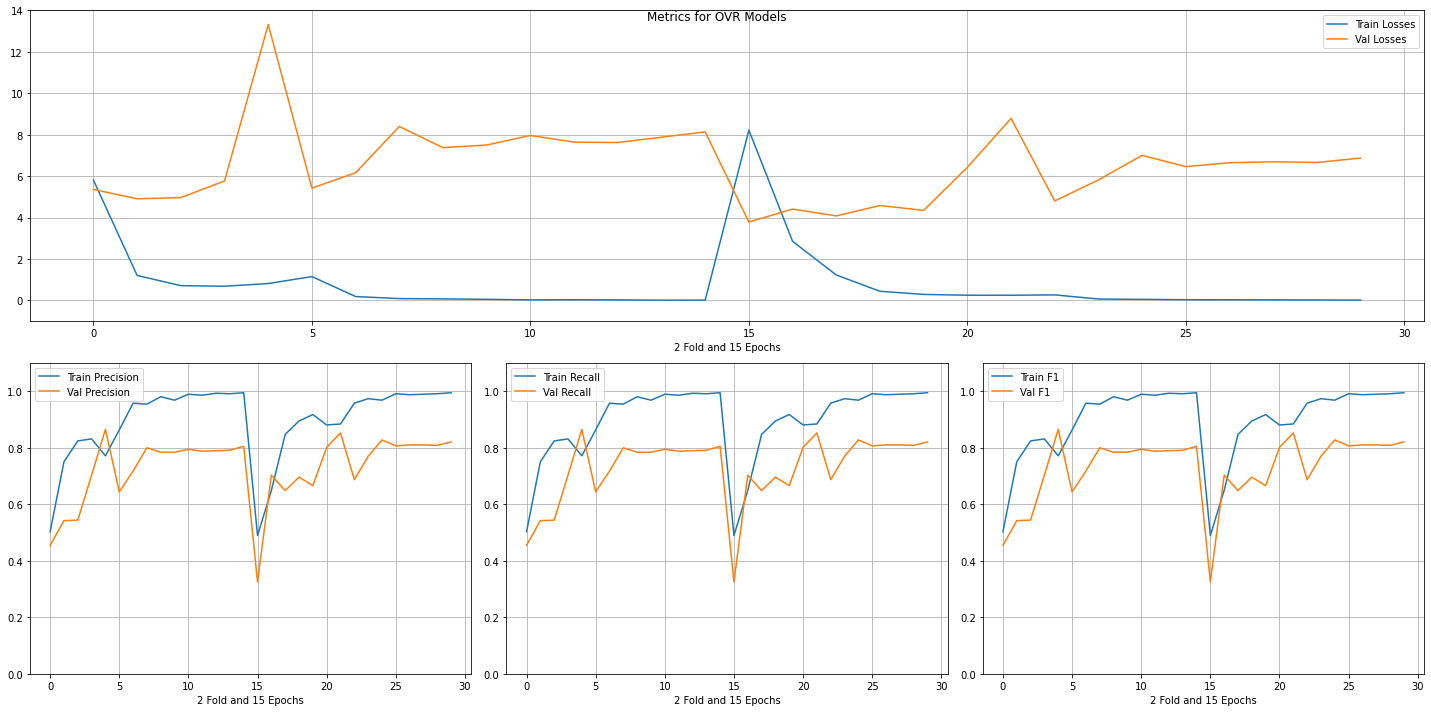

    train_f1  validation_f1  ...  train_losses  validation_losses
4   0.771529       0.864912  ...      0.817808          13.317213
6   0.884211       0.852373  ...      0.252230           8.789499
9   0.968421       0.827768  ...      0.054073           7.003485
14  0.994737       0.820738  ...      0.019670           6.871888
11  0.987719       0.810193  ...      0.032896           6.647308
12  0.989474       0.810193  ...      0.030454           6.693603
13  0.991228       0.808436  ...      0.025314           6.661442
10  0.991228       0.806678  ...      0.037550           6.460348
14  0.994728       0.805263  ...      0.017648           8.135654
5   0.880702       0.801406  ...      0.253662           6.426111
7   0.954306       0.800000  ...      0.091353           8.396843
10  0.989455       0.794737  ...      0.029847           7.963946
13  0.991213       0.791228  ...      0.015305           7.880088
12  0.992970       0.789474  ...      0.028834           7.624540
11  0.9859

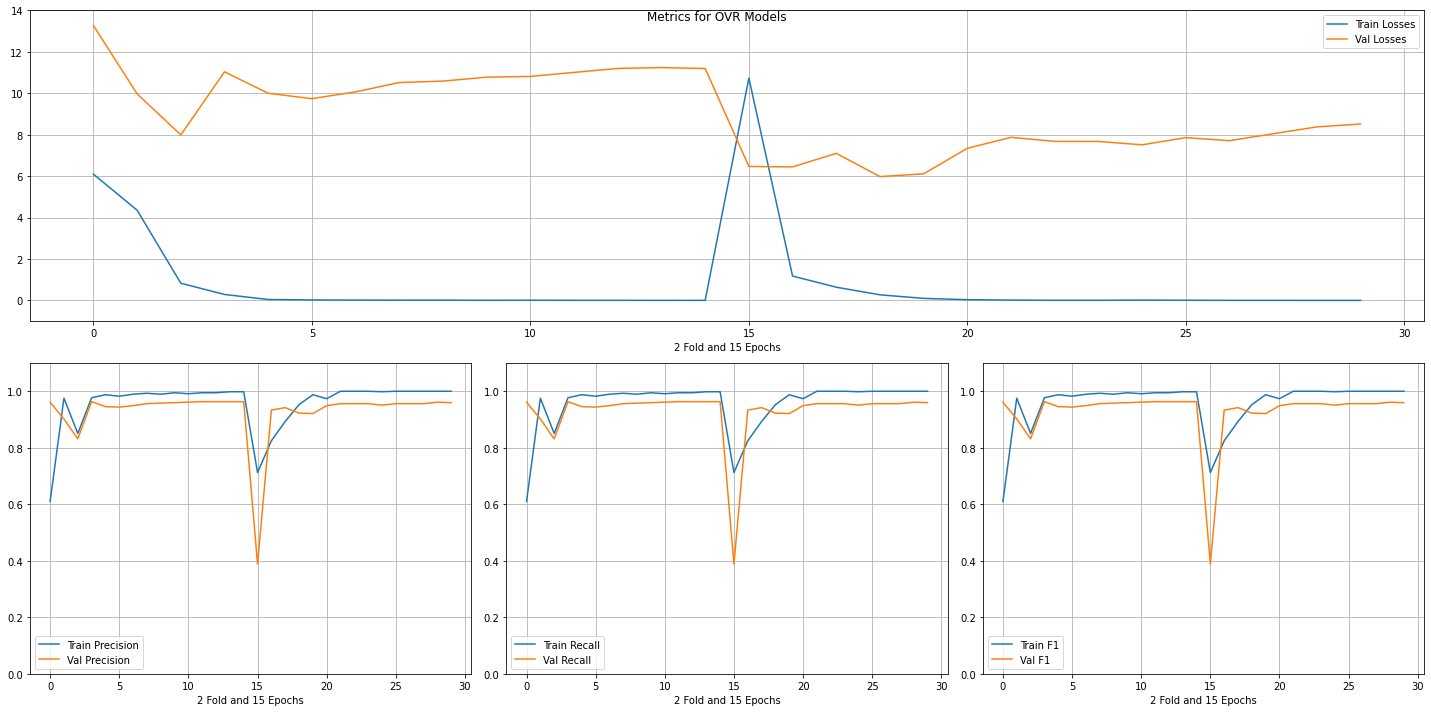

    train_f1  validation_f1  ...  train_losses  validation_losses
3   0.977153       0.963158  ...      0.290004          11.035555
14  0.998243       0.963158  ...      0.006481          11.194742
13  0.998243       0.963158  ...      0.005145          11.241454
12  0.994728       0.963158  ...      0.008288          11.198608
11  0.994728       0.963158  ...      0.008343          11.007683
0   0.609842       0.961404  ...      6.095063          13.269082
10  0.991213       0.961404  ...      0.013185          10.813339
13  1.000000       0.961336  ...      0.004372           8.377499
9   0.994728       0.959649  ...      0.009054          10.777552
14  1.000000       0.959578  ...      0.004295           8.517908
8   0.989455       0.957895  ...      0.016053          10.588564
7   0.992970       0.956140  ...      0.014229          10.518770
12  1.000000       0.956063  ...      0.005878           8.047503
11  1.000000       0.956063  ...      0.006361           7.712455
10  1.0000

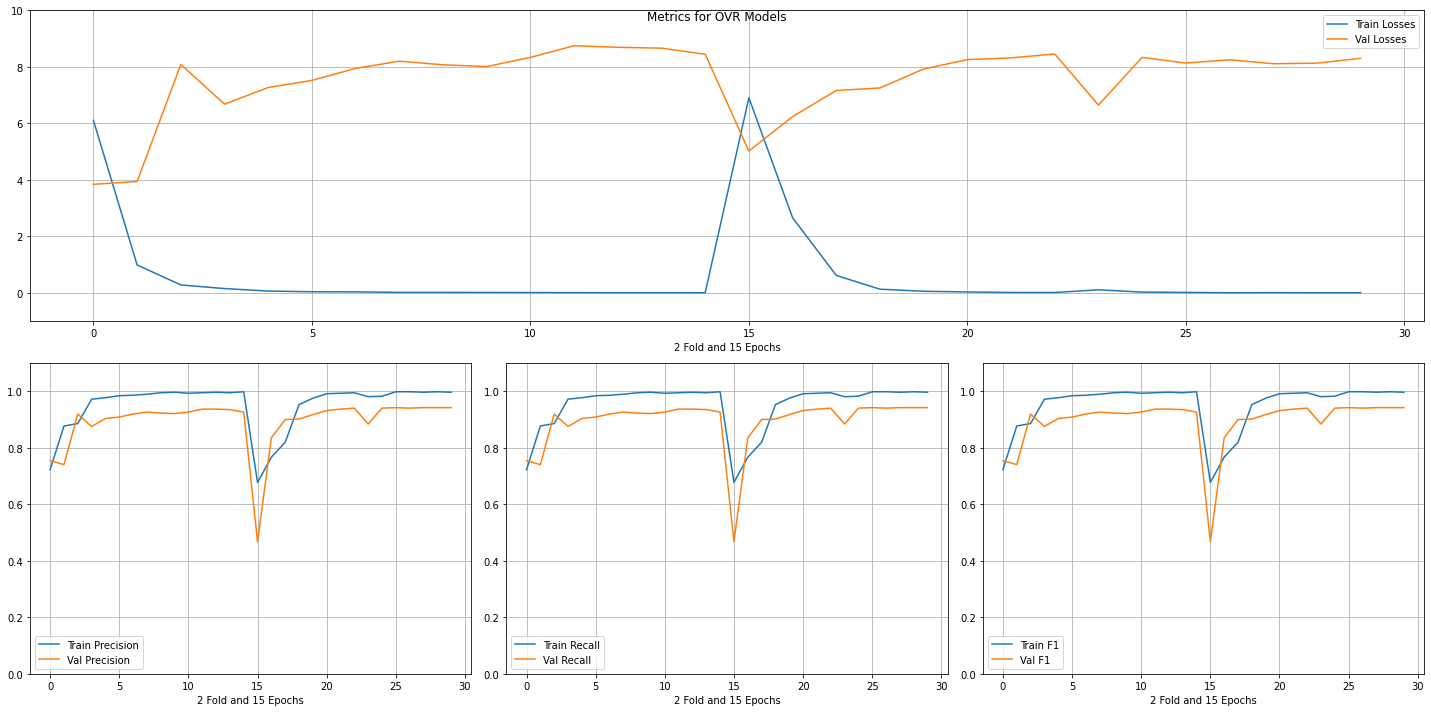

    train_f1  validation_f1  ...  train_losses  validation_losses
14  0.996491       0.942004  ...      0.008173           8.305275
12  0.996491       0.942004  ...      0.011436           8.112540
10  0.998246       0.942004  ...      0.018632           8.136172
13  0.998246       0.942004  ...      0.007353           8.133003
9   0.982456       0.940246  ...      0.029998           8.336748
7   0.994737       0.940246  ...      0.015952           8.457985
11  0.998246       0.940246  ...      0.007577           8.252628
11  0.994728       0.936842  ...      0.011470           8.749202
12  0.996485       0.936842  ...      0.008807           8.693954
6   0.992982       0.936731  ...      0.016994           8.319890
13  0.994728       0.935088  ...      0.009251           8.664070
5   0.991228       0.931459  ...      0.035181           8.258240
14  0.998243       0.926316  ...      0.008409           8.447311
7   0.989455       0.926316  ...      0.019535           8.203464
10  0.9929

In [37]:
jovr_res_reduced = ovr_train_model(data, MelJanakaDataset, MelRagaFtFusion,
                                   "OVR Models", jlabels1, cl, lbl_encoder=jle,
                                   target='JanakaRagamCode', lr=1e-5, epochs=15, n_folds=2, feature='mel_spec')

In [39]:
for k in jovr_res_reduced:
  print(jle.inverse_transform([k]))
  print(results_to_df(jovr_res_reduced[k]).head())

['Chalanata']
    train_f1  validation_f1  ...  train_losses  validation_losses
14       1.0       0.973638  ...      0.000721           6.524831
13       1.0       0.973638  ...      0.000654           6.538671
12       1.0       0.973638  ...      0.000720           6.514600
11       1.0       0.973638  ...      0.000814           6.513838
10       1.0       0.973638  ...      0.000803           6.474328

[5 rows x 8 columns]
['Hanumatodi']
    train_f1  validation_f1  ...  train_losses  validation_losses
13  1.000000       0.977193  ...      0.003588           6.765672
8   0.996485       0.977193  ...      0.006318           6.321609
14  0.998243       0.977193  ...      0.002501           6.851947
12  0.998243       0.977193  ...      0.003045           6.638753
11  0.998243       0.977193  ...      0.005159           6.591000

[5 rows x 8 columns]
['Harikambhoji']
    train_f1  validation_f1  ...  train_losses  validation_losses
2   0.612281       0.926186  ...      1.749336      